### Authors
Cathal Crowe - 21320128 \
Robert Flanagan - 21311625 \
Steven Lavelle - 21316945

### Execution
The code executes to the end without an error.

### Implementation References (Other References Below)
https://keras.io/examples/rl/deep_q_network_breakout - Adapted network structure and hyperparameters<br>
https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py - Adapted network structure

In [15]:
# Import our dependencies
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.wrappers import (
    AtariPreprocessing,
    FrameStackObservation,
    RecordVideo,
)
import ale_py
import matplotlib.pyplot as plt

In [16]:
# Configure our parameters
seed = 42
gamma = 0.99
learning_rate = 0.0001
max_episodes = 1500
epsilon_max = 1
epsilon_min = 0.01
epsilon_decay = np.exp(np.log(epsilon_min / epsilon_max) / max_episodes)
weight_decay = 0.0001
batch_size = 64
max_steps_per_episode = 1000
replay_buffer_size = 100000
target_update_frequency = 1000
start_training_after = 1000
update_after_actions = 4
video_folder = "recorded_episodes"

In [ ]:
# Track highest reward and episode
highest_reward = 0
highest_reward_episode = 0

# Environment setup
os.makedirs(video_folder, exist_ok=True)
gym.register_envs(ale_py)
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=lambda x: x % 100 == 0,
)
env = AtariPreprocessing(env, frame_skip=1)
env = FrameStackObservation(env, 4)
env.reset(seed=seed)

# Set device to GPU if available else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define our model
num_actions = 4
input_dim = (4, 84, 84)
output_dim = num_actions

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim

        # Convolutional layers
        self.feature_layer = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Compute the output size of the convolutional layers
        conv_output_size = self.conv_output_dim()
        # Hidden layer size
        hidden_size = 512

        # Separate stream for values
        self.value_stream = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),  # Outputs scalar state-value V(s)
        )

        # Separate stream for advantages
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_dim),  # Outputs advantages A(s, a)
        )

    # Compute the output size of the convolutional layers
    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.feature_layer(x)
        return int(np.prod(x.shape))

    # Forward pass
    def forward(self, x):
        x = self.feature_layer(x)
        x = x.view(x.shape[0], -1)

        # Compute value and advantages
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine streams to calculate Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# Initialize our model and target model
model = DuelingDQN(input_dim, output_dim).to(device)
model_target = DuelingDQN(input_dim, output_dim).to(device)
model_target.load_state_dict(model.state_dict())

# Define our optimizer
optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

In [19]:
# Experience replay buffers
action_history, state_history, state_next_history = [], [], []
rewards_history, done_history = [], []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

In [20]:
# Plot training performance
def plot_training_performance(episode_rewards, running_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(running_rewards, label='Running Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Performance')
    plt.legend()
    plt.show()
    
# Plot epsilon decay
def plot_epsilon_decay(epsilon_values):
    plt.figure(figsize=(12, 6))
    plt.plot(epsilon_values, label="Epsilon")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Epsilon Decay Over Episodes")
    plt.legend()
    plt.show()

Episode 1 - Reward: 2.000, Running Reward: 2.000, Epsilon: 0.997, Highest Reward: 2.000 (Episode 1)
Episode 2 - Reward: 2.000, Running Reward: 2.000, Epsilon: 0.994, Highest Reward: 2.000 (Episode 1)
Episode 3 - Reward: 0.000, Running Reward: 1.333, Epsilon: 0.991, Highest Reward: 2.000 (Episode 1)
Episode 4 - Reward: 1.000, Running Reward: 1.250, Epsilon: 0.988, Highest Reward: 2.000 (Episode 1)
Episode 5 - Reward: 2.000, Running Reward: 1.400, Epsilon: 0.985, Highest Reward: 2.000 (Episode 1)
Episode 6 - Reward: 1.000, Running Reward: 1.333, Epsilon: 0.982, Highest Reward: 2.000 (Episode 1)
Episode 7 - Reward: 1.000, Running Reward: 1.286, Epsilon: 0.979, Highest Reward: 2.000 (Episode 1)
Episode 8 - Reward: 2.000, Running Reward: 1.375, Epsilon: 0.976, Highest Reward: 2.000 (Episode 1)
Episode 9 - Reward: 1.000, Running Reward: 1.333, Epsilon: 0.973, Highest Reward: 2.000 (Episode 1)
Episode 10 - Reward: 2.000, Running Reward: 1.400, Epsilon: 0.970, Highest Reward: 2.000 (Episode 1)

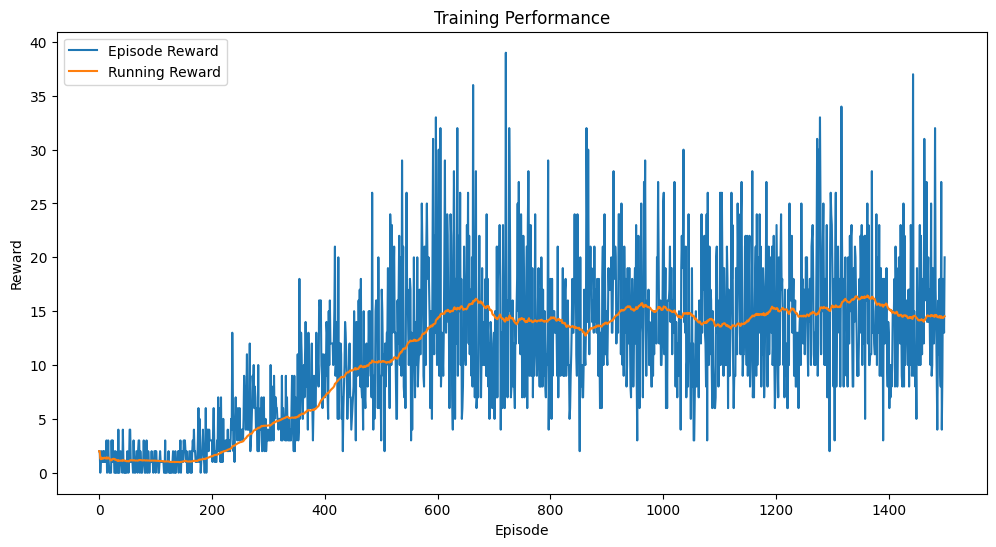

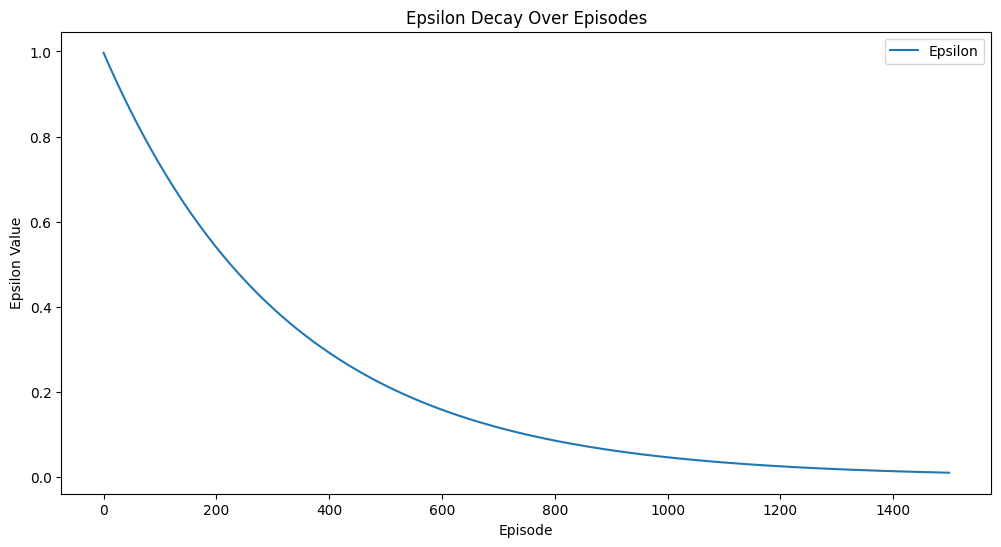

In [ ]:
# Collect episode rewards, running rewards, and epsilon values across episodes
episode_rewards = []
running_rewards = []
epsilon_values = []

# Set epsilon to 1 for exploration
epsilon = epsilon_max

# Train the model
try:
    while True:
        observation, _ = env.reset()
        state = np.array(observation)
        episode_reward = 0

        for timestep in range(1, max_steps_per_episode):
            frame_count += 1

            # Epsilon-greedy exploration
            if frame_count < start_training_after or np.random.rand(1)[0] < epsilon:
                action = np.random.choice(num_actions)
            else:
                with torch.no_grad():
                    state_tensor = (
                        torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    )
                    action_probs = model(state_tensor)
                    action = action_probs.argmax().cpu().item()

            # Environment step
            state_next, reward, done, _, _ = env.step(action)
            state_next = np.array(state_next)

            episode_reward += reward

            # Save experiences
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

            # Update network
            if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
                # Sample batch
                indices = np.random.choice(range(len(done_history)), size=batch_size)

                # Prepare batch tensors
                state_sample = torch.tensor(
                    np.array([state_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                state_next_sample = torch.tensor(
                    np.array([state_next_history[i] for i in indices]), dtype=torch.float32
                ).to(device)
                rewards_sample = torch.tensor(
                    [rewards_history[i] for i in indices], dtype=torch.float32
                ).to(device)
                action_sample = torch.tensor(
                    [action_history[i] for i in indices], dtype=torch.long
                ).to(device)
                done_sample = torch.tensor(
                    [float(done_history[i]) for i in indices], dtype=torch.float32
                ).to(device)

                # Double DQN logic - select action using the main network
                with torch.no_grad():
                    # Get actions from the main network
                    action_next = model(state_next_sample).argmax(1)
                    # Evaluate actions using the target network
                    target_q_values = (
                        model_target(state_next_sample)
                        .gather(1, action_next.unsqueeze(1))
                        .squeeze(1)
                    )
                    updated_q_values = rewards_sample + gamma * target_q_values * (
                        1 - done_sample
                    )

                # Compute Q-values
                q_values = model(state_sample)
                q_action = q_values.gather(1, action_sample.unsqueeze(1)).squeeze(1)

                # Compute loss
                loss = F.smooth_l1_loss(q_action, updated_q_values)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network
            if frame_count % target_update_frequency == 0:
                model_target.load_state_dict(model.state_dict())

            # Trim memory
            if len(rewards_history) > replay_buffer_size:
                for history in [
                    rewards_history,
                    state_history,
                    state_next_history,
                    action_history,
                    done_history,
                ]:
                    del history[:1]

            if done:
                break
        # Decay exploration (epsilon) after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        episode_count += 1

        # Update highest reward and episode
        if episode_reward > highest_reward:
            highest_reward = episode_reward
            highest_reward_episode = episode_count
    
        # Collect rewards for plotting
        episode_rewards.append(episode_reward)
        running_reward = np.mean(episode_rewards[-100:])
        running_rewards.append(running_reward)

        # Collect epsilon values for plotting
        epsilon_values.append(epsilon)
            
        print(
            f"Episode {episode_count} - Reward: {episode_reward:.3f}, "
            f"Running Reward: {running_reward:.3f}, Epsilon: {epsilon:.3f}, "
            f"Highest Reward: {highest_reward:.3f} (Episode {highest_reward_episode})"
        )

        # Termination condition
        if episode_count >= max_episodes:
            print(f"Stopped at episode {episode_count}!")
            # Save the trained model
            torch.save(model.state_dict(), "dqn_trained_model.pth")
            print("Model saved to dqn_trained_model.pth")
            break
finally:
    env.close()

# Plot the training performance
plot_training_performance(episode_rewards, running_rewards)

# Plot the epsilon decay
plot_epsilon_decay(epsilon_values)

# Why Reinforcement Learning is the machine learning paradigm of choice for this task
The goal of this project is to train a machine learning paradigm to learn to play an Atari game. The game we have chosen is Breakout due to its simplicity and easily trackable reward. Reinforcement learning is a type of machine learning where the agent learns to make choices by interacting with its environment with the goal of maximizing its reward. Reinforcement learning's ability to learn through interaction, optimize rewards and handle sequential decisions make it the obvious choice for this task. Here are a few of these reasons in more detail:
## Sequential Decision Making
Breakout is a game comprised of sequential decisions where at every step the agent must decide to move left move right or stay still. Each decision changes the game state and affects the next decision. Due to this, decisions need to be made with long term strategy in mind instead of just focusing on short term reward. This makes reinforcement learning the ideal choice as it focuses on maximising long-term reward.
## Deep Learning
Reinforcement learning can leverage deep learning techniques in the form of a DQN. This allows us to handle the high dimensional input of a game like Breakout.
## Exploration and Exploitation
To maximise reward, it is important not to converge on sub optimal strategies. Reinforcement learning utilises epsilon-greedy exploration to ensure there is a balance between exploiting (choosing the action the agent knows will get it more reward immediately) and exploring (making a decision that improves the agent's knowledge and might lead to better long-term reward).
## Unlabelled Data
Machine learning paradigms such as reinforcement learning that rely on labelled data would be unsuitable for this task as games like breakout have no explicit labels mapping actions to rewards. This means the chosen paradigm must discover strategy through trial and error which is exactly how reinforcement learning works.
# The Gym Environment
Gymnasium is a project that provides an API for all single agent reinforcement learning environments. For this project we use the "ALE/Breakout-v5" gym environment provided by The Arcade Learning Environment (ALE) which provides a simulation of Breakout allowing our agent to interact with and learn from the game through an interface. It outputs images that represent the game state which includes the important elements like the ball, the paddle and the bricks. The agent analyses these images to determine its actions. The agent has 4 actions to choose from, these being start game, move left, move right or staying still. The reward system is central to how our agent learns. In this game the agent earns rewards by breaking blocks and keeping the ball in play. By interacting with the environment, the agent learns the optimal strategies to achieve the highest reward.
# Implementation
## Capture and pre-processing of the data
### Pre-processing
Our data is pre-processed using the AtariPreprocessing wrapper imported from Gymnasium. All parameters are left on the default ones except that we specify our frame_skip parameter to 1, as we already skip 4 frames based on the environment’s default internal frame skipping with gym.make("ALE/Breakout-v5"), leaving this field blank would add a further frame skip of 4, leading to undesirable results. The screen size of the processed screen is set to 84px. We convert our frames to grayscale to reduce complexity as colour is of no interest to us in training this model. This reduces the input dimensionality into a single channel as opposed to 3 with RGB. Overall, our pre-processing is setup to reduce the complexity of our input, while preserving essential information for learning. This provides us with more efficient data to train off.
### Capture
We store episode rewards and running rewards in lists. Episode rewards are a list of all rewards earned from each episode. Running rewards are a list of all rewards earned over the last 100 episodes and are used to provide an average for the current state of the model. The environment is reset at the start of each episode, the variable episode_reward tracks the total reward for the current episode. If exploration is enabled (determined by epsilon-greedy strategy), the agent randomly chooses an action. Otherwise, the agent uses the model to select the action with the highest value by exploitation. After taking an action, the environment returns the next state, reward, and flag stating whether the episode has finished. The agent stores experiences in lists, and once enough experiences are obtained, the agent samples a random batch of experiences for training. We do this to ensure that our model learns from diverse experiences. We then apply our double DQN update by computing target Q-values based on the target network’s predictions, which are then compared with the Q-values from the main network to calculate the loss. The network updates are then updated using backpropagation along with the Adam optimizer. The target network’s weights are updated periodically to match the main network. This allows us to stabilize training by using a fixed target for the Q-value updates. After each episode the epsilon decays to reduce the amount of exploration over time. We record every 100 episodes as an mp4 video file to view our model in action and to be able to observe the results and behaviour.
## The Network Structure 
Our network structure is built in accordance with a Dueling DQN architecture. Our network is built to handle an input of 4 frames of 84x84 pixels stacked on each other. Our output dimensions are set as the number of actions in Atari Breakout, which is 4 (start game, move left, move right, don’t move). The number of channels is set to 4, one for each frame as we are stacking 4 frames on each other for input.
```python
num_actions = 4
input_dim = (4, 84, 84)
output_dim = num_actions

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim
```
For feature extraction, we have a sequence of 3 convolutional layers to extract spatial features in the input images. The first layer takes our 4 input channels and applies 32 filters with a kernel size of 8x8, a stride of 4 and a padding of 2. The second layer applies 64 filters with a kernel size of 4x4, a stride of 2 and a padding of 1. Finally, the third layer applies 64 filters with a kernel size 3, a stride of 1 and a padding of 1. We apply the ReLU activation function after each convolution to help the network learn complex patterns. After our input passes through these layers, we are left with our feature map.
```python
self.feature_layer = nn.Sequential(
    nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
)
```
We have two separate streams in our network. The value stream is used to estimate the value of the state, which is the expected value returned by that state. To achieve this we use a fully connected layer. The first linear layer maps the output of our convolutional layers to a hidden layer of size 512. We then apply a ReLU activation function to introduce non-linearity. The second layer reduces this to a scalar output representing the state value.
```python
conv_output_size = self.conv_output_dim()
hidden_size = 512

self.value_stream = nn.Sequential(
    nn.Linear(conv_output_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
)
```
The advantage stream is used to estimate the advantage or relative benefit of each action in a given state. This is very similar to our value stream, however, instead of outputting a singular scalar value, we output a vector of size 3, where each element in this vector corresponds to each action.
```python
self.advantage_stream = nn.Sequential(
    nn.Linear(conv_output_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_dim),
)
```
The forward pass passes our input first through the feature layer to extract spatial features as stated previously. We then flatten the output to a 1D vector to make it suitable for our fully connected layers. We then compute the value and advantage using our streams. The final q value is then calculated by combining the value and advantage. This is the final Q-value for each action in a given state.
```python
def forward(self, x):
    x = self.feature_layer(x)
    x = x.view(x.shape[0], -1)
    value = self.value_stream(x)
    advantage = self.advantage_stream(x)
    q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
    return q_values
```
Our conv_output_dim function computes the output size of our convolutional layers. As we are decreasing the spatial dimensions of the input after each layer, we use this function to calculate the size of the feature map after passing through all convolutional layers.
```python
def conv_output_dim(self):
    x = torch.zeros(1, *self.input_dim)
    x = self.feature_layer(x)
    return int(np.prod(x.shape))
```
We initialize both our models of the Dueling DQN to support our Double DQN setup. We use the main network to select the next action, and the model target to evaluate the action selected by the main network. We then compute the updated Q-value based on this evaluation and change the Q-value the updated one. We also initialize our Adam optimizer here with our learning rate and weight decay variables.
```python
model = DuelingDQN(input_dim, output_dim).to(device)
model_target = DuelingDQN(input_dim, output_dim).to(device)
model_target.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
```
## Hyperparameters
We used various hyperparameters throughout creating this DQN for Atari Breakout. The hyperparameters had a large effect on the output of rewards and how successful the DQN was. We changed the hyperparameters multiple times with varying success, either increasing running rewards or significantly decreasing running rewards, causing our DQN to struggle to get a score above 4 in some cases.
```python
gamma = 0.99
learning_rate = 0.0001
max_episodes = 1500
epsilon_max = 1
epsilon_min = 0.01
epsilon_decay = np.exp(np.log(epsilon_min / epsilon_max) / max_episodes)
weight_decay = 0.0001
batch_size = 64
max_steps_per_episode = 1000
replay_buffer_size = 100000
target_update_frequency = 1000
start_training_after = 1000
update_after_actions = 4
```
### Gamma
Gamma was set to 0.99, this is to maximize future rewards. Lower values provided more immediate rewards but failed to yield overall higher rewards.
### Learning Rate
We found that a learning rate of 0.0001 was sufficient as this allowed us to accurately narrow down on consistent running rewards. We used various other learning rates like 0.00025 and larger learning rates, but they gave us diminished rewards in comparison, converging earlier. The Adam optimizer handles adjusting our learning rate throughout the training.
### Number of Episodes
We ran 1500 episodes, as this demonstrated reasonable convergence without being too computationally expensive. After 1500 episodes we got reduced rewards, with little overall change in episode rewards. Fewer episodes didn't realise the model to its full potential.
### Epsilon
We use a varied epsilon value that decayed exponentially over time, we start off running an epsilon value of 1 initially and this decays quickly in the beginning then slowing down to the minimum value of 0.01. This means the DQN will only make a random move 1% of the time, which means not much learning occurs here, and the DQN is more or less trained and no longer needs to explore as much. Our epsilon decays to 0.01 over the number of episodes ran so if we increase the number of episodes the decay is slower. Exponential decay provided better results than that of a linear one as our model can explore a lot early on, while choosing more exploitation on later episodes.
### Weight Decay
We use a weight decay value of 0.0001 through the Adam optimizer. This value appears to be optimal in nudging our weights toward zero to prevent them from growing excessively large. This value allowed us to stabilize our training at no additional overhead.
### Batch Size
We use a batch size of 64, this value is the number of episodes we use to sample during training from our replay buffer. A buffer size of 32 provided slightly worse results due to less experiences being considered. We also looked at a batch size of 128 which didn’t have a noticeable difference, other than increasing computational need. 64 provides a nice balance in providing previous experiences for training, while being computationally feasible.
### Max steps per episode
The max number of steps that can taking per episode is set at 1000, this allowed the DQN to take a variety of actions, without it getting stuck in a loop without further reward. This allows for experimentation and increases learning. Provides a good balance between necessary steps required to get a good reward while also reducing the number of unecessary actions.
### Replay Buffer Size
The replay buffer size was set to 100,000 this lets the DQN recall on past experiences, replacing old ones with newer ones once the buffer size has been reached.
### Target Update Frequency
We update our target network after every 1000 steps, as it balances stability and responsiveness. When updated too frequently, the target network became too similar to the main network, reducing stability. Infrequent updates caused the target network to become too outdated, leading to inaccurate Q-value targets
### Start Training After
We do not start training initially until after 1000 steps, ensuring the model explores the environment first. The network then updates after the first 1000 steps occur, so until then random exploration takes place. 1000 appeared to provide a nice balance between giving the model some freedom initially, while also not waiting too long to begin training.
### Update after actions
Updates to the network occur after every 4 actions. This stops the network from making constant updates letting the network learn.
## Where the Q learning update is applied to the weights
The Q-learning rate is updated on each episode iteration to find the best Q-value possible over the training of our agent. When the while loop begins the environment is reset and episode reward returns to 0. Then a for loop keeps track of timestep to run outlined steps per episode, ensuring the agent doesn’t get stuck in a loop making no progress. The agent doesn’t update Q values initially until after start training is exceeded or a random number is less than epsilon which will more than likely be true for as long as epsilon is still over 0.5. If both are false, the agent will go with exploitation over exploration and the model predicts the action with the highest Q value at this current state. The else part disables gradient computation reducing overall computation and memory. The state is converted to a PyTorch tensor and unsqueeze helps convert to the games input dimensions. The action is then selected based on which has the highest predicted Q value.
```python
try:
    while True:
        observation, _ = env.reset()
        state = np.array(observation)
        episode_reward = 0
        for timestep in range(1, max_steps_per_episode):
            frame_count += 1
            if frame_count < start_training_after or np.random.rand(1)[0] < epsilon:
                action = np.random.choice(num_actions)
            else:
                with torch.no_grad():
                    state_tensor = (
                        torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    )
                    action_probs = model(state_tensor)
                    action = action_probs.argmax().cpu().item()
```
We store experiences containing information on state, action, reward, next state, done in a replay buffer. This allows our model to sample experiences from the replay buffer when training.
```python
action_history.append(action)
state_history.append(state)
state_next_history.append(state_next)
done_history.append(done)
rewards_history.append(reward)
state = state_next
```
The gradient computation is disabled so the code inside doesn’t affect gradient, and a batch of samples are taking from the replay buffer we have. The Q values for the next states are got and it selects the one with the highest Q value. The target then calculates the Q value for the chosen action. The Q values are correlated to the corresponding actions. The Q value is then updated combining rewards observed and future rewards multiplied by target Q values and discounting future rewards when episode is done. Basically, the model selects the best actions and the target checks those actions and ensures the Q values are stable. The Q values are then added together with rewards which forms the Bellman target.
```python
with torch.no_grad():
    action_next = model(state_next_sample).argmax(1)
    target_q_values = (
        model_target(state_next_sample)
        .gather(1, action_next.unsqueeze(1))
        .squeeze(1)
    )
    updated_q_values = rewards_sample + gamma * target_q_values * (
        1 - done_sample
    )
```
After an action is selected the Q-values are calculated by passing state_sample through the model. The model then outputs the Q-values which represent the expected future rewards of each potential action in the current state. We use the gather function in order to retrieve the Q-value of the current action which is stored as q_action. Next, we calculate the loss by calculating the difference between the predicated Q-values and the updated Q-values with the F_smooth_l1_loss function. How this function works is it punishes small errors heavily using a squared error to help the agent make small adjustments for better accuracy. However, for large errors it takes the absolute error to reduce the impact of outliers. This loss value shows how far the models' predictions are from the true value. Next, we update the model by first resetting the optimizer with optimzer.zero.grad() which clears the gradients from the previous steps. Then we call loss.backward() to compute the new gradient based on the current loss. Finally, optimizer.step() updates the models parameters by applying the calculated gradients
```python
q_values = model(state_sample)
q_action = q_values.gather(1, action_sample.unsqueeze(1)).squeeze(1)
loss = F.smooth_l1_loss(q_action, updated_q_values)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```
## Independently researched concepts
### Random Seed Initialization
We use random seed initialization to ensure reproducibility in our models training and performance. To achieve this, we set a variable seed = 42 and set the gym environment accordingly. By setting the seed to a constant value, we can achieve consistent behaviour across our runs, allowing us to tune our hyperparameters effectively without considering the degree of variance in different seeds. Without using a seed, our results would vary due to the stochastic nature of the model training process, this would make it very difficult for us to evaluate the model’s performance.
```python
env.reset(seed=seed)
```
### Impact of Regularizers on Scores
We use regularization techniques to reduce the overfitting of the model and improve generalization. In our code, we implement L2 regularization through the weight_decay parameter passed to our Adam optimizer. The purpose of this is to penalize large weights during training by the addition of a term proportional to the sum of squared weights to the loss function, this effectively constrains our model’s complexity and improves stability. L2 regularization also encourages simplicity in our model to ensure a smoother convergence.
```python
optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
```
### Techniques to counter Catastrophic Forgetting
We implemented techniques to counter catastrophic forgetting (the tendency of neural networks to forget / lose previously learned information when trained on new data). To accomplish this, we created an experience replay to store a buffer of past experiences that we can sample from throughout the training process. This method prevents the agent from solely focusing on recent experiences. We also have a second network (the target network) that updates less frequently, and we use this to calculate more stable Q-values.
```python
action_history, state_history, state_next_history = [], [], []
rewards_history, done_history = [], []
if frame_count % target_update_frequency == 0:
    model_target.load_state_dict(model.state_dict())
```
### Techniques to counter Maximization Bias (Double DQN)
Maximization Bias arises in Q-Learning when we use the same network for both action selection and Q-value estimates. This approach can often overestimate Q-values. To counter this problem, we implemented a double q-learning implementation that resolves this bias by separating the action selection and Q-value estimation. In other words, the main network selects our action, and the target network evaluates it, reducing the overestimation.
```python
with torch.no_grad():
    action_next = model(state_next_sample).argmax(1)
    target_q_values = (
        model_target(state_next_sample)
        .gather(1, action_next.unsqueeze(1))
        .squeeze(1)
    )
    updated_q_values = rewards_sample + gamma * target_q_values * (
        1 - done_sample
    )
```
### Dueling DQN
A Dueling DQN is an enhanced DQN used in reinforced learning, the dueling DQN is better since it has increased stability and performance. This type of DQN uses two streams instead of the usual single stream to calculate the value function and advantage function. The two streams are then combined to create the final Q-values for each action an agent may take. Dueling DQNs allow for more efficient learning and overall achieve better results than basic single stream DQNs. In our implementation of the DQN model, we implemented a Dueling DQN. This gives our network the ability to differentiate between the quality of a state and the specific benefits attached to each action.
```python
self.value_stream = nn.Sequential(
    nn.Linear(conv_output_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
)
self.advantage_stream = nn.Sequential(
    nn.Linear(conv_output_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_dim),
)
```
### Loss
We made use of Smooth L1 Loss to stabilize the training. It does this in making our training more resilient to outliers and noisy transitions, thus “smoothing” out our data. This loss function is widely used in reinforcement learning, especially in Deep Q-Networks because it balances stability and adaptability.
```python
loss = F.smooth_l1_loss(q_action, updated_q_values)
```
# Plots
![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)
# Videos
## After 100 Episodes of Training
<video width="600" height="400" controls>
  <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAOchtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz03IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAAidliIQAN//+9vD+BTZWBFBmu0PdZwoAwEGfzUzApYHJQOKWGsrXWYfnVSbleN9pEZ1gLOazSMFYA6vNqwZu6GMrcFa2zMdLNHXiIw6gNZNNbhuADazHztYKzicGYGu9RpsprgEYbEeFmd6WWhkXCpkNQCljYD/oNIxfb2chU+YKaLfOiU2zBXNGXHWs3AHuPK+XxH71brXvawerVHm6Oy0g5oJNGJOUnHJ0yAuzil2tM/ZlayhBMULVcP4fYBobsDCBUm2EwSKbOrDsIIp5GkGoaMt2KYoCXh1tUHmqc1UVEYFrdwm/3wAZ7ECVG0AZ80jhVwESZ3CbPRIH78W/LT5i8dbGqnIipZ2GWd0wY8OQQystqSzCEJVK7FSmE2F/YVfpa71TgH22JFINVYImcsoFTQQZCtHK9lfWfSgOKPVrbxvS9ydm09SOwci8nB51VU+gsTvBF25/zvghowAB14FoJyWuUrxDwJfl9zsVWyJNQzj7NeBizuEC041pHHz0c4FUTpPRWDyk+bECYPxIqJ+qka9DJ3cKaueBBAeAD3T1RXWOQ3Qea4bllo/OVcVKAoXNBlqGiE5lISARyJJ6GEap74278VMI3coAhAOqj/zpjnkgkn+CjiXer2cealHRZ1YxDlpXnulp3xcYjI5KkwVPcwM0e+kTlX5YYw480eB0rIZxH7PgKeer11Phz7lAThZ0hdRCeH/8bb0lbYZvAF5M3gfPeaVUEQAAAEhBmiRsQ3/+p4QDF1N0gFpuh3nrdedDb2ojbBn0Ek+U2BOk65BhBV+Tvt1e09FS12P+Bmf5FnG9yrcvgDD/jzwAATT/lmZ2TbQAAAASQZ5CeIV/AbE6zb6foCJCgx6TAAAADwGeYXRCfwG38cmpdrSZgAAAAAkBnmNqQn8AN6EAAAAgQZpoSahBaJlMCG///qeEAu3YV9yGxc6o7qf1Tzu2Zz0AAAAVQZ6GRREsK/8Bpx/utidFg7yZSrgVAAAAEgGepXRCfwIY0neM/Z1B6JGPwQAAAAkBnqdqQn8AN6AAAAASQZqsSahBbJlMCG///qeEADUgAAAADUGeykUVLCv/AFHPe8sAAAAJAZ7pdEJ/ADegAAAACQGe62pCfwA3oAAAABJBmvBJqEFsmUwIb//+p4QANSEAAAANQZ8ORRUsK/8AUc97ywAAAAkBny10Qn8AN6EAAAAJAZ8vakJ/ADegAAAAEkGbNEmoQWyZTAhv//6nhAA1IAAAAA1Bn1JFFSwr/wBRz3vLAAAACQGfcXRCfwA3oAAAAAkBn3NqQn8AN6AAAAASQZt4SahBbJlMCG///qeEADUhAAAADUGflkUVLCv/AFHPe8oAAAAJAZ+1dEJ/ADehAAAACQGft2pCfwA3oQAAABtBm7xJqEFsmUwIZ//+nhABfV8AP8ENxelwoSAAAAAXQZ/aRRUsK/8AUfkNv68QAkEzdU2Hj0EAAAARAZ/5dEJ/AGcOtsL7D2O6OvUAAAAQAZ/7akJ/AGceAmeH+j37QQAAAENBm/9JqEFsmUwIZ//+nhAEV48+CLj2ACWTOCz95V3XQ/P7DHzT38KAIX1D5TEBELBz9HIMIn2nhU6npsQODt6aQV5BAAAAFUGeHUUVLCv/AOeySsyCszeNgsx9PgAAAA8Bnj5qQn8BLdtaktT9Wx4AAABEQZogSahBbJlMCGf//p4QBFEgXxrW1yoXj8hkAJx5wWfvKorIyvlR5cKv1pgwINTBDoyXZNS08HHOfkqgAhp4pJqQxTkAAABAQZpBSeEKUmUwIb/+p4QA3OuyaJJ/a4AD+D5nKSdZi6voVo0sPQ8H7Q/HDQnmQ5n0mejsZiSJJmJmJBBSRIIa9gAAAERBmmVJ4Q6JlMCG//6nhADburpY2RtBzNe6e/EcIAQ/Ws16TrFMKhFANq/5AR5EIc8MOzicz6hqWJEo0878lmiCAu99xwAAADtBnoNFETwr/wDnxvyNOIAa8tbPfOT9PiS4skV0EFb//moKXgUQ3Cc4giP/KyQbYAQDK5tAZOK/0taNaAAAABgBnqJ0Qn8BLWrSjr1E2HR2kRe7Nm/g3LEAAAA4AZ6kakJ/AS3ccuaKjEyWsBiEGTAEPfHiFcMLrIuQdhtOcsGqQgBJXYYzrW6az6b0+fAFZTVoDUEAAABEQZqpSahBaJlMCGf//p4QAsXu/WDQ5g4gorbM6UAC6DeCz95V3XQ/P7DHzT2g4w5+jkF6xOS+W3Jfl+V3UWtR+boAxTkAAAA/QZ7HRREsK/8A59eyj+7gXmW4AjtURNn8Eiy7I1hMTYEER4e1nkUmZjfawCeMTpnIXR8rWFwrUYx4SY402C0vAAAAHwGe5nRCfwEtarkiavifquo0mznYYn0uOBs7SjOd0FgAAAAbAZ7oakJ/AS3cXVw8oVBthxeoKYLu84tZCo70AAAAk0Ga60moQWyZTBRMM//+nhACLcefBDupwAtw3gs/eVd10Pz+wx809/CgCF8ZGpfBg6xXMSxWvQW7Fn/ILpHObrsSzksWuPCC/eBSkK2l7TO5r0I8SyDL0wjmhELdXyLay0nD8uRKQcvNpFt4Vok2aFw/6rjhrpCgsKl3iQJuCxY/ymeUEwsBCrnrNZh/BjcgCTuBxQAAACABnwpqQn8BLheigj68S+QQb57Y9f8bp2ckq2cJMcN1gAAAAEJBmw1J4QpSZTBSwz/+nhACLe/jmLY8rbNR6ABdBvBZ+8q7rofn9hj5p7QcYc/RyC9YnJfPcQH6WEEpxI4OruTi3oAAAAAaAZ8sakJ/AJbFT8Bn8KmnQI0nTU5/12LmZtcAAAA1QZsuSeEOiZTAhv/+p4QAcQtjaAAqOtQlcppNeizQ21meJ4cnh9nmSoOJGad2qBBDK5M2PVkAAACIQZtPSeEPJlMCG//+p4QAcRUPPUAEMvKQ7YMCxXH1cG3ccYaBI7Wkrkso+Ms9UDCEZR0+tqTGt2dGVAufbvHxDXuS6npk3Lh3bDurKIBu7o8aj8TgnLFWsZGot58NSUcdaxijyFpCt2ikr2jQxXZ3bFO0CbOcpWnf5JrOQfwQREZBg9T+T8GGIQAAAj5liIIABD/+94G/MstkP6rGX9pCGkMAA6cL76hSnk+9vWNPgY4QIL1KmfERovvidziTIICxMMH1VaSFki1LavHBbcVNCQ8oS2B7C9P1PkS81n0bgHTAgexVGOTczkG2EsWC3X3s3e2si6TQJpQZHAAthCfnydUpTAudDB/3B1ARH76oSBAfKRX6sysL2cozeayC0RgJwd1nysnrX18+jjF4JPQQLRXb2mypb5id3lk7HKeNOCGn4zTn1R/qO6UlLtsDTLGWjz7N614yhTAsNWbzcDBo8gsFLz5CcOV51sfZQ657qZkNyJXjW1abKy4AExS/bZ+BX9vfJVKd+pRRCIPkxbk+PiOUmkbGQJo4rthYF81DSkqWJgAAY0RT8bptkndrWRRLI4mgStzFURcSq27tEeiI0WSrSzxEiM8robqm2e1jvYG9KdxzENBaxJACav9oNJkzcOgXyxw1obYOp7Zrfau95xzO9u6MqK12QdyTav8zHjVK0QJ4VM5sztcCVGIG0DoNglm6Y0E8ZPMwavIepzOZAY9EwlnI9wlGE8rVrqhXxXguHYfkYgva5H+f/eP1abliqht9BP94QfiELhc7LYdiIZ2n5J9edFpKgs8k3KOJjZsCVEtFWEJo4ReorOCqrwMxPk6BVepd59Hrpr+O0chDWK55JGUqI0Tf+SwmOTHJDMBwcZPJiDQyWC2kee/7QhF5prYEb645jCcBLmAAGoW3HLYG4BeTz0HRjxaCVURP2r1MwHrqPcISmEqIAAAAfkGaJGxDf/6nhAMc3ZNJSouedSlgSWA8AN0PmcpKnAfhUFJgEkZR0/+2tH5NlgCj28riIFgA4gPIWibaAgZ0fhP/mWMEq4BjcLHPeEyIGeba4SGYIdj/DiP/T0SvPXUnRJtgshF1A/OL95vURcuYY/lpwSNFCNgBef9rwduHgAAAABlBnkJ4hX8BsTrG9fj6giqeo0De/2ZWyqORAAAAFwGeYXRCfwBuYKsdG5tWCFPWtn0VuEyDAAAADwGeY2pCfwBsBMhyj7azOAAAAEJBmmdJqEFomUwIb//+krFQADoQv/8IPVAkzovLY4AmJubJizQLvwbR2MALTxpYD3bc0AU8UqduQ5UJDT2eJcq+qlEAAAAWQZ6FRREsK/85quByVbQoFnzB9OzQnAAAABEBnqZqQn8/0GmQ3Rlg8rBVLwAAAC5BmqpJqEFsmUwIb//+p4QA1skEIAJ1Zl8MOOAa/cV+zICCJvQggt9KW3uvWSCBAAAAKUGeyEUVLCv/AOK9HQAcVKvoobMGRHN5i+gSOMX//uzMxMFr9k9/1VhQAAAAJQGe6WpCfwEliuRPzIARTUfTQ2YpTNAWaQNkuF/UOgOdKJoGwKEAAAAlQZrrSahBbJlMCG///qeEANa54+qRvVwnlfUWb5cVwx8qTkXVIAAAAChBmw9J4QpSZTAhv/6nhADX+ypJDeZPVdaEZZ/jBjqAg68Jkph90SCdAAAAKUGfLUU0TCv/ALE1TWG/agA4Hn95eOBj0ay+RW7C8zXu7RNUpQ4B4JrrAAAAIwGfTHRCfwDibHapoAiO7ffnjgDCt0bFIoRVwsV8lNv2+YvAAAAAJQGfTmpCfwDdCsVWbgA4tu+/PHAGCu6rVzdK7wOiit/pteexqKAAAAAyQZtTSahBaJlMCG///qeEAKP7wporxrIAQ28nuBxwMxUfm9QrbzonSxFiMISMos8jBuEAAAAmQZ9xRREsK/8AgslNYb9qADgef3l44GPRrL5FbsVeJ8Ooi8tLMagAAAAfAZ+QdEJ/AKyi8sAgBF92+/PHAGFbo2KRQirhbXWjwQAAACIBn5JqQn8AqDNyDCaAIju33544AwV3Vaubp0QJsnqZo7ngAAAAV0Gbl0moQWyZTAhv//6nhAB5/ZUr5p84QIMgBD52P401CkHQPaCQRFXzHFtpbYF/blr9gKi7068Z6Vv85xzqpbcMBD4TGwqd7d2ToGoXqEomSUzi9ZjWnQAAACpBn7VFFSwr/wBkiJ5QoJocMxbGzXRxsAFoBX0UNmKUzWXyK3YoA1b/RiMAAAAlAZ/UdEJ/AH72O1TQBEd2+/PHAGFbo2KRQmExqrYoVlXWXTpYgQAAACQBn9ZqQn8AfELLEyDermapmWgCI7t9+eOAMFd1Wrm6Ls8YFU0AAAAiQZvZSahBbJlMFEw3//6nhABpXUlofoJmD0orXnvjNvIzsAAAACIBn/hqQn8Abp1rlELqOXkAIfSTp88cUTHskfoGDlNHE8xAAAAAI0Gb/EnhClJlMCG//qeEAGn9lPwKO2JCCVPme+fP9Jl6v8mfAAAAGEGeGkU0TCf/AG6EyB0lXyI+ePZY/DsbCAAAABABnjtqQn8AaYTJnOoUa1aAAAAAPEGaIEmoQWiZTAhn//6B+W+K0AWrh//4d30CVVo9P8eq/knveLkFBgVoLLlEAQ7q3PUfwkM3MKqraimusQAAABdBnl5FESwr/zmq4HIr65wN1R/iDDuz8wAAABQBnn10Qn8AaXyz9SNljjh2rjhWYQAAABIBnn9qQn8/0GmP45Ddg9KTUeAAAAByQZpjSahBbJlMCGf//p4QAZt244A5h9wtFq9RrFRhb6aUqadctVHsegtl5B9Yce6ybZb1TdIdIoIJiR54WH4sQGayw7cQPSC5wsWnXT+uOUr0XfD37dmGF8eqLF2eD4f48cSZr8SAFn9hpamylRiNFZ1HAAAAGUGegUUVLCv/AFZr3KwQaGFJj7VrJYzk3YEAAAAVAZ6iakJ/AG59uwQO5JhEadHCEcZAAAAAR0GapEmoQWyZTAhn//6eEARXjz4IuPYAJZM4LP3lXddD8/sMfNPfwoAhfUPlMQEQsHP0cgwijEbtu8xTU+Obi/JOeaM8Ei3AAAAASEGaxUnhClJlMCG//qeEARxQeMo3m4/j6d+cABsoLNek6xTCo8Zr+GGXCkvITgf4G09ggTibTanTJyrUSqCM/qgzE4LkTii9wQAAAEJBmuZJ4Q6JlMCG//6nhADc67Jokn9rgAP4PmcpJ1mLq+hWjSw9DwftD8cNCeZDmfSZ6OxmJIk0aTkKGowi3vghI6AAAABFQZsKSeEPJlMCG//+p4QA29g2ljZG0HM17p78RwgBOtazXpOsxdX0K0aWHoeD9ofjhoTzIcz6YdXz4GbdMH+rvPIC7hGBAAAANkGfKEURPCv/ALqwWABCji2e+cn6fElxZIroIK3/9K8IHtkTQfy5yhcrJBtgBAsz8o5pjmlWUQAAABQBn0d0Qn8A7buhGat3gPQZaicHBwAAABcBn0lqQn8A7YNKmwKIe2RFoonA4O+bSQAAAEJBm05JqEFomUwIb//+p4QAsIhmMo5OsL3T34jhACda1mvSdZi6voVo0sPQ8H7Q/HDQnmQ5n0w6vnwQgaKhlq5zb84AAAA8QZ9sRREsK/8Akz5AAEKOLZ75yfp8SXFkiuggrf/0rwge2RNB/LnKFyskG2AEBSO9Qu9m+9ykabgj51zBAAAAHQGfi3RCfwC/O6EZq3eA9BmTqguIiZOLCmVTrt3VAAAAFwGfjWpCfwC/CZI7bNnl02AgdtP3PRIzAAAAJ0Gbj0moQWyZTAhv//6nhACOjstutAexUxKNdLsZMpxKR9lSXJkq2AAAAEBBm7BJ4QpSZTAhv/6nhACOjstqyDhSnENdYPwWeVIAOzQGcX4JHKk0pnLqtaPKhvVg6LVqU04R5OZgRu0UBaMxAAACSWWIhAA3//728P4FNlYEUGa7Q91nCgIXBn81GhntgUJ5h7FZzJFdY0TMaG5Nc5XaGxQPxB+N1mkgXbnV/DMa05G6R+7mpZEblCxzIwF2zg5r+7p9Gb9q2sy0fnD9NA3uDdaaq+NFaJgPk26dvHLPM/GkA63FkCw8MH/MWwPkTU/bdLEVrDO0QQQeAHn7PqytEhJP9MBtQ2tr33xbQJp6LlBi7d/azOkrA1qXiEOQ9QW8ZYHyA6RW6sFDy0l/3joE8ZlWGJArNFbxPK/FMIenM2gdsgiAELzqfCZWDh/KQgIwWkUHsJtABj0L6JT2faQh8BOqrXnCZi+2kA/vQ68OTRhI+/W0uz51Xw8lJ0wSfWAABBzRDfYpU/KY5i2FfRgiGfJq1Unklg3NOcd2/QXER3TgOLLDpcz/I7Ql6+h380K7rkavQAfiOwMDtOsbzfcP57YXvFXPlWKxAyDVPp/QYQFkwQYZiBKXYRIvQUUGBCw/uFuxU27SytnjilUxsu8mUA/X+JOjaZvbgX3LTsmfPPLnXCTVJt8vVJp4DVCyAd8ie/whG9Dl6gEtxv4SiiK8+ErD1XJi/4fChVRjs6k010DQJsBpyQGoTHKNGq/Jvq82gn6gtUC1lbUkpxsa1GVyTyJQz4MZN/ByHZWbyPls7doWDF1ND4yjUR/xiBO/5HsdDroaKG6DuTpAA5Wtp/FesoWAOiNUQe3Cxzo8KjD9bxu1vc/JITrhpnRQc3itEu2oAK6VWWF/Rzuvklzf/ZVZ4Qv/eYgtLDIKGAAAAFFBmiJsQr/+PesHj4HKLNvQ9DJXDyAAhvVGdyvkncpg7+lYUWWZkXNbNB0t6Ul4Bu+RfGya8eJX9yye1qcujvHqzJKRriwp6dO4L8qv/AhEyTEAAAA7AZ5BeQn/AHZ1sFLQsIAIgx5GIjRw2LmTAQh9Ji97gQKzm4Zz1MXDg3KssCKLwBJy9M8r8oxbz9/FeDAAAABOQZpGPCGTKYQ3//6nhABxFQ11AAg9AAA5P/GG0THkEouR2SoxoCOSenM77vQ0VxTGzoT0Q2oowDR83ZbCK1+ANEJA9q/HG/pUgRira9nPAAAAIkGeZGpTwr8AdBlowFWgAQjE2FcZJucaL5uA5M2zCagTrKEAAAAvAZ6DdEJ/AJb8NXrKJUrJoAQjmbLdeJ3TRqHWYFL2fZ4v0qsijr5ac/oKoEYjL4EAAAAhAZ6FakJ/AJcL1pJwxABO3j3tZJQ3I0Fl2EMoTiYe4ySLAAAALkGaikmoQWiZTAhn//6eEAIaUI7AB+LVJ4wKt09/uzeZIhWKmvDqVEZ7b66wB7gAAAApQZ6oRREsK/8AdCNvqtiAGuSVzebCBAqkymmPqgVkc5eCANVQx+tNCE4AAAAkAZ7HdEJ/AJdC8AF+JVVgc0nx0B1u0lg8XJW+M3t5eNT42/jRAAAAJQGeyWpCfwCW7cSaRoAiY5LqHjF+vNvpPAf60lvWlmULB83KFLgAAAAzQZrMSahBbJlMFEwz//6eEAKvjccAJblSeMCrdVz4Gok4lC0MSnSnAff9stOYFO4In6CjAAAAFAGe62pCfwC6IwhD9T9PXFh+hFJhAAAAMEGa7knhClJlMFLDP/6eEAKzzLnb8A8ALXFT3mhUW3T38RntSh0mbI253Sojx0NiIwAAACUBnw1qQn8AujuSQAjI5LqHjF+vNvpPAf60l7PG5mnEOkwC9TKBAAAAYkGbD0nhDomUwIZ//p4QA1rr0AA4tH1K4RQ6Oq850OOy0uB5RMKEeWPI/lRBbgknhOsDz0hMFhmkJb09Csd+TSzDuX1QN+I4wnFJWwFgyX3PFSkSTX/fS6/eJWCiGIeaQbZHAAAAPEGbMUnhDyZTBRU8M//+nhADX+xplKJACdvUZQ7fF+2yHpFBhKKLhxKAgYrpONHcmlO4uiADAo1oKo3dQAAAAC0Bn1BqQn8A6AOhYBACHX2IY5FszsxML3H5UdZK6ljF1jssa/+g1au5NIDJ1aEAAABvQZtSSeEPJlMCGf/+nhADR1NnYAPxapPGBVunv92bzJEKxU14dSojPbcUeE8kAAQQ/XMwf+s++NCzpHhnpG4/jrL82isXxvBpL5Eya/FBVObLK5nKK0FnX24w/Qo15O4XeK9jEFNn78RwZNG4oEuQAAAAPEGbdEnhDyZTBRE8M//+nhAEEIwOACZ5UnjAq3Vc+BqJOJQtDEp0pwH3/VcJp5iitiJ4+1lBERu4fHPk8wAAABgBn5NqQn8BHWoQh+e8JC9wO/+nf0gqQZEAAAA1QZuWSeEPJlMFPDP//p4QBBem87fgHgBa4qe80Ki26e/iM9qUOkzZG3O6VEeOhsTqc5fzRIAAAAAhAZ+1akJ/AR2bJIARkcl1Dxi/Xm30ngP9aS9njczTiHJ1AAAAOkGbuUnhDyZTAhf//oywBS4e24AJatVUBVhv21x7mi7KSyeeHyA8SucB0mCUKrUFPZYjiqecvsbjln0AAAAjQZ/XRRE8K/8BF3iIArU6vsGrTDegMthyhmKlcxP2sIXIBQgAAAArAZ/4akJ/AWaYZQswgBDr7EMci2Z2YmF7j8qOsldSxi6x2cEuR2qJt7yvwwAAADhBm/pJqEFomUwIV//+OEATxDpNAC0VCubzYQGqpMppj6mwcEyuKwvmKUidod6rbDX/Vl13Q9zSjAAAADdBmhtJ4QpSZTAhP/3xAEGuiYAI7S6uB6fD9iMyRWJZ5kSoM2zRJm8KFXt8BMhlI9AnR3Pu52DJAAAAZkGaPknhDomUwIb//hZId0Ng4+ABt+T//CJsQJnwDRaI1qeW5xAK+SS7gjAizkjWE4guGzhyoppvZa6r6QAl6GyoXTl8RCO49Q/F1R0uqy14lbvlMh2BZiZAfMl4YC8IDz6O+S9NwQAAAClBnlxFETwr/1b9gearEHfQAhTKcWVBgdI9smoxdd0ZcEjZryH6pt+hoAAAACIBnn1qQn8Bw3fGEaHDerf8AIFgFjyB/jgAmNtc9YvLR5XsAAAAZEGaYUmoQWiZTAhn//6eEAdabiSBuCphAF+l+QyAFxjast0ZqFoSG83LPV7YiVYRt1MErU+Ml2TcKQN+U7CgAAev/tPFxT98QML3TIOpaWsGlGue+7oI3jIZQOHA9NY3OwfoB4kAAAAZQZ6fRREsK/8BY2oIic5wprTkGx2f/4RTgAAAABkBnqBqQn8Ba214A5f0paBm6+UJhsYcVPBdAAAAL0GapEmoQWyZTAhf//6MsAQgjWcAIyAKRHY3cxIecnifyngHwnLbGOyjX1iPoCkbAAAAFkGewkUVLCv/ARNX+XWLuLli/nfW92EAAAASAZ7jakJ/AWq4cqz8PLHPbwJBAAAAdEGa5kmoQWyZTBRMK//+OEAP3v/TGnNNgA4sLi9kcwdShlOl7NyS8JIDVFqjwJpTgMDiT7gcea6ZAb7Cp50M1FG4lSxUF/s3mVllBe5xupP20shps9azHvhPxy0aFLYkV+hgYnuJ1TD0dPQgJUWr/QejM7CBAAAAGAGfBWpCfwFq860Tewc6cml6A4d40f+jwQAAAD5BmwlJ4QpSZTAhf/6MsANVwnUGQoFOVXV6QAWi1wmDO0lcoWevEHr6IGzn8pjc2FbsYch3zowi6NisCWpYFwAAAB1BnydFNEwr/wEW9Z+Yf/Jf5HPRAqV7j7p23c9vwAAAACwBn0hqQn8BarhfDHIAdH6UtAzdfJhmQBfQf6AXGOyh/AD56bmzIDtmw4g/cQAAAERBm01JqEFomUwIZ//+nhACnerBGuIBvTkKxDgBKlWrLdGahaEhvNyzUFk+PwMeVQTEqwjbqYJWnVFoHhnhl/A1S738ugAAADpBn2tFESwr/wEXDOO7cpN/2RQAQo7x6w8ovdY/29rSOYkxQNH24Ws8iWZ+XieuvuMhqAocMzOgwsjfAAAAGAGfinRCfwFqRq8+tySdIMwXEO5gjfMaQQAAABkBn4xqQn8BarhVVaTaRy3KDs+tp1jyqLVfAAAAOUGbjkmoQWyZTAhn//6eEAIdx58Y1goAE6lfbiqxE/LlpxzBEqtCnPhlNCaPW5DTIE5GNA45Hw6gUQAAADlBm69J4QpSZTAhn/6eEAI98WPc/+r2QAmKjkjqnEDlmm3JgldOH8ea/PGK0bkkG+HEpqKefGbTh+YAAAA5QZvRSeEOiZTBTRMM//6eEAId8WNql+GH0vrzABKlWrLdGahaEhvNyz1e2IlWEbdTBK1PjJdk3CgUAAAAJQGf8GpCfwCXQvABf4KwGnhi+UJffcOnTC3EJc/MPGo68rFazIEAAAAzQZvzSeEPJlMFPDP//p4QAbmFUyQAWInyR1Th/JIhcgE84xPY/uk57pBc7Qo1UScvcOSAAAAAGAGeEmpCfwCVJV4eVX34hExDnv6ZwV2TiAAAAgtliIIAD//+92ifApteYap8I7SENICgEJpavZa/LP5E3D1W5Cfom+zoSsc5TGtnJDdY0omnQnSjzjM1KLUtq48l9tKtswQ/FUx1t0fqfIe2jkFKwYV5ri9x9OhVJs4Sdr5odAyhvdVv0PdkiVfzkn4gfb209rsJ4eAPAkvEHNQGSwb5T9emI5vEbrIhDte++K06IKYGnMrlpzKWxVcpMXrsi5+aumPfrE8FoO4rBDwfyGeFRKfQcVbgdbnBoDNHCSwGcrIG4KbMD+kiIaGa8aGtd6wNG1sqZ8dwnDNpgBgiRCVqiMNwUHojV2eUUH6FZZMkzjvgLB0gVYewpzA1XTh3UayGyAAA2jcUvJSK+UaqPwM563F8WzUWfPzE8FB843WoscoGu2h7+6OxMR24MfzUOlTll5hC1gxQAlp88opW0yBrD1ujounKLc3XDJfyBxrp9pSEE5+KIh++CtkapadUvlnDehudlnOdy8biIaYJky7ttjWVGLln/BltH3M9EVblfZvEk31WEp0wEpV5OSa1KK+2wNzIIsgH+oKfyp8KYRmTkXCQOIExm/b0bEtY03Rih1tPW3Y6YOc3ipwRYWvBz5RWea1LO1hyNczWk3bmKs+v6UxfN95QaKgweIAvMi7oQnqIGZntzCZxGxsIsKOveRa8iEqBfk/pnLbUDEKgLFcsAvtE2EuMPyHxAAAANkGaImxDP/6eEAuYJIOg5EAcKfQB7oAg1O6YOVj5c/kLkUllXAN0ktyPcFYMKkALb/wICX4KYAAAAB4BnkF5Cf8Ads5dDHJwlUK2zQAFxdsePZX0xaUkX1UAAAAaQZpEPCGTKYQv//6MsAGyq0VuxutGc93o8icAAAAOAZ5jakJ/AG6EyTNV2SAAAAAeQZplSeEPJlMCFf/+OEAGbPgu2+T5Cb3uEm6YV0bBAAAAQUGaiUnhDyZTAhf//mifKQBrVRf+4oIVspLTSP+znwyLqywl7nVMCtDBET4xjeNra22oBvA1e1GkcsrccDJcm5IuAAAAF0Gep0URPCv/OVW91K6+SBuKJ7r8/NqBAAAAEwGexnRCf0AZ4csyZCs09Gs5Q7EAAAASAZ7IakJ/AHQd/2LIyMIhBJ2sAAAAPEGazUmoQWiZTAhX//44QA0upMvbj+noAIwLo7ExVXddDfWbIT4g1mhIHGPQP6ZQw69b9B1iLvR42GMqaAAAAD5BnutFESwr/wDoKHqAGvLWz3zk/T4kuLJFdBBW//kexoNomgpAywiI7mk50yaPZdDUqrB4JFJovGbP1oTBQQAAABMBnwp0Qn8BLfZ7xEgBQHcDFRzIAAAAGAGfDGpCfwEtiMR22bPKy20aVMeTJW2hoQAAAE1Bmw9JqEFsmUwUTDf//qeEAOJr34Kt/cAJprWa9J1mLq+hWjSw9D//Ur4+pAvnZ+8PbwJd//T9/xkzsMjcFf9LRONRhtwjhSlqcJZSvAAAABkBny5qQn8A7WvOVqBESKE54soFb1wanQCxAAAAQ0GbM0nhClJlMCGf/p4QA3PseP5X/BFocgBdBvBZ+8q7rofn9hj5p7+FAELoKXLYsw9dCwc/RyDCT2vx45vf6h/hqeMAAAA7QZ9RRTRMK/8AujVUqsyZe3H+UMAR2qImz+CRZdkawmJsCCI3VNTo+VrC07+MgTM+MOQUFAxj/Gzfx+EAAAAYAZ9wdEJ/AO1tN5/g2zxasyXR8v+XED2rAAAAHwGfcmpCfwC/M7CHZ34Ym8SKjMNYQx7rftCZYXtfAHgAAAA4QZt1SahBaJlMFPDf/qeEALX7wpTFfU/Zn8IATrWs16TrMXV9CtGlh6Hg/aH44aE8yHM+iZzydaoAAAAZAZ+UakJ/AL8HhWPi4zG2ccwC1mknGDy5HQAAADNBm5hJ4QpSZTAhP/3xABSPToJTOLcnvIvgBa3xwu8GgnY6hSk0x5jf9T3Dvgw74uri/vAAAAAiQZ+2RTRMJ/8As8rUhxYHEvYNDPhNBvmmLPI2+Osx8q3NGAAAABsBn9dqQn8AtdxFNGEPkFl2btfYyhWC87TmDkEAAAB+QZvaSahBaJlMFPDP/p4QAi3v46qF+ZAAF0UBCu2T8n8HA5DH+Np0Z3dCUN4uROf8nu6zhiU6U4ciB9ujo6y2f5pVgl/t1AWId1wQ7G+Gyehlhb9Fjg66Ku7Fh91nWzF6uOF5h/IQvyxLtvEEt1v3UcpFMmA5fo8lrNh2UM+RAAAAcQGf+WpCfwC1+dqplW6OiGXtx/cTAESFb9YXDC6yKkkJLR9/pJ3+sHmgvPyzxst1mz7rqsuJEUxEOHvC+eJiJXjk9MSkiUKOqd9swiCptKlX008nx5m6okot+32TYuPtC2ifhEUrwmJ/qra7oAtnOd4tAAAANkGb/EnhClJlMFLDP/6eEAG5rgPomZF7Y0KX/EYJ7qg7sADRQVl2joNx9LPAUHFXwUXVnevvXgAAAC0BnhtqQn8Adsu05ABpb2NGg4uaF1nmeCQTfQyiAL00fzNplh/JvBRh1hRfhYAAAAB4QZodSeEOiZTAhn/+nhABp9c/BNx7ABxjOCz+EBvcDBSYdAD46dm+PDv07vOl/FhVqXB8nUXAxwookX/OScFkbRBeIIvY8VAq00u7Xw9pyp8MeQolmgwo9/DuvDHovrqGY9po4tH1BtOPDRRS72btfD2V7Zt6Hf7dAAAAH0GaP0nhDyZTBRU8M//+nhABpWBi/80UlPfIoO2iDMAAAAASAZ5eakJ/AHE20pfDr986h2ggAAAAGEGaQUnhDyZTBTwz//6eEAGlpPVWL97IJwAAABMBnmBqQn8AcAnbFAO4xikjreXoAAAAjUGaZEnhDyZTAhf//nPadOiPyZAZveF/9/gdCQ7SRwq2e4NxxGi85vAOGQF+AV0T/xT/walgkUP1IyFRNurT6qwnChf7vC432JxC+Okc9OoXquuDzy+KPlHlBk5+PSeDxWY8XSA9aPbM9mgI3C8WeGru7Z0kDQZWEzZPWZid+cartSGSA690HVnRsqqigQAAAEtBnoJFETwr/zmq4H2MVoXIibY5FByHpfOgAnUwJrEfbPLvG9RzbDd+XphL9O6f+sc7zi87uMHT9p9ni146emDBKg8uDV8JmREibWEAAAAXAZ6jakJ/P0XTXylg4LSaH8uBZp9zpWAAAABQQZqlSahBaJlMCFf//jhAEMP1km6DnLbgu05gCNVyVnSAN7bWZ+tSz6m8kGbiJA4paBhOuv5TrIMvca30RS449Snp65ggBrgYUFsS8lSFZSEAAABJQZrISeEKUmUwIb/+p4QA4mvfgq39wAmmtZr0nWYur6FaNLD0P/9SvjpnenwwYbOqeleI/HDQoYYOKXl8nfZSjneYem4DEfMlgAAAACdBnuZFNEwn/wEt/OzdaPB0NKA2wAW8YlHOayQ+kAygAi480c7nD+EAAAAdAZ8HakJ/AS3cc1lekd/DujaRi9b3RhK9PinAZoEAAAA4QZsKSahBaJlMFPDf/qeEAOJ7KkE/PRJP6XAAfwfM5STrMXV9CtGlh6Hg/aH44aE8yHM+We2rJIAAAAASAZ8pakJ/AO2Epats5NnKMJJAAAAARUGbLknhClJlMCG//qeEALF7RX5igawvdPfhLgAP4PmcpJ1mLq+hWjSw9DwftD8cNCeZDmfRZLrvpzF2m5/i94iLEyPAwQAAADhBn0xFNEwr/wDnxvmxpxADXlrZ75yfp8SXFkiuggrf/zJdDeMiaEALOULlZINsAIBhGhBTfTG95AAAABsBn2t0Qn8BLWq5QdeokBYBVrDvNSeDfDE7WsEAAAATAZ9takJ/AS3cXVw8oVBtiATiPgAAAD5Bm3JJqEFomUwIZ//+nhACGqinxrfBfcFQPvFrYAIfpcLCJWbKkidnm58GfHbMDnhccgMdr6qW8BZ0ZiKPFQAAADRBn5BFESwr/wDn17FO04gBry1s985P0+JLiyRXQQVv/5kuljPA77nR8hGEDZ7Wb3+1OkEhAAAAFwGfr3RCfwEtaq5n1CM3w6MYN8HGO0yBAAAAKQGfsWpCfwEt3FSe+GAx13AC1vjhd4NBOx1ClJpjzG/6nuHfBjCfl6u9AAAAMEGbtUmoQWyZTAhf//6MsAJAWWIgAy2gm7KhjtXG49PboVZMTr1MLZVN/jXCy6rS6wAAACxBn9NFFSwr/wDn17FnRmo9GqQAbGAR/Yfojcpg8IpIkZ4h9XD56bGgVB0gwAAAACQBn/RqQn8BLdxVWI5vQH3kAEQdvmW4iAZqCd8HEpcfyRQdTSMAAAAhQZv2SahBbJlMCF///oywAkLlYYiADH5P91h2ShC+KZCWAAAAWEGaF0nhClJlMCF//oywCRxUEFLrc8q7PzrpuzYveVr8yUuQRmxTF8zO+Z7ch2a6rBZWN3CbOOvwvKWfSBpsFb27n5yhm1DeOBdtwy0pZY9S/2rmsptZaWgAAAJZZYiEADf//vbw/gU2VgRQZrtD3WcKAhcGfzUaGe2BQnmHsVnMkV1jRMxobk1zldobFA/EH43WaSBdudXm1YOo0gtYyXXVvGwIsaAFFde2gESeEchBlcJmvzw5bXnjBgMb7d6QZvEA3Wnf6/edRhetMz+t0WLgutLKXO9ifRw89cRWgS+6p678CuiZ02S3TMs8npEBJi+pcV2wWLY3v+M7/2glQ4oM7S0v3rJN/uNw2zde4Tu6GINQR+TnwiVVjtqArOcc1UVEYLUf0CxWgB9wPR6EuxbfGkcBVa89cQeg17KHhQdOUaeA6klvQyljqvhFOPNkk4SAABn+b+ddLIzhjmKt2ep+P+5BtrA2MXTn3rHtRN2CR32IlqfJ4J3rUnXl90BNQmds33Vm+WrBiHjrekPsTlq5hoED8xyRYuklENwPgEC44MY+RBoOst93XbT/2H3FBLQXxqfj0zXuyM61EOwTLPBmakpAvGv6UpABRbTgmfcu/2TCm6zhImtYD/earwY8FXih2fLSglpEAJseFDZvwtWaiJDhq4tVu/pc8VNuB0yZ1g2OtC93hgwRYKvjl+BgHyKb5cs1PYbCe20RI3ZrViA6YHvmWtutSkskCdTOlXSBWwrhTE/cYXwzqk/Lcldv/BY5LmzQj6/lzmkE3CAu7RMuPcCWhMpNJpSSweSWRFkoXiT08qP8GMS32wHn19z+w4jSs3yZMzHstMM+PWqHYRtCyxo5IWGO/N1bGdcIHEw5+tJM3YycKCP7FB0hFmFm38Wnc2KEyRcJt0G7I3MG1vDmyC5HgQAAAERBmiNsQn/98QBnuMeyOLNpkUYAGvKQ4xOxj3BETpvv14roFdM9/TmJmv7S/7IRLrmiqQ4BoFAxkz4siRrvaFJ6UIvH0QAAADdBnkF4hX8BsTrI9RwdiPcyitxM9p4AWuqIm1gf/Exe7GdBMOC5gnNlWKifsySFXfnJiYbuab2RAAAAMwGeYmpCfwD4vAUZq5fU3O4IAcGRCEYmE4wi5B2G05ywapCAEldhjOtbprWG090g5UVRYAAAAE5BmmRJqEFomUwIZ//+oMg5MISc0Wfr1S69U3XPw30MIHyt2rLJm8V1UVKJZ4eFr2L5zvJsYRfraT5aBSAj/oRiP3gqG9JJy5DBvGb+CsAAAABLQZqGSeEKUmUwURLDP/6eEASXjz5uubRMALXG1ZZM3iuqi+gSSu0iMzk+WgUgIdpU/Suv1hcMBMfnDiSbPvvY25JV0vuIqOcwTjaBAAAAOwGepWpCfwE94xLQBZyLn6wRYVg3khyfmKSmBms+B8O0n4BfbD7UtuFXBFIOMPRlu0q6JM0XLipUSMBsAAAAREGaqEnhDomUwUTC//6MsAkYXniBXABGR64S+dORSXAQ2CNUvia29Oq5dcI8VRW0S3+os2Nss/oGFHhN5wvNH+OASXxAAAAAEwGex2pCfwGaeApvqWNHHlpfDIEAAABDQZrJSeEPJlMCF//+jLAGUFfeueLocjtABbhpQmDOeHFoqmqhGBrVO/zf0taJ/lmlqT9AHT5H80tpGomaqL+LjKuE0AAAAHVBmu1J4Q8mUwIZ//4B05kY89TEAHTZn//hsDAhQ3EWy7OI9Hv3Y66iL3kupiBoJbi9gECZuCPMxt9nTgJKny/yypVHpsQXZlvLvfHLw+SuEJyDiV8ROqzItmuV3VUXw9USnUHBb7yVJq79iBKsWzXVePXPLoEAAAA6QZ8LRRE8K/9XpcD5PJeAAgy95KE3w+wnE3P1ZXMqHaAnbrNaW4fkUESUi3wT4CiUIOsJ42jOLPKP4QAAAB8Bnyp0Qn8B9Sz47KAJIYAhEDOkTCZwJHdkdAhUkyQNAAAAKQGfLGpCf18XN9ar3xi0vwBW9m95owT2OyTXB9gLeEB7tySuYzbom8ARAAAAQkGbL0moQWiZTBTwz/6eEAkIedk9y++sAE6y/qalC7k6iaBJZqQlGmVYKdWwiTpcYc7q1E2+dYJQ33snheMJTpD5HAAAACkBn05qQn9Nd/iIfllCWcDwBDuUPUgrBwPgMBMRqDqZ8in9Qw891gEO4QAAADRBm1BJ4QpSZTAhn/6eEARRU2HABdQwd7qD/x1L1WdMQpNv2wAljC95F021Q9mN6ByGr+DRAAAAPkGbcUnhDomUwIb//qeEAR35GreD3Iv+1YAIRPd9XgLHC2WlpNr4LN2cwgPUoB3oyxVcy7YNAjMBQHt/XduYAAAAN0GblUnhDyZTAhn//p4QA0dvPgrpvrlYAJpI2hYSJ1UXw9USnUHs/fiivz8XEPhkCFa5syPX5RAAAAA7QZ+zRRE8K/8A36jrd7oZjQBGA1Q1P3Q2NvN8hlPtTgcf5upqvlYT+X4KhpaF1EHwW9J+Amv5iNncgP0AAAAoAZ/SdEJ/AOfsGTFgA4Ey3lwVg4HwGAmJGG2We9ql5lCnifSEqOtGQAAAACMBn9RqQn8A6DvkMIL1WACw7N7zRgnsdkzlOUC4UID3bkl0iQAAAERBm9dJqEFomUwU8L/+jLAChew/JSlSAFuE0szsi7jXezZPJqK8h7s8gs5tFX5UMc7qylAFTkJl2TQPR6JccSKLijgVVAAAACoBn/ZqQn8BJhetfaT0z5cmEAIpyh6kFYOB8BgJiNQdTPkYoDLEPLBKFREAAAA4QZv4SeEKUmUwIV/+OEALF6wtd5jgdADjyvTuoP/EDnEG90Apt+1+sR5hLW+FsZV1RQXR1X7ndn0AAAAmQZocSeEOiZTAhn/+nhAB5/Y7nTlxAg0AIEatcZoEt+bc07rLmwMAAAApQZ46RRE8K/8A4kb8cm9YiREvMW84IAbYWL1IKwcQphs4oEAse7GMlhUAAAApAZ5ZdEJ/AOftHJj1DPPNzP/9sABDz+hnQTK73ITr7I8iRIyC0nG2XngAAAAxAZ5bakJ/AOg8lSAhNAFaj4EJL7p5+jGsSks8uxJoN6bgQWMURfgj5ZVfaQe+MUnCgAAAABFBmkBJqEFomUwIT//98QAHpQAAABBBnn5FESwr/wDiV7Xd1legAAAACwGenXRCfwDn7QrIAAAACwGen2pCfwDoPI8NAAANc21vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAAB7+AAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAyddHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAAB7+AAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAACgAAAA0gAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAAe/gAABAAAAQAAAAAMFW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAPAAAAdwAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAC8BtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAuAc3RibAAAAJhzdHNkAAAAAAAAAAEAAACIYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAACgANIASAAAAEgAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABj//wAAADJhdmNDAWQADP/hABlnZAAMrNlCh34iEAAAAwAQAAADA8DxQplgAQAGaOvjyyLAAAAAGHN0dHMAAAAAAAAAAQAAAO4AAAIAAAAAJHN0c3MAAAAAAAAABQAAAAEAAAAxAAAAYgAAAJYAAADOAAAGqGN0dHMAAAAAAAAA0wAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAgAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAADAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAwAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAwAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAACAAAEAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAACAAAEAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAEAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAACAAAAAACAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAMAAAQAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAIAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAADuAAAAAQAAA8xzdHN6AAAAAAAAAAAAAADuAAAEzwAAAEwAAAAWAAAAEwAAAA0AAAAkAAAAGQAAABYAAAANAAAAFgAAABEAAAANAAAADQAAABYAAAARAAAADQAAAA0AAAAWAAAAEQAAAA0AAAANAAAAFgAAABEAAAANAAAADQAAAB8AAAAbAAAAFQAAABQAAABHAAAAGQAAABMAAABIAAAARAAAAEgAAAA/AAAAHAAAADwAAABIAAAAQwAAACMAAAAfAAAAlwAAACQAAABGAAAAHgAAADkAAACMAAACQgAAAIIAAAAdAAAAGwAAABMAAABGAAAAGgAAABUAAAAyAAAALQAAACkAAAApAAAALAAAAC0AAAAnAAAAKQAAADYAAAAqAAAAIwAAACYAAABbAAAALgAAACkAAAAoAAAAJgAAACYAAAAnAAAAHAAAABQAAABAAAAAGwAAABgAAAAWAAAAdgAAAB0AAAAZAAAASwAAAEwAAABGAAAASQAAADoAAAAYAAAAGwAAAEYAAABAAAAAIQAAABsAAAArAAAARAAAAk0AAABVAAAAPwAAAFIAAAAmAAAAMwAAACUAAAAyAAAALQAAACgAAAApAAAANwAAABgAAAA0AAAAKQAAAGYAAABAAAAAMQAAAHMAAABAAAAAHAAAADkAAAAlAAAAPgAAACcAAAAvAAAAPAAAADsAAABqAAAALQAAACYAAABoAAAAHQAAAB0AAAAzAAAAGgAAABYAAAB4AAAAHAAAAEIAAAAhAAAAMAAAAEgAAAA+AAAAHAAAAB0AAAA9AAAAPQAAAD0AAAApAAAANwAAABwAAAIPAAAAOgAAACIAAAAeAAAAEgAAACIAAABFAAAAGwAAABcAAAAWAAAAQAAAAEIAAAAXAAAAHAAAAFEAAAAdAAAARwAAAD8AAAAcAAAAIwAAADwAAAAdAAAANwAAACYAAAAfAAAAggAAAHUAAAA6AAAAMQAAAHwAAAAjAAAAFgAAABwAAAAXAAAAkQAAAE8AAAAbAAAAVAAAAE0AAAArAAAAIQAAADwAAAAWAAAASQAAADwAAAAfAAAAFwAAAEIAAAA4AAAAGwAAAC0AAAA0AAAAMAAAACgAAAAlAAAAXAAAAl0AAABIAAAAOwAAADcAAABSAAAATwAAAD8AAABIAAAAFwAAAEcAAAB5AAAAPgAAACMAAAAtAAAARgAAAC0AAAA4AAAAQgAAADsAAAA/AAAALAAAACcAAABIAAAALgAAADwAAAAqAAAALQAAAC0AAAA1AAAAFQAAABQAAAAPAAAADwAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY1OC4yOS4xMDA=" type="video/mp4">
  Your browser does not support the video tag.
</video>

## After 1500 Episodes of Training
<video width="600" height="400" controls>
  <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAwpFtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz03IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAAiRliIQAN//+9vD+BTZWBFBmu0PdZwoAwEGfzUzApYHJQOKWGsrXWYfnVSbleN9pEZ1gLOazSMFYA6vNqwZu6GMrcFa2zMdLNHXiIw6gNZNNbhuADazHztYKzicGYGu9RpsprgEYbEeFmd6WWhkXCpkNQCljYD/oNIxfb2chU+YKaLfOiU2zBXNGXHWs3AHuPK+XxH71brXvawerVHm6Oy0g5oJNGJOUnHJ0yAuzil2tM/ZlayhBMULVcP4fYBobsDCBUm2EwSKbOrDsIIp5GkGoaMt2KYoCXh1tUHmqc1UVEYFrdwm/3wAZ7ECVG0AZ80jhVwESZ3CbPRIH78W/LT5i8dbGqnIipZ2GWd0wY8OQQystqSzCEJVK7FSmE2F/YVfpa71TgH22JFINVYImcsoFTQQZCtHK9lfWfSgOKPVrbxvS9ydm09SOwci8nB51VU+gsTvBF25/zvghowAB14FoJyWuUrxDwJfl9zsVWyJNQzj7NeBizuEC07Vg45P+YFDwxPGNdd9WEPHQ3mHEiwwkokE77Um+fPEd6ueFUhB28gQr7SlGPFGOYSFpPUMOZolcT5wsoZRfcFWRBO0Sdb/WGiLzMrVYibemfs6qP/OmOAP6rn4E/EJ9XsEPJKHEeAyRVRnulp3njPYtVrIGU72m58ztDvKpC8zJfMpGpq+th/60lIXwlPWZOSfonUjxjCs4xxJFr0f0uoPxiBBTN3/z3i0Q9QAAAENBmiRsQ3/+p4QDF1N0gFpuh3nrdedDb2ojbBn0Ek+U2BOk65BhBV+Tvt1enNxOvpJ9m4qmvD5ez75wAA1P+m+vZKigAAAAD0GeQniFfwGxOs2+nj3NyQAAAA0BnmF0Qn8Bt/HHuwHgAAAACQGeY2pCfwA3oQAAACBBmmhJqEFomUwIb//+p4QC7dhX3IbFzqjup/VPO7ZnPQAAABNBnoZFESwr/wGnH+62J0WDvJd/AAAAEgGepXRCfwIY0neM/Z1B6JGPwQAAAAkBnqdqQn8AN6AAAAASQZqsSahBbJlMCG///qeEADUgAAAAC0GeykUVLCv/ACthAAAACQGe6XRCfwA3oAAAAAkBnutqQn8AN6AAAAASQZrwSahBbJlMCG///qeEADUhAAAAC0GfDkUVLCv/ACthAAAACQGfLXRCfwA3oQAAAAkBny9qQn8AN6AAAAAbQZs0SahBbJlMCGf//p4QAX1fJr/E8cXpcKEgAAAAEEGfUkUVLCv/AE+r3MTkNaMAAAAJAZ9xdEJ/ADegAAAADgGfc2pCfwBnHgKktU1yAAAAO0Gbd0moQWyZTAhf//6MsANprHvT8fjAABKlKMdyeeKyML1b++8wDlDQB+JIOGMiO+dF+TfqRjjKi/8xAAAAFEGflUUVLCv/ALXYHE3WB6oqR9cwAAAAMgGftmpCfwEukXiAKO9FHtFKs7qe8jjBcmx411VfUONwms5S5y3RxpUMhRYGIv5hPAHxAAAARUGbuEmoQWyZTAhf//6MsANprBT6Of3rgA4tFwl85qAwQ5dXXruINao/J0aeF03G9hel/f+LjqPrct8mL+o8ujCUpvCf6QAAAI5Bm9tJ4QpSZTAhP/3xAB/I8t/1ykTmhAXZwQA4MiEIxMJxhFyDsNpzlg1SEAJK7DGda3TV/ZBvvWzotO6KvMPFGppSYl5VBw8yhus3SeXOd+fgVToqlvYf6boozeED6E9Ft16+1sGUEu/Xg7E2Xe7VLZumbkd+kfJC+gMzl5xdbBBreMGeM3iaE8hh5LfAAAAAJUGf+UU0TCv/AOfG/Gl66ExPs4D1yrE+1bRjjXsZVTmkSk985RUAAAAtAZ4aakJ/AS3ccqsw8saY63Cbz7gCxzpHzQu/AO33efdc/Y5mYC9FY874nVPAAAAAQUGaHEmoQWiZTAhX//44QAqG6jvtx/T0AEYF0diYqruuhvrNkJ8QazQkDjHoH9BysHhjTVfWMgG/LC91RajzHcBRAAAAbkGaIEnhClJlMCG//qeEALCIZjKOTrC909+I4QAnWtZr0nWYur6FaNLD0PB+0Pxw0J5kOZ9IE5vciiA2GAAC8/5c3W17uPm8pgn/zAvEhRPzDy/q0ZRf7FzMQAE9s/ABX4hDnE8JKksIVb+s/9KPAAAAOUGeXkU0TCv/AOfG+bGnEANeWtnvnJ+nxJcWSK6CCt//Ml0N4yJoQAs5QuVkg2wAgGEaEFORFyUb8AAAABsBnn10Qn8BLWq5QdeokBYBVrDfbm2NmsKNoKwAAAATAZ5/akJ/AS3cXVw8oVBtiATiPwAAAD5BmmRJqEFomUwIb//+p4QAiq2mThUHM17osB6u8ABfNazVfBI5UnV0bLVET4mF2oBfe3ZyWOjwQR2dHGawxQAAADRBnoJFESwr/wDn17FO04gBry1s985P0+JLiyRXQQVv/5kuljPA77nR8hGEDZ7Wb3+1OkEhAAAAFwGeoXRCfwEtaq5n1CM3w6MYN8HGO0yAAAAAKQGeo2pCfwEt3FSe+GAx13AC1vjhd4NBOx1ClJpjzG/6nuHfBhoQrTNhAAAAPEGap0moQWyZTAhv//6nhACTcfk8RgeKgA2lAZynNRE4723bc1VuygydDCQ/+7TrCTdl8Unn294J9HuHrQAAACtBnsVFFSwr/wDn17FnRmo9GqQAbFkxUxEsAlzVhFqKKeIJ3OjKJqAdOovhAAAAJAGe5mpCfwEt3FVYjm9AfeQARB2+ZbiIBmoJ3wcSlx/JFB1NIwAAAEBBmupJqEFsmUwIb//+p4QAvfSG0ABU47UJXKakv7QLXruC6auUKe6R65u2an4xOEXx/B3WIdbsSYk9rT09WjvhAAAAIEGfCEUVLCv/AOfXsxaM1EqQwRgAc/YVG1jVzkb9RW3+AAAAJwGfKWpCfwEt3GBk08Py62kIgAhUhQJxidjGrOUub6yu+s9HuhBTRwAAAEJBmy5JqEFsmUwIZ//+nhADn65+G+aTgBbx9ws/eVd10Qi4lniGWva8qohcZHIjM5PloFICQBZGJ3vFT10/3N3I7rkAAAA2QZ9MRRUsK/8A59e5ENt+yNKk6RsvqhMx8ALRXJWdFVRWRcdJjNZ8bmRgwC9NA4m43jq+F+24AAAANQGfa3RCfwEtauzzyC7Ds5lMXiAiMADjE79YmB4oxnExmPWlYWKGM+Z75LNI+vjMW9Tz0D+BAAAALAGfbWpCfwEt3ISA9TYAGvKQ4xOxj3BETpvv14roFdNBGX5s10yL0jJN9rsNAAAAc0Gbb0moQWyZTAhv//6nhAEt6b57iAFezGj6WWzVCOuSwkpz85UdmC0aZ0C1P6Jahzw7toyMOzGo0Xn2dRC62jCEkywx1us78w/06izyY0bEFJoQ6+5aWu2skDJwqKf2wZJ66Gau6am3p/NbwyaGTxDoGoEAAAB5QZuQSeEKUmUwIZ/+nhAEl48+brm0TACZecFn7yqKyMr5UeXCr9aYMCDUwQ7Sp+lcronXDfIZmaSrAVEArF1yf8EEtaEDSB2SUWsbPP6uXBjlC02DE3Wj11sqgow9ySUNQ/YD9eRURLX6220mbmgCrsGmbrVZg38cqwAAAjtliIIAD//+92ifApteYap8I7SENICgEJpavZa/LP5E3D1W5Cfom+zoSsc5TGtnJDdY0omnQnSjzjM1KLUtq48l9tKtswQ/FUx1t0fqfIe2jkFKwYV5ri9x9OhWK1zoWsnpXrMXEbEmAdS+J/7MuSM77yZpu0KE2X8z/zmVD9HlWPQHG2M0262CqEhTeDFWILCEH4zMA06WlIRmchXovPtdOgCWuMPIq9tJv5053PvsVzBCE0NzhbNOinKAYvImFryUe1X74bOPp563GQRSdrvG/flKofQU2iayWPALWyEYlLgtgNG1sqZ8dwxlUlACS1VRo0JsFkINPUVTwbcdV7semFPD+uiHuRZw84W78nlv3zcaKzoFtAAA/R9K8bR46UNVoEIH6kSD7uu5jvdCioBwm9EuK2XFA6Z7R28AY90yMaRupJggZ/aSFrBigBqsAcvpczcOkwOW6qYc+yGVs1/nfh8Ivn+3ebLyUgaI/a+03YqmWxq9zl0wQ066kA7Gq+PnXlIH8Yr+fuwZJn98evXn/rA3Ghr8iAFLiygpP+SVvZpHIxCE7CTxfj+xrcTzJDY795PjrtPJUgwJMzVoW0/fzg92BpGBvVpYb8gLLvGXLsCpxb9zY0I0+vYzPIZoZCwm23LPwrpOZPAX35yr6E/12knA1GdbKpDv0Y+7mYfYFxOO0NQjR6EZtOPb77qfl+wyezyDq0ryWb2QsK3GMz3LGymalbAmTZwYE2vD3SJPgxnplMGIeUhMiHg4AAAARkGaIWxDf/6nhAMc3ZNJZhmIgAuq5Lunp9uUyEj6/tc1oyiBwbiZRmiCwMWm6a79tG+ECq/ABvjgtpoAAehMJTrqa6PzyZUAAACZQZpDPCGTKYQ3//6nhAJp0qRVFCElRj4BQ00t5z5iyjB6+uHdd+D7EP4+j0uQAnJEzlJOsxdX2KrMkcPdUp0RCcrQhHvFWo6UeYt151NndCqLshx6Xa0DPrHDn1ItqVUVQbNFracFx9MxZ2ycXePQxDe+wSO70khzsh9KZBgXiwAKJTVA6GoE8xtYUxe44+ailhEnRK8muzqSAAAAOQGeYmpCfwH6eArpiT4mLwsBcwBEhW/WJgeKMZxMZj1pWFihjPme+SzSM4JMyc2GsyuUWHbWWyQXpQAAAI9BmmdJ4Q8mUwIZ//3PragHE4pse7WG/QGdEZvr8K6AVAAAAwPXLEn3/1PypWKW1WmioWbHNukXWtfiJyZYkHe4KsDwpMNnFAAbKYmRa/6GFYAh2uyExI5klt5zb4rrHJ2Y/x1s1NhybNJgjM6+8R5BIKZxc1HLBM2WXBf1I/sWfaNTXJ5J0QPOCoVAM6KaoQAAAEBBnoVFETwr/1b9gfJ4GX1mEARMKxesME9kKzugFPfNv2v722zneHDP4vyyHt2+ZKGa7/9dXp3SPc/8pnZyZ5HAAAAAKAGepHRCf2BTT+YnAgAEwgnhofVIygULp709znbRwPRaA4A2OSfOaX0AAAAnAZ6makJ/AZAPdeq9gAbbsIzoJld7kJ19keRIwNHdKLJlz/YWIIrxAAAAQkGaq0moQWiZTAhX//44QBaN/xLnSvTxQmMlkADghY+VxhXiFMNozAgLcYOACLdJgBJC1bXBrvMx/U25IBUybIWv4AAAAClBnslFESwr/wEukimYsARMKxesME8QOcZ3Se+bftfrEeU9EsK+crkC0wAAADABnuh0Qn8BhfO4/XoAiQXsJvYXcNuTrEpJedsDDRQ94EfLKrow5VpyUC7cJ1gg4qgAAAAnAZ7qakJ/AS2IxVh//z6AG27CM6CZXe5CdfZHkSJGQWlAOczfKcG9AAAAO0Ga7UmoQWyZTBRMN//+p4QA1/sqMr6XAB/Q2x71Kcma7AYVlotRmgTiRp3YgW3kQIMHxpAVxYb1QyIdAAAAOAGfDGpCfwDii7sAFgj4EJL7p5+jGsSks8uxJoOIIvTDGKIvwR8sqvtIPfGKP1/mZTFqIr2Ix3juAAAAcEGbD0nhClJlMFLDf/6nhACoe8BsfjY264ANkAR9ACult24ADE1v6h82GsMOZf2axRww6sFXRYKKC75yzHACXIibrMJ1/C1Julncfw1GrKwkLwMuzrYq648Ub3yppKrfwh0evBQEJMVNrkcB+99IpDAAAABoAZ8uakJ/ALEwu74GmAISf0M6CZXe5CdfZHkSMDR3SiyZ/FNvCA4rf2bXFrQ7jl14cdhZR7SFbwq1dd7Rn0L59m4wtSDVvfQT5l92gwpxlhX5X19kFjcS5P15S70OjbMksPY4kodwTkEAAABtQZsxSeEOiZTBRMN//qeEAHwT1RABO3BM96lORmawHy92tRmgTgXdxNrhPN8x0TwfBlHEIOX5nmShOL9qDhNmLr2g3Oai4GDwqsGqz1YDPLQzemanFX8LCglnAp+Uz58jj3LjE2ViZ8TPr2WrmAAAAHEBn1BqQn8AqsrSNZnwAcYTsJvYXcNuTrEpJedsDDRQ94EfLKrow5VpyUC7cJ1o0vyTIBeCZDky36FzHo0yjCumajRiPS/IObtB81heSua52Pst7Fejamk87o4B3ufjA2rlG2Blh/O3ReJI5dTTrtYkEQAAADNBm1RJ4Q8mUwIb//6nhAB8vgKtqOJ+6RwFx2P9oVC0GACxL/4JsbWchL5HUpd+y3xOVoAAAABJQZ9yRRE8K/8AgSqSr0enPC3IQBTegK/EwC1X0ygRjCrV0zOk/bwhHEUzf2lRXYX2tLOlBhXlnAA8iC2/JmgQR8gaDm7XtjOlYQAAACgBn5NqQn8ArNwtTta0DgA4Ey3lwVg4HwGAmJGG2We669/Swz6YCs1/AAAAO0GbmEmoQWiZTAhv//6nhAB8CRfABD9DS0IFKb1SH/ZV/kzkYsjOTq4tZ8xaor1rWFhPsHNvl9LoBQEhAAAAF0GftkURLCv/AIMGbBv4/l6jAnarvpKBAAAAIwGf1XRCfwCso1r9YGLvwAtXKGtikeBRVtsCo0dkjxz+VDCAAAAAJwGf12pCfwCs3BZwhACw7N7zRgnh9lRJC8+FCA9q3uo7zjxXFp0vwAAAAGJBm9xJqEFsmUwIb//+p4QA1sUtQAmmhpaECdH9Uh/2VgolamhYh55X0GlbR2ujm2xRaQkds7/9FThSerolvLGmQZWGAAC8/5c3UyjqhpqgAt6cCZbB9l5h78I1Ybgc/XTpcQAAACxBn/pFFSwr/wCxV7mJqZ/oxQANw02HeQUWXX1dP2avYIG7EDXVIp0XumPf8wAAACgBnhl0Qn8AsWdHc5PuTgA4Ey3lwVg4HwGAmI1B1M+RSBLYqsBIYB+6AAAAIgGeG2pCfwDivAVOITuAK3s3vNGCex2SwQ/58KEB7tyTBPEAAABBQZoASahBbJlMCG///qeEARwyiIAIfoaWhApTeqQ/7Kv8mcjFkZydXFrPmLVFetawsJ9g5uEXCemA5XcQPO5haZUAAAAqQZ4+RRUsK/8A57JK08T/9fAA3DTYd5BRZdfV0/Zq9gIzpMYUP6hetblBAAAAIQGeXXRCfwDoS7gxYAOBMt5cFYOB8BgJiRhtlnyBInwafAAAACMBnl9qQn8BLeDzgBHtm95owTw+ysLS8+FCA9mkCp0qTSzp+AAAAEtBmkRJqEFsmUwIb//+p4QCiCeUAClK/8i1PIDN9dCLKg26YnCV6muMKcTcDwwY8PcHnrtL44Xx3ayNiGMHLMy4TzPMfJu70DGTpsMAAAAvQZ5iRRUsK/8Bk3TY+594XoAa7JsO8gosuvq6fs1ewQN2IGzF6NUADzfk9G/8H4AAAAAnAZ6BdEJ/Ae+Z50c2mOTCAEU5Q9SCsHA+AwExGoOpnx2Np6uTHeA/AAAAVgGeg2pCfwH6d8qHCXcAVvZveaME9jslgh/z4UID3bkmF74ZtKOoAM+xsiMrY6mBR+MJuU5DF6fknfRXWXTO0wE92/x0Uh9hR3rOHZ0Y55+Q4iE+jxrBAAAAxUGaiEmoQWyZTAhv//4RVJSlUAhGfof5jCLcLMQ18xsfan9cbOfKn+KO69ThzcHDB4Z0ismH4i3J923NHG7oBvOOQ3IF9NmmaAAByc+4em7PaVk8SrKFR4O1glIcKwE8yhCZwUd+zDSSg6uBwI/UrbVfsO2JNsSzZoJLUZuU+hTlOo3QdrQ5fW/F7CquCM4zT35QzW3pAGVYtA11RXZW6Z+mubcESEQbBw0Lm7fnTHNiN7hAkAGqk71/TWJjTK5TaLBEX8uAAAAAbkGepkUVLCv/Vv2B9Vqtd9ACE5FMGoZ4Xwmh6rKSIRo2fhjOwcyZIfEAqeJOKqYVUqKXhDa9IB6djT2muo4nlSqpOtctEktMFHEuoRygSEsLIGjYa9J7OBp4Y7Ohed8n504Jt83l1Ajh9z51pNGBAAAAHwGexXRCf2BTT+Q5GWUMW0lnK0X3ugMhRaKU+5Ymm0EAAABEAZ7HakJ/AgouYDaRdwBW9m95owT2OyWCH/PhQgPduSYWfhxH/u+rND7yQRzFHJcyx1wgPDFGUH4fjpCGktKTLzuCYvAAAAB/QZrKSahBbJlMFEw3//6nhAK0y1zw3+viwAQ/Q0tCBSm9Uh/2Vf5M5GLIzk6uLWfMWqK8h6ZV6UUQnlXAXgbRquOaDM1/YeyBLiCeWAjUmJQPRN4m3vnNQoGyhZ50bisASxCqrph48NFHSH9r3Awp+GAVhkdmMK6WnUXvhZe5YQAAAHIBnulqQn8CCRWMnHWtG8KzwBDuUPUgrBwPgMBMRqDqZ82OdL37nj+ri2edbtHG2FU5/g/3FMg399owVFhnfUqvNa+/HFUvAc/7hmGuNItAZSr3pC0t7lxRq9rYpUBAia4qKw71exGrzEVnlRXRKR6RyWAAAACUQZrsSeEKUmUwUsN//qeEAS34q5hJ8CcIAQie76vAWOFstLSbXwWcG9GiqAR0NZYBPpEKlo19Zm26nWBsOLu+hhFLf3el0nh/k3csq9rpIpMoH61NNyr43DwfaTr5kecTOFOcAfalzNI3i867RDpPNADZMT/vuJxd7uuYGgOae47lZsIU98C8Ry4W66oqU1A+2acdoQAAADgBnwtqQn8BRkUHcLi9qdYTUz+ofXvq0gASw4V3k64OtmC6B5jgzsIg9ilFFtuxDhGrJ8X4+46RKQAAACxBmxBJ4Q6JlMCG//6nhADsJ4z6Dj6gAh1bnESBRzIcB+yDklwYDvzka95LwAAAADxBny5FFTwr/wD4RvKW2IAiQaoan7obG3m+Qyn2pz5E84N9dQAfJ/lYT+X4KhpaF1EH1hhzsVHTj4nE4P0AAAAmAZ9NdEJ/AUZGeOUUAIpyh6kFYOB8BgJiRhtlnuc0D9o+Ab2hiq0AAAAkAZ9PakJ/AUa4I0B7Xa6bACFNm9nfL1bDxi5bCb2pDZ8cGahEAAAAKEGbVEmoQWiZTAhn//6eEALp7v0kBYIglXygAu0jaFhIqHWi4DVAIrkAAAAnQZ9yRREsK/8A+Fe0m3KmWj3G4fAA7Iax9jHiF8CLs7IBBj9ZEHxuAAAAHQGfkXRCfwFGRsiP1TGquVN5AA1J3pAdouhBbj1BAAAAJAGfk2pCfwFGuGrTtC7YcADahTDW+XKGpfPlsJvYesIRogWOwQAAAIhBm5dJqEFsmUwIZ//+nhABuRXrzHPaAPlvWbgVcbO/WEDY1eP/9/l+DDN62rDM6zNji37cXSQbYKpQhY828XXxK6FHNXPPik8kUIAw3nyVNX2nPaxuDTeNlDRazOPgAZRiKsD4p0ZK726UGToDEfY/jRbDYtmwfEWqF5PGbFOlsNgxyP656MnlAAAALUGftUUVLCv/APhXtJtxZi7uzaaZIAEpz6X1VgcQZKzigQCn2LHLscNM+eYlwQAAADYBn9ZqQn8BRrhq07L9IsIL7U1/4aPABdBW8zp4k93zehYJ/CDydjQhjBs8xkiDA/gOjTEX9LQAAAA+QZvbSahBbJlMCFf//jhAB+vQxgBphP/7/L+HythPfkRfAEbrFqDNotKT2xhlYaFHzRkXkaTgKfaMn/clK1QAAAAkQZ/5RRUsK/8A+Fe0m3FmfnMhndwCAC3tn/3Heg36juUxOYf3AAAAKQGeGHRCfwFGRsiPsuH63zshKCAC6hTDWxR9f+3ti7LEglJHySHJk/OgAAAAIQGeGmpCfwFGuGrTsv1z5zOABxcL3lwVVAuAwCgLXGdqRAAAADpBmh5JqEFsmUwIb//+p4QArO/vgaF8AEPtiPoAVqVqJEJ1gFfH5SJE3E4Y+CHAq3QNkkfBMWr1ovqdAAAAQ0GePEUVLCv/APhXtJtx4cXLdKKpAETCsXrDBPZCs7azoBTb9r+9ts39Xo+VhlY17qs1pjXvCxXMmJNLY/d20ZFePYEAAAArAZ5dakJ/AUa4atO/V3FAEHZ3JACJtX/9/l6UzQKMR9hNfbHZ/uZE8xoawQAAAGZBmkFJqEFsmUwIb//+p4QArPvAbjQYAQbUf/v8vWdvuqKyb+cGoyhoMvSFXEqNwt8CpXdFU/ge9aLVQgdOOO3zGQ4bkERzH714o+vXbOWTo6SImbHoLjB0/ymdjsdBMnx6Hd4Db1AAAABXQZ5/RRUsK/8A+Fe0m3HgShqGgA1u3/9/l/EAOb7lONwjI+Bmn1QBzlciYhza6zoteMUM+MIvxWD1je/zbEWCr6Fi4l5QQVablnnvY0qQfTYgsUkQrvs+AAAALAGegGpCfwFGuGrTvy9jGx4AiYUw9SCr758BgIwq5UzEGYSY9CXZmHVeNlhtAAAAWEGagkmoQWyZTAhv//6nhADRx23QAIfbEfQArUrUSIKzmEw2nzTlZF2d0NzTbTtjXVbWLQD6e5e8H/gwtc5KKYEwkgOz0AHa9/fJ8KvuwSAge7pYHVdWf7gAAABPQZqmSeEKUmUwIb/+p4QBBeQfA0L4AIfbEfQArUrUSITrAK+PykSJsNFuY2GIa+c8AAAcn+zzlMaI8UVlmC35KhMNHV+YevLsj1VHK5ycwAAAADJBnsRFNEwr/wD4RwDY3LEoupEeABx5Xp3UH/shWexqON82/a/vbbbMh/Vy8XkCgeb7QQAAAE4BnuN0Qn8BRkbIkA/xmIAQkP/+/y/h8qVYxfN6fnKDlBP0aE0PYhtpHu4tGLodvx0mpCijS5JsBkY/qhoMSzMwavv3+46I3qdkVoOlX9YAAAAgAZ7lakJ/AUa4luzIB1Tf75FACJtX/9/l6UzQKMPSAZcAAAArQZrqSahBaJlMCG///qeEAUWPDoACpfEze9/ay/HguE8zbHN8FtTHfJQEpQAAACxBnwhFESwr/wEO13M2zKMPkigA420x8rjCg98w2bwe1g4+BgTO+sqshjqLgwAAACABnyd0Qn8BRkb8eJkiIAQkP/+/y/iAG1JlyzmapbbXMQAAACIBnylqQn8BWPOyOLlSoHgCGtX/9/l6WAA+eug3qPUsovWcAAAAp0GbLkmoQWyZTAhn//6eEAdUD+yH1e4ARfMW7F/Q3wlSiBsooE7PLjY1filRg2cjrerBvfdqnlEhHl7F0DPm7CAtNAymCGeAvBN2HxVH33NFAncZqzZ1Sss9D+N/i0SxonCwrUa3VsbzD1plZZEgSVYHGBdtyQXnPMS9facq9HodS7zSkUwkJqtTI7irDnXBC2xIyRFsDshN8MdT8ktJaN/bnoHydEo9AAAAKEGfTEUVLCv/AWOwHg+II8gA5m9/JzCDL/jDMEyJo9Ggi/xXNtTLliEAAAAhAZ9rdEJ/AWFFcFs4AGw1HT55wuJM6Tmhb0p2qvLPVhwcAAAAaQGfbWpCfwHDeP6imgCDhvvzxwS1h+6re4Iys0JwJ+t21JODe1xbPst65gaQ85fWP0lislyeDB927Q1QcewIKuZut/ytNRpD0ynVHSUNxmQjESZJVrhv9S4p0fm4b8GlVD1kn93sPKuuQAAAAGtBm29JqEFsmUwIb//9/JpAI+PgEEh/+EjDBx8YZlD4lKDjqMEaI4SmMV6Aw24KoBUc3939Fj60NCmUpO5dWVye4NiHpJyoeS/1Rg1iIcWUXx6dJQk9eD4JwW05lvU43ZXpUSxiDAhe1K3uNQAAADRBm5NJ4QpSZTAhv/6nhAFbTxmHLK2ADZMupmqlhbHfFJlGYfyk3lfxyDk3O8n7iysRXINDAAAANkGfsUU0TCv/ARaeVCAGt2OZlZJK2xzxn7ZUFWRy4wt0xfr8mVKkUg7EtzkkVQX/EkSjd0l70QAAADEBn9B0Qn8Bao8dwARgJ9lSpGNxsOdRj4OopdV6+kPrWF61K+6lsSGkDvPDzeQBC2noAAAANAGf0mpCfwF0dzgBHuz7KlSMa/mqWOcFYOMQaPGfudRj4OZMntIJwlAaMPO4+5EJ33AWYPkAAAA0QZvXSahBaJlMCGf//p4QBBfixuXXrYAPxNaq6GMmHYQCZRsp4qeey4/kYIXK0QqkWHkbHQAAADVBn/VFESwr/wELV/zHHkPogA23hzMrJJW2OeM/bKgqrWsTN3TCqC0YWC7YWYXB4LOTNwrBQQAAADQBnhR0Qn8BYUc5vK9zUkIARgJ9lSpGNxsOdRj4OopYYSmqRLV2HnKC97/iw5rwQg8QLDPBAAAAdgGeFmpCfwFhuMighmN4AR7s+ypUjGv8VYaSxaJ9IumFKxd9wlcJM0tIJxGMvGIXeBmsuHuD7aAfQEo9fx8/02k6Wax5/NgcjvddqfJrRf3nP0/q9a7inqd6mmNsnBbfLchfaQWuLaDT+9I2qk6xu635SMtv7DAAAABLQZoZSahBbJlMFEwz//6eEAilf/8EaI5oPoJPNH+ghixaI2yFPcMaGAGAEs9N3h4SStdmh012VApqVtIMRrYFbdtkDO8i7PadohTgAAAANwGeOGpCfwFh88za+sX65FvwBEgn2VKkY3Gw51GPg6il1Xr6Q+tYXfnhB4TQ/8YP6E4ueb0/LeEAAACBQZo6SeEKUmUwIZ/+nhADbu3HAC3ja1NB2U/xSKklGT8FjUvCsfCKXGjHwcyfS+eqdKXtU1sT4JviKNkji3M3B3RsUffZC4fV3/A1NkcxQLsCMVy/Sb6WX51tTb2ABK8wylSsTLXNQoSrnH+XTWkw85efFKHBLAOBL0Z7x4AyycsoAAAAPEGaW0nhDomUwIZ//p4QCQL3Fth6HKORTAACccK3Dexkw7CATKNlPE/WLMN81HfcCEkyoQTVq+AprSxggAAAADxBmnxJ4Q8mUwIZ//6eEAKwEvkOAE0yrU0HZUCQPcaMfB1FNZPOVDxYPekE7fIVnVkBy2b09Z5NaTLHF4EAAAA6QZqdSeEPJlMCG//+p4QAtQKYIAEJG6maqWFs7eKTKMxGcVHxRZtU/qV8G55dwuC5wUxZSmAJ8y8C8wAAAHZBmqFJ4Q8mUwIb//6nhAC1+8Kb57A4AQkbqZqpYWzt4pMozEZyRqVg/a1hU6yMOnon2AADE/lzaJs4BUuA5Vc1fKPaheIvGMihTjqqPNALDLCEJFmOhZhgys7AAHeBMXrAMjDnLikbTisklzfj1pRe3XLT3nuxAAAAL0Ge30URPCv/AQtX/FYakf6WpIxoAcGlgBX8YWdOXOXtlPAcEi0oU3ZP6WMpMNWhAAAANwGe/nRCfwFhRzm6J8lREALD2fZUqRjX+KsNJYs3fhm4kdRj4OZM0tIJxJaNDFyxBQzgKlmkqiMAAAApAZ7gakJ/AWG4yJ6Vm/3kAIwE+ypUjG42HOox8HUUuq9fSH1rC6koFNEAAAApQZrlSahBaJlMCGf//p4QAi3v43telgAusrVXNpkGuidghI1VQtdZfNgAAAATQZ8DRREsK/8BDwz+WymXs2lQgAAAAB8BnyJ0Qn8BYUc5uha+WcADajI6NoEhSAvWOlc77TOBAAAAJAGfJGpCfwFhuMiejf/wOAB/Oz7KlFgL4R1FxX+An7MWZsBEtwAAAEhBmydJqEFsmUwUTDP//p4QAipL0sAH4mtVdDGTDsIBMo2U8VhmBQb5x9R4FRBypAUiTVJoWehQaWXZocdZ9Hy8Ja6Cr8Baft8AAAAoAZ9GakJ/AWHzzNryscUtGbvjoAFxWtzSiwF9i77Ur0OtkHk44ygkcQAAAIBBm0hJ4QpSZTAhn/6eEAIqlOOwAfAk00HZUCQPcaMfB07JzqsxDx224jo6R1jc17iWBIZxusRg3m46olyJ4ESpwyvV1qXQvkv8XJjXIqqvE8skJ3KzyxDNsaRwRbUXmSFEkQAEG6c0vtYJD9YpoVrIfue0OHxQia2b4ABGZ+o60QAAAD1Bm2lJ4Q6JlMCGf/6eEALTjccAJbK1V0MZMQD3DpRsqCyRKQZuWpYTGFjLwmXOvpjRbdWVXP2Z4xeylTmBAAAAY0Gbi0nhDyZTBRE8M//+nhADmh/HACZcK3Dexkw7CATKNlPFKArmG+bTGFWSalFQNPqY69G6yb163BRpSrpRI8cH85UsBZ0obuwiEiHvNTWhtUQDgdR2gfasplic5C8CnNZo4AAAADQBn6pqQn8BXZhyUlW9Cn+x6p4Aiq1uaVIxuJ5fUY+Dogb//CE1sWnpvkrRofrbRwMFaTKRAAAAhkGbrUnhDyZTBTwz//6eEASQl6WAD4Emq6GMmIB7h0o2VBZRMkM3LUsvrquRd+VqRccLOijpToLDHG6xGDebjqiXIngRKzAK9PWpbndS/tsjE2lVV4nlkhO5WeWIZtjQ5zgUOX/s5RIapvdPtYJD9YpoebWfuizOKns4eoqFyfYXiacz9PQfAAAAMgGfzGpCfwFdmHJSU+aSpfxxAEOb7KlSMbjYc6jHwdOqZnhDzBt3pbf2hmJZ9shtaWgDAAAAQkGbzknhDyZTAhn//p4QBLffvOJQMAH4mtTQdlQIsICpj4OiT9YsyYHb1rtk0p2BNgCvT2vcEGr17WwFKH667d+NgAAAADdBm/BJ4Q8mUwURPDP//p4QBjdiOwAsCJp0sl16sEWe5fBR/WU89l4JwC5Y5LGU8QkXpXWECEuBAAAAQAGeD2pCfwGawR8IARVa3Z6BJK08veyGyngQNk/e1rCTGncAlqk9MDS/6drX4Y5Cix4D6EfhDMDJBtmsSLTMecMAAABmQZoRSeEPJlMCGf/+nhAKGB8d5G3MeAIjmLdi/ob4SpRA2BuEzgveg7Q9eUIfRjO+EuSoMd+AfUlazffIvgm77GPD9mS/a/ODnE0PGPNxpQNECKlDYdiAHjVD1T3Hipu/t6e5d4PBAAAAa0GaMknhDyZTAhv//gS0AB0ol3/2GFvWzjgT1FpV6iZuSLWMFPffmSCck/6Px8I+7nEBCua/HeRp7Rwy1Ok5jlJeI/WYPXKyo6V65kJ+xYbbGytJ1wiZQ+5aZntdzHjTAxfYoc3L+roKan7AAAAAO0GaVUnhDyZTAhn//p4QBkfM7ajSoL5IAXQSrcN7GS6ODIGL+sGi+7uHSjZTPwlqiOXCrJbePvmUjQvpAAAAOUGec0URPCv/AT9yPoAceuDKBt0S3TnQZrKJjUL5te+JeM/bKZnJWClel8JvrtugTjP+KReyhnONaQAAADgBnpRqQn8BmhMmqIMnBIn8wARgJ9lSpGNxsOdRj4OopYYSmqRLV2HU06dL97Mgi0N72gl2lIWPgQAAAD1BmpZJqEFomUwIb//+p4QBJem9qexIcp1wAmrzC5xS1oAhXeazPztkPckw4U0t66oDh0xTSdh6u4Z5G+9hAAAAdEGauUnhClJlMCG//qeEAOJ7KjKVRgBNM91M1UsKyBOeqBUfFmEuKTKMwzWmFsLDPAAzvyYgAAvPofg2+cF/ag/XOs1ug5kHuEcMoCCdo7phL3d4W2Ce8BSKAAE9BVDhrCVmLqTiJrFTGOszbrsjknY+ifagAAAAUUGe10U0TCv/AQ71oPHqz4Dww+elWqb0QjhMmi2grqGYwAmrzFntARIIku+7t3y+BclOpB+I8gC1DutaQe8pJI15OfyG9B/ZZWQ8wiSqVYOUEAAAAC4BnvhqQn8BYbhkKHpZtGUi2retV9BAA2o6ny2+B0aUYT4SKqtdGe3aJ2k4PVuBAAAAOkGa/UmoQWiZTAhv//6nhACxe8KWALyjQu2744QWR/XABkA8oxF7F4p9LybmyGxYrLZ/yTesfuugHoAAAAA3QZ8bRREsK/8BDwzlDuvHp95OMxQAjIzDmZWSSb0y4oAfKHfRkgwGy5y0Qp2/6T0C6rPepptlwAAAAFYBnzp0Qn8BYUbA1umR95p5BhACMjI3NKkY3EUXfcJXG8rTlfSWMUlgExv0mrDqjb0qFOy53B1dagyQQwuqkSKtylq8Ake8BUZtyFy3fK6evd1lqgfoQQAAADEBnzxqQn8BYbhkKauKrjIQx3fNBuRDCzAAugT7KlFgMmi77Ur3eEMd9W5uFGMdtmg5AAAAMEGbP0moQWyZTBRMN//+p4QAhpjoEAEOEC5xS1oFnfF/XAUpzkiSwgl+A+5pBo73wQAAAC4Bn15qQn8BYfOnxHXWxXcNLpnrwBCG+0PQJJW2HN7IbKgqv//hCSwK/Jz55kggAAAAdUGbQ0nhClJlMCG//qeEAOwPbUAIQIFzilrQLO+L+uApTmAZFhBL7/GjmXabwW3TvkA9dg0PJs1yWBObn6Isx8H5R7ULxD5JCKE1h6jdiCASA2XICBoy83a8tsvwRGrc8NQkQk05iBDfqFkofDUElEpZN7OVaAAAAENBn2FFNEwr/wEO9aFcNl7Z0Sta/YAA23hxwajG42Oe8j8HTqrWsTKpos3abkm9C4XB9HgkN/Xpbp7UY76yxW5vIFRhAAAAbAGfgHRCfwFhRsDW6Y39XuUIARVa3Z6BJK08veyGyngN//g7w5HUJtTGu4Jkrx7hGSTm5hRUTMgbUpbmO92DmVVpLp/wLBjOyEX9Utnx6cSdAUAwk6ZVMNqHqr3y9LrE4UO8PKnw+Dzb0L7o3AAAAC4Bn4JqQn8BYbhmKJ96dp3ekUAIc32h6BJK2w5vZDZUFUzPCISWCOnGEiwj7EpgAAAAPUGbh0moQWiZTAhv//6nhAHBWvAgAU2OpdsEg3pHCMFEb9rRfRhNXZHIRrVlX8M4EuNY4LMlZHGSXMb/I1sAAAAxQZ+lRREsK/8BUbrpurWShiADbeHHBqMbjY57yPwdOrI5cX9NCj4zjhIWbaLk4+v9FAAAACoBn8R0Qn8BYUc8cWayN4Ah61uz0CSVp5e9kNlPAIzwh3iLklwsCSr5JrEAAAAoAZ/GakJ/Aa6FgE6YjfEQAQiF2AmTmHWzOUiAeSoLfC5+wKMFFNWO4QAAAHFBm8tJqEFsmUwIb//+BYqAAdCF//hCNYElJl5TcIECVLZMXE5JKDdENqESeOg9XbucQEfuBFrRwqpqvf+5BDrSI6H9JoUtML7tmpFT42LgJGxQlXXvbD0jDmExnZKBxBwPNzcIfTc39mp9b6xfZAjqsAAAADZBn+lFFSwr/1elwPwQAFgBCnbYAVtqCyRtlK2gGa/sucvfYNqtHcB9AmMVbu03tDDJ/4Z9PiEAAAAvAZ4IdEJ/Ahnw2xE9xHgA2k+ypUjG42HOox8HTqmZ4Q8waK+m37Z6bPKCTwZRx4AAAAAuAZ4KakJ/XxfD8Dl533AETGRuaVIxuIou+4SuN5WnK+ksYpLAJj+bp3H8F0JagQAAAEFBmg9JqEFsmUwIb//+p4QBniGdH8KIDMeYATTPdTNVLCsgTnqgVHgT75reyjMM1phbCwzfHymsfQu5mXMxgRE7gQAAADRBni1FFSwr/wFIzVzHsfwGsZzAEZGYczKySTemXFAEAJ22jjP2ymZyVgpVjfpsz9JmiMADAAAAMAGeTHRCfwGj8n2FXaZRcwARgJ9lSpGNxsOdRj4OopdV6+kPrWF29Sxqz9HDAXGAVAAAAC8Bnk5qQn8BpHlsp+IklS0eV/cARMZG5pUjG4ii77hK43kymktuDaUsAmUlJNpB8QAAAJVBmlNJqEFsmUwIb//+p4QA4nsqQx4LJk3xwAnWe6maqWFZCMb1r9kKx827llJbgTlhhJK+d0iQp9k5idoQKuqFX5nigr5jey9h1+jBKzCbL4vWdT6NvX4z0TfWQcdeNKYAYi5dUiVA6oY0Fx9V2fF9h5rzJvr8mxDryqemAGCeASIK3f8Zw26bHyN67xmjXZumdctrEAAAADtBnnFFFSwr/wFI5O67lhKwmxOoqDEAIyMw5mVkkm+m+Y8AbDaNHGftlMzskFcMEQ7A2N+vC+NCnKhYCQAAADEBnpB0Qn8Bo/QrlNOq48CxeCzABGAn2VKkY3Gw51GPg6ilhhKapEtXYcN+TuYdaPrAAAAAcQGekmpCfwGkeWyn46RPNf5HkADj1pn4zsqBFBHUY+DqC90FrSWMUlgExiw+gUFwTJaiDhGSTm5hRaoIRbWLqkzjIlmoS/tB9KYMZ2QjBsRienT7HlNT83wln5dMNqHzSoKLQ6O+pLjrlT5+GLaLxp/dAAAAPUGal0moQWyZTAhv//6nhACCmURABEHmFzilrQLJmvmuApbdNa09rCyGhHUE0Q+92nsrKZVEg6tDDdf8jDEAAAA3QZ61RRUsK/8BSOTuu5YSqdRvLjsi5QVYi14ALoFr+awaGLHPeQFe4K7t7/pZwoBCXEWDKa1vQQAAABoBntR0Qn8Bo/QrlNOoXu8JEb1oiiP8aLDBkQAAABgBntZqQn8BpHlsp+OkT2eE5GF1sjLNo8AAAABIQZraSahBbJlMCG///qeEAOEPbUAJpnupmqlhWQJz1QKj7pYS4pMozDNaYWwsM7qvCesIZ+ngrTUrTxj8mDSuY7UJarf/qlzYAAAAOUGe+EUVLCv/AUjk7ruWErF+S0GtFCAImMw5mVkkm+m+Y8AdSTsvGftlMzskFcLulsARN8nSe2cggQAAADgBnxlqQn8BpHlsp+OlnkcxVb+4AiQT7KlSMbjYc6jHwdRSwwlNUiWrsOGUMhdG9fc8wzXr5WMS4AAAAElBmx5JqEFsmUwIb//+p4QBnb2BQAmme6maqWFZCMb1r9kOLYG8UmUZhmtQrYWGrXt03t9sZ0IIdJZ3fA8PuIAxYVO81g6NV7/qAAAANEGfPEUVLCv/AUjkresrj004JAETGYczKySTemXFAD/ty2jjP2ymZyVgpV2fJnE1bzHfU2UAAAAzAZ9bdEJ/AaP0K5TRnqh7Xff3AETGRuaVIxuIou+4SuN5MppLbg2lLAJk0W/RPxSEftnTAAAALQGfXWpCfwGkeAsGeGW8uYAIwE+ypUjG42HOox8HUUuq9fSH1rC7WPMWEJE8wQAAAGpBm0JJqEFsmUwIb//9++6W1KsHmpAF4m7/svJmqOv9YoNuvJ3I8Af0ODnm8In7v43EIf1M7UmJqFxkeRh2GXQZju7XOo3ZeWEkgle/mP3mg3js333EaA/q6FmC/TOOu+3DtJ1ZwAIHJwWAAAAAN0GfYEUVLCv/V6XA/aOM23eACIO2wArbUFkjbJP+t/88Z++wbVaO4D6C/YllFINUj/xhXUXpelgAAAAyAZ+fdEJ/Ahnv0U0gBGRkbmlSMbiKLvuErjeVpyvpLGKSwCYRpZr4/1ro8JxSJWfVy6EAAAAmAZ+BakJ/X/Th+0l6MpyEocAD4HYjEyRZfgh46Bgu5f8GSz1aHrAAAAA/QZuGSahBbJlMCGf//p4QC4Lhjhfs95fORrkoAS1YJpoOyn+KRUkoyfsr8fAVMfBzJ9L56p27LuE4ZzWIdrH0AAAAO0GfpEUVLCv/AbE6wneLWIARgLX81ob/eXm+YshgF/kP/uFC57yPwcz1uMEIpneba2a3k7KL1lE3+2GhAAAAJwGfw3RCfwIo7e7VNMAEPxjsBMnMOtmct3P4Y//iKBBZUE2+AMz8VgAAAC8Bn8VqQn8BpBWK+eCAEZGRuz0CSVoouX5Hg/5MwlOFmusLGxGhJE4KWUR2L4HP7QAAADxBm8hJqEFsmUwUTDP//p4QBLffxjFdH+0vrAC6CVbL7sp/5sVs3OCD/6OA0Y+DmfEUNQEOEZrjW5qsmk0AAAA0AZ/nakJ/AV2YcrjUiTznb5gAjAT7Q9AklbYc3shsqFSwppLb9ylLArzHDLQpI6U46dv/gAAAADxBm+lJ4QpSZTAhv/6nhADn+yozrlcAG1WeiYiBYWxM1vZRmI7ptMrCLRqwJUeMYBYoW3MPgXx2kYPy5YEAAAA/QZoMSeEOiZTAhv/+p4QAtfvCW8HzwW6BgBNM91GJAH/GFdIZZdYTnNSyKcX2rYa+a4CkdbtUNh4/lTEM1hJgAAAAOUGeKkURPCv/AQtX+MYLAEGHW8AIyMw44NRjX+MblXBwXcOPz3kfg5kzzdLUG7EEKY2R/cSECbcmgQAAADQBnktqQn8BYbhgYejkb5EwAcYP7Q9AklbYc3shsqFS6nK+k62pLArwqtnWsGNzMCFnjblBAAAAOEGaTkmoQWiZTBTw3/6nhACDfI2b86qUTQcwAbVZ6I0LA/9kzXzXAUtumtae1hZDQjqGDUUUVrpAAAAAMwGebWpCfwFh86aXrW2KNpscJr9qb5gAXUZG7PJP7uEb2Mi/lQWJGPwAuS0coIn7A7CogAAAADZBmnBJ4QpSZTBSw3/+p4QAfskXwAQ/PdRiQB/7dvF/XAUuDyWeo0VRqjW4nbhQQ1gAXj7giLUAAAA0AZ6PakJ/AV2Ybh5O3wgBYIxuz0CST+jKWOfwRPexa3t8A/XhwAuX5Hg29SOX9wX7//PrhAAAAGVBmpJJ4Q6JlMFEw3/+p4QAovThCACIPMLnFLWgWTNfNcBS25hztlj7G0ycYi8y7G8FaPR+egFcSoBzAX6kawjEXaOPTSA1akEuJ2DIkOGqUIShdcWBCq7AJycZGDje4xXdbGaSTQAAAGsBnrFqQn8BXZhuU7hcAI92faHoEkm9LUPTorcyGJAlx9Fy/I8G05CrQNf2pe07wTIzlixsNhIpD8ZqSium92/uyGftB/dlLWtqR7hlEc0bBKoA56zEWDCnAk/7fqKUnPL2I4nC5so+0R7xKAAAAFJBmrZJ4Q8mUwIb//6nhAEEMoiACIPMLnFLWgWTNfNcBS26a1p7WFkNCOoa4c03suxVaP97/Xn+YAAMT6bCQD1CBipE5aY7FxywfKk+j0crnv+BAAAAM0Ge1EURPCv/AQtX+XWRHAOl2AHFjhxwajG42Oe8j8HUUsML5+Vp84D+bvW/bkE4M8FnWQAAAFwBnvN0Qn8BYUa5bbAAK1GN2egSSfze5BgN9yNnH4c3shspn0+LSK8U8w3Up09FGJo1mBlHgulIyzbQvi3mbun9VEAVsaXy5RW2JEqZ6p9/N1kgkDAaTVFV0/bVgQAAACwBnvVqQn8BYbhzgcAgBYez7Q9Akk30ylmiqjT1qv7c3shspmdVWCZoYXPzRwAAAJZBmvpJqEFomUwIb//+FqBI336AFBiXaf4JWBHQuhVnCMNXzjFcxZGNgRQQQ9ziAV8hEA8WwAAMTSUjmD57TCtLtaFbiJfIZjPkO0kTZuyqDLsRlhfnIfwU1/6/moAB3OsJrQ/y4ECMKCXrY5mNv6T4jrKO7weCIwLCx+Y1YXJvAQHZooXCMDGXFercNbx1eiyA9EgaI4AAAAAyQZ8YRREsK/9XpcDyNCmdLgA4scOODUY3Gxz3kfg6il1YNHzJDOA0yUOtiLkpHgMO/ZAAAAAsAZ83dEJ/AWHgfCAFgjG7PQJJP6MpY5/BEv6oo1zeyGymfUjl/cGBNLdDrUEAAAAsAZ85akJ/X/Th5uFmAE1dn2h5J/Via6kQ9zeyH2DayhSyymaSm/6cy+cMT5EAAABAQZs8SahBbJlMFEw3//6nhAFFtMS7oEAEOEC6xjrpjHfFJlGYfzY9WUjFlTcgHjDQab/WrsP/fieIxmPbcKzaIAAAACMBn1tqQn8BXZhjS+EAENz/XbS92Olc5JUeTjUvZrIat3+lqQAAAIlBm15J4QpSZTBSw3/+p4QBUvebZMeBLK2ADVqF1jHXTGdvFJlGYjOE8TRZtVAIP2J8IxvSElz/dGEUq/S1iGjEdCxGj8Lq+SjaCrtn6adjTFEOWc90FR4RjG076my+srFrkNgzHzdZrwFrPbx86qoWVMm5EJDWZo0ykJPhnOIzETuwzDAj21tMAwAAAC0Bn31qQn8BYWbJ9cAG0n2VKkY3Gw51GPg6dVak2DzBhN1LnodWilEe9M0gsiEAAAAzQZtiSeEOiZTAhv/+p4QAx9qG6SJ0+ADVqF1jHXTGdvFJlGYjOPuDlTrWmyCk7LLMuZd2AAAAMEGfgEUVPCv/AKO1Vf7agA4NLACv4ws6cucvbKeARqqZQqQt4TELJCngUO/0x+ZSYAAAACoBn790Qn8A2LTeAIetbmlSMbieX1GPg6IEqTYQmth64U0lf1NK/UNLB4EAAAAoAZ+hakJ/AKg6bMAEOb7KlSMbjYc6jHwdOrI2T99/1u7N1rlCYZK8EgAAACtBm6ZJqEFomUwIb//+p4QAfL2VJc7G19NS7/X3hoAEJSvgfR//r9JjANsWAAAAKEGfxEURLCv/AGcIiDLVgASowMoGMotPo4z1F05cEi0oU3Hr3NdQYIEAAAApAZ/jdEJ/AIb67UgQAiq1uaVIxuJ5fUY+DoggbJ/HpTurqPotrKTiT14AAAAmAZ/lakJ/AIbFX4d14ADUi4w1C0KlvISp2lLceo/fzCUt0FP4e6cAAACWQZvqSahBbJlMCGf//oAQRACfq3/+HTkAkzQLACeU+6h8DCG7kX+HsxMAAkOH5YvRDgBFuQfB4TdvyRKpWNghMp2QV3tWvvWWugKmMmakiXJaqSd79E8ugkVusWW6HOrtXIEfgPltEfXVyDOg+UW8iHEUdYOIuKDF1RZObs31lSQ+yiAyM3r245rgAvJcAP2aQHSgfa1ZAAAAFUGeCEUVLCv/OargclW1njABemA+gAAAABABnid0Qn8AaZ1KJqkvjl+1AAAAEwGeKWpCfz/QaZDU1apt1n7FHeAAAABDQZorSahBbJlMCG///qeEAR3kHwVb+4ATTWs16TrMXV9CtGlh6H/+pXx+LsP5ENntD8cNCiLcjWp6lxYf0Z6e9XdgwQAAAEVBmk5J4QpSZTAhn/6eEARX4sTBu9A/gqx9AAuMbVlkzeK6qL6BJD7gZ2ASd6KRGZyfLQKQD4grv4YVS69WyF5LOQvV45EAAAA8QZ5sRTRMK/8A54DtCoOIsvqhNDwARWASs6Kq7rodkH4+UqSHbSfLFIQFSqCh2BkxEV9fCWv5um0YHmBwAAAAGgGejWpCfwDtu/5XpIbI2yttQUws3jqUqxZoAAAAj0GakEmoQWiZTBTw3/6nhADhJ4k4UyCH8fTvzgANlBZr0nWKYVHjNfwwy4Ul5CcD/A2nsECcqu0dfCTAnzrO4ucR6SyGCC51OpAHHmF1bNHIs3RVoZ4KgWmvT2B8uhqgad/BXbCjRZFwxTzHsK7650KNEsdaTbj2yEHrzWpb8TCUWLOqnsNAdu0Jq3x/CvFBAAAAPQGer2pCfwDrQ9wLy9QALBOniFcMR66G+ek4tzh0iVFoOOG8iQi6XvgC1B7DgzDx+Fhhol6TtGHvZn32/GwAAABaQZqxSeEKUmUwIb/+p4QAsW/L6n7NEsAB/B8zlJOsxdX0K0aWHoeD9ofjhoTzIcz6TPR2pvi3fa4rq013a33MJ7u4E8mqzpb5en6gjXKORa9LiA6drze5ILM9AAAASkGa1UnhDomUwIb//qeEALCANpY2RtBzNe6e/EcIATrWs16TrMXV9CtGlh6Hg/aH44aE8yHM+mHVu+Q9s01+7PfmjwO/Qqa30JiAAAAAO0Ge80URPCv/ALpm0jAOABCji2e+cn6fElxZIroIK3//NQP0hRNCAFnKFyskG2AEC2prwwbI9gbBw2hPAAAAHAGfEnRCfwDtbTd9QjO7sBrBhv1zZi6Twf6ADMEAAAAbAZ8UakJ/AO28qO9qXUG2IGOcqFfKiUfUZcEfAAAAQUGbGUmoQWiZTAhv//6nhACKraZOFQczXuiwHq7wAG0oDOUk6xTCoRQDav+QEeRCHPDDs0Nd6HK0wDuztWwoFhihAAAAM0GfN0URLCv/ALpycbGnEANeWtnvnJ+nxJcWSK6CCt//Ml0nZ4Hfc6PkIwgbPaze/sNhIgAAABYBn1Z0Qn8A7W0hb6hGb4dGMM+LrYggAAAAKAGfWGpCfwDtvJyVpHRc04AEqSH3lQtBOx1ClJpjzG/6nuHfBjCFNH8AAABBQZtcSahBbJlMCG///qeEAJNx+TxGB4qADaUBnKc1ETjvbdtzVWAhFiC58orEzYbR15UbzpaJ7O3su9FNRLwbsN4AAAAqQZ96RRUsK/8AunJx3F3hJ0gAIb1Rncr5J3KYO/pwaF0hNRcRjQ/Qa/1AAAAAJwGfm2pCfwDtvJ179OxpygBCnb5luIgGagnE7wB2U2+hqeWtsCqX1QAAAEFBm59JqEFsmUwIb//+p4QAvfSG0ABU47UJXKakv7QfbNWC6auUKe6R65u2YXazyPMZ3x/O3Q3Z6kMiQC/vwqd8IQAAACBBn71FFSwr/wC6cndS61EfRFhIALrdlDaxq5yN6oY1ZQAAACcBn95qQn8A7by2X5L4ixhkEMAIJIUCcYnYxqzlLm+srvrPR7oQTq8AAABCQZvDSahBbJlMCG///qeEAO1r34VL8wAH9IRnKSdZi6vqtvA5Kx2BQAShIS+rsmZz6VE7wr7Np3a7pFpIu6dxoFQLAAAANEGf4UUVLCv/AMFlaOWVR56Pa1gMQix0AODqjsTFVRWRcdJjNZ8bmRgwC9NA4m43jrENNN0AAAA0AZ4AdEJ/APYRUcBKS7p2CtxM+4qAIwK36xMDxRjOJjMetKwsUMZ8z3yWaR9fGYz0o04aHAAAACsBngJqQn8A9kz8cmAIHitoxOxj3BETpvv14roFdNBGX5s115PGmExs9+AgAAAAPUGaBUmoQWyZTBRMN//+p4QBLeQfJ9bXjgBMyJnKSdZi6vsVWZI4e6pToiE5WhDn1vPSVEQdXDDA/NYhs5EAAAA3AZ4kakJ/AT3jEtAFnIufrBFhWDeSHJ+YpKYGaz4Hw7SfgF9sPtS24VcEUg4w9GW7SrokzRcrQgAAAEJBmidJ4QpSZTBSw3/+p4QBnbS1AC3rku6en25TISPr+11N8d9llslPtZ8XX08GRB79sz+ECq+/8vjkmOdBXpm338sAAAATAZ5GakJ/AZp4Cm+pY0ceWl8MgQAAAD5BmktJ4Q6JlMCG//6nhAKGkJv833AS4A9xhMx1ykDT0JtM6h8nmQqPpdgR1XjjtFKN4k9g+yclG7WIfcZpgAAAADFBnmlFFTwr/wGTdRQ/DrWAxBwzAC0VyVnRVUVkXHSYzWfG5kYMAvTQN8D3eOibr2mpAAAAMAGeiHRCfwGZ8LFExeIB0wAOMTv1iYHijGcTGY9aVhYoYz5nvks0jOCTMfRnl0s50gAAAB0BnopqQn8B+sAGoAPVqI0h/0r5j7e8IO6q0qcCzQAAAH5Bmo9JqEFomUwIb//+BTdcAmufof9/g32P2V3ASjyzrOyzgNHeC5MpUp4ngFSfcFUAwJkVTkK7zmSJ/Fd17+S2vhrNjQ+kvrMqevv5eL0zbDk0b6gKAI20ukFRZry8JP8KLk9nAPOmi1QcEjAVZQWicGFhYgZG1aF4iccdPYEAAAB6QZ6tRREsK/9W/YHyeWA8e8AHG2mPlcYUHvmGzeD2sHHvHiopGJW4ssO7iYYRV71/QH8tC3AI50vPDjwgkWIGWY19h9AcCkLmzfRntoC3OlQw/u5fTTHQE8wfQA1Cw1ZB4h0Qn5WP2SnM3olrIVlRnChKuKvynsLHdDUAAAA2AZ7MdEJ/XnVP5iRTsIAJ1j3GBFTgeujxOLbRLAUKLAGRAXjuSQ8faido7VaWnADEjbZaIeTIAAAAKwGezmpCfwGCc+uMgBDz+hnQTK73ITr7I8iRSoe0R0gbCd1flqHE9HPLv38AAAA2QZrTSahBbJlMCGf//p4QBFfixMG6ZdyQAuIgPw8pyRY2i9wcGeFCBDy4o0xWBOsZx+QLXm6wAAAAJ0Ge8UUVLCv/AOeA9BhADdbTHyuMKD3zDZvDjhTLmdN+cfKTlButyQAAADUBnxB0Qn8BLWlxqI0ARIL2E3sLuG3J1iUkvO2Bhooe8CPllV0YcplM3DGDVTOqDG9TV3zp4AAAACMBnxJqQn8BJYpOP5+wANt2EZ0Eyu9yE6+yPIkW/qvJj/eEQQAAAEpBmxRJqEFsmUwIb//+p4QA1/snSOgYATTQ0tCBOj+qQ/7KwUSuFuJuYbAmVBpW0dro5tsUWkJJrPCIC16h7Hj0TThGPyKxJoTOwQAAAHJBmzZJ4QpSZTBRUsN//qeEANL7Kkw3dOXTXgAhE931eAscLZaWk2vgs31KRAetXJogX+yIeBxJdPcTcXqyJ+A2igWaWB+2lUzxtju4O0RyDOOVCg8YqKc6fJzAHHr7A3n/6hPMhLvPL7A9RWVy80cUDckAAABnAZ9VakJ/AN0LEfZ/peADjypby4KvvnwGAjCrlTMP7fWHCsC4JkO8hxMefEuM5Ln4RbSc9wfqcxe1z47FhxbMoYeOduiXBCxmT5klkTr4RUg4Qb9YyEF2QYoyhBs8CdHgZZTxDG0hGwAAAI9Bm1lJ4Q6JlMCG//6nhACj+8KaK9IEAEQcEz3bGDYWokQc3tScdjOsidSip185fA4NdLVgp5iV9L9RZxf+JEWckKK1CWW35Ze5EbIdDzQTpZovIyGvINPxd7NneFe9nkYT4rt/N4jsF+VJkWA+swYhHbSCO0lBqN2oDjsjh86g5RAkW9KIh76/tLH1I4e/nwAAAGVBn3dFFTwr/wCCyI6YfQEAQ7oL1hgrQSxiYTKN82/bLnY4XbHAFE8EyNDmPvT3e0mGjNSIEHRjuF9IbXvjOO9Xgp5WbtLpZR1hyC17fdNhxWcFh9KvrpcjTlxd6SZSYTuA6pPvgAAAAD0Bn5hqQn8AqFw3CsK5EOADjCdhN7C7htydYlJLztgYaKHvAj5ZVdGHKZTNwxg1Uy6G7sgyo9/TwH5uS6WBAAAC3WWIhAAQ//73gb8yy2Q/qsZf2kIaQwADpwvvqFKeT729Y0+BjhAgvUqZ8RGi++J3OJMggLEwwfVVpIWSLUtq8cFtxU0JDyhLYHsL0/U+RLzWfRuAdMCB7FUY5NzORnF9MDu9FdpUnG1kXSaBNKDI4AFr60VVgxRAAY8RlLcdH+GTv7ahyri0spBYirIJFC+HwInAkAk5lSFvmVNUKtmQ8JbNzyDvyjyPfnu0QjQCE0NzkpOvhWZAk0uKXbYLx2K0m8DMFUGkhtBRa85t79+WCBW4n9IL38o8lQDWMvY3SFYbkSvGtq02VlwAJil+2z8Cv7e+SqU79SiiEQfJk2Fs+8KHZhm9a7om3wKBF81DSkqWJgAAY0RMpRD51DYVMFRLI4mgStzFURcSnyFndHYeOSYOnKCNRP3GYGDi9rYf/iDPSnccxDQWsbTqEM0Y0rj6ki8h6EQ1EgZe5rnpROgH2Q125E8CT1ybm4n3hi9tWqcbE4tM9ZwUsdtWn1AuYmb0BGAI6XYxbAFeOvECONh9mT1PkDYp7xQnM5mLV3JhERsLar2SbQYRgY3IqbXWp02NX+B9+kdI3jEQ2kjjUQKB4547vgm33hAQfNN4R88z3Y3SU7ArVlhSC0kO1j8JxDoE3hR5PDRgtu5RbpollBYOV8CWDI9VrPcNfR4Nu2oAR2TVpHbz1pZv7iKpvVRAOfniM8p6eMBMcpfoQ7INvJFKemT5W5mdMj8tp28UvLs3Z1oCZ0JfHUgCvWpqm0mknj+0nxZuGYlV1nUP7iypJP3sqFuzkhA9JjfDeWMI8LE7v1ZLj1LKLz4EUYCnrZHYxUQgyIbQE9ZjK4uD7A8t170cZ4stbX1d+3ehdGqdnnzc/vXvM9BveITDQpU4vuXuP/TrFKzAOVnkNOrRqNK8rWYxRmSZkMg4PJBkdeERHg5qDvipE9yW/P7am38C/hb4vVYyIUtH+yrRlDXHTuc7zMQAAAA8QZokbEM//p4QC4VDIAKNMWpvlNp4aXC5B8DZkl0qR9q81E1wl2QTdNLDNVL90xSJKFA9Hz8uSTL9z6HQAAAAJUGeQniE/wB/JnnROzOAFu/Skr7/5gyM90eAlaujv7qq81n5+kEAAAAnAZ5hdEJ/AilpfjBPFgoU3ADbCYbUFXnpHcfOXACkEBLxRpybzlzLAAAAFwGeY2pCfwB+9edqKfmZNTCPaAzD96MxAAAAN0GaZUmoQWiZTAhv//6nhAB59XZsF5RMAEHvrhuWKX8LBnbZoNlzwrOIexJjSUKz5FFcFukLPvgAAABhQZqJSeEKUmUwIZ/+nhADN65+wISVwAlffbiqxE/LlpxzBDohMqdH8xquHVIIyWRQiqVXaj6+/D8O5cUWHh2FiFHfr4UQZxBOUZWqc7EXYfsUDFSuTR6fZ1wE86G2I6qNXAAAAClBnqdFNEwr/wCs2BHh0AIvicXsjmDqUMp0vZuSXhJAalNi2ilncA8ptwAAABEBnsZ0Qn8ArNzut/Q45JhiLwAAACoBnshqQn8A3Tx635kAIpGGrTkoyUFVj3hhUfWcsXJmi2rDwOt3PSnYhXgAAABWQZrLSahBaJlMFPDf/qeEARQvm4AW5jVxADlH07MAA5KuEjnveX/cWUPCbnbhULsQ3v1r1VZult8Uwd3qYS2T9zhu70v3H5CjTDp18IDRkokw/nU2NZcAAAAmAZ7qakJ/ASXcLTr0ARL9KWKHCD2pXx7wwq3Vq6QJ2PC7m6g2WEAAAABTQZrtSeEKUmUwUsN//qeEARXivfBeUTABB764blil/CwZ22aDZc8KziHk7tx39tyLS+fSa1wqp3cw5LohpM//gxhMkiQvjFl2hgM/lFFVhIdhXHkAAABoAZ8MakJ/AXy4MfznABwAWAlwjB7WNB14YVH5K6infwtdHeJi64tnGt5dX9SML4W8g6qyXKI2o9f9UPFxv8rRDLPbdNoUY8VTctSXJN6r0IbChSHaH04encXfjKLK+3PhRQZhdE5GZ/UAAAByQZsPSeEOiZTBRMN//qeEAX9lEQATqj1w3LFL+Fgzuxp03ZpioPvej5tDe4kxncElSTGwfOo68C5cWdgrInX8pX24PrZt0Qz2uaWEeJulVLwVa9s+cTkcm3UeRFM46dm2/v4oPpt9vHRK+fOefnZevoLTAAAAYwGfLmpCfwGGZ2E4ed+IVgYuTslJYtn0gQAlkneY/JJSrl4HTSPLWvto0lop3Mj5jStI2IiTrZHLwHOI5BcgpjyaGrVp5VNIk9MWTkcwzq6pHyyJgdhs+3ZDAvsFWVnpaSN8QQAAAJJBmzJJ4Q8mUwIb//41LNrgEwBof5jCLcLMCdfnA6MAbtHApS1hWrcFUAtf/vfmFuxlGKd2EJkhDYwzqvpABDm2BtdUAXcwdio79pWWY5+pm441vWpKeQ4n4bOWtn+wuAdJHk12EUJ0DrYzq/V2eKJ7B8K+7ET7jPbPiYKUnJzBn4mjBxR784mYOMHCpv0/9jCNbwAAAFFBn1BFETwr/1elwPftrSoQqOIIUiIVU9jIE1wYgAnUMVq/FHiF4OBbNDQqzPl6DCAkjyAeMQIm+4I/Np7kDKS/ug6mKHCsCGDV6vqnb5DC/1sAAAAiAZ9xakJ/X/Th78H1YATR3W5AqHrSCdhCF/VYEDeu21UhHwAAAEdBm3RJqEFomUwU8N/+p4QCQhQ2t0G82xrJ1ABDNR/+/y9Zc8IRGITiJUge4MebGOPUhJLTRZYsvkFZfnUbtnok5C4DBb4CHQAAACkBn5NqQn8B5AqJE14AQuC3KIws9pbWEiQm+Z3UW2/0rhsm8kzq6NLbUAAAAC9Bm5hJ4QpSZTAhv/6nhAEl+Rs3z2BwAhmo//f5es+YqEVBKuT5OuQDfoN3l7O84QAAACNBn7ZFNEwr/wDzJUYAbqXf/9/k6pWwr9S2nLfN/CRQFxYdQAAAACcBn9V0Qn8BPfXiHggBF6xblEYWe0trCRIaVgBh6YZ2ejytI7oS3pEAAAAeAZ/XakJ/AT2K2q24AGuxblEYWe0trCRITfx4zL6UAAAANEGb3EmoQWiZTAhv//6nhADn+ypHbERv4ANhR//3+XrLnhCIp1zw/UALkYO8HKQiCQiSuZEAAAAkQZ/6RREsK/8AvrVVwaIAONLv/+/ydXBMVK4Q77zeIBPo9falAAAAJQGeGXRCfwDy8z4QAr/dblEpWovM3xK0BLoHlhaRt7ePyNm+w2EAAAAjAZ4bakJ/AMQP64AGuxblEYWe0trCRITfMoOAFZTr1jAXKY0AAAAkQZoASahBbJlMCG///qeEAI6oPw9K2EADL9//sO/p/UzfT0P4AAAAIEGePkUVLCv/AHc7tCADm6G/4K0lT6kvhXPeo5ZiKy0wAAAALQGeXXRCfwCbBmLzsAAiNYtyiMLPaW1hIkNKwAw9dZH/n8D0nBcS0BTn9W6ZgQAAACEBnl9qQn8AmtFX3z14AJh9bkCoeqW1Ykd4LGOVjnyKo6AAAAAiQZpDSahBbJlMCG///qeEAHFFvMFlbRioauE1rmtypiST0AAAACpBnmFFFSwr/wBdNDSxACFL7rmPUFjlRZzxIHXSgAlrDYR6KwYR/e3ISrcAAAAUAZ6CakJ/AHVliYCL6dJK52jvZEEAAAAhQZqFSahBbJlMFEw3//6nhABxQndm7IPHu2TGyg1yvGe1AAAAFwGepGpCfwB2hP5LwDZR6K7I1d4pDfVAAAAAoEGaqEnhClJlMCG//pQrDrKoBCMA//hDYYEqrvFnsCdRYxiwvIKTObQWbc0AtPB3HH077mfPnyjK8fgev/FNAkWW3slPd5dnPCL79Y4biyajxsxK/CBsHoXNmBIi9FyrMOau3uIcsTQI3t8ejP+0Yu8cUlxaUSflwgWPM9gE1J8IDeGAp0hYE88tyeqecEmsCYdGOuziOqXE4AWXacm4RZAAAAAdQZ7GRTRMK/85Ve+vlatu5FmkFkHdm0YQZMEB5YkAAAA3AZ7nakJ/AS6ReIAo70Ue0Uqzup7yq6fOp+4rqq+ocbhNZylzlujjSoZCiyxiTX0qRwS/t2oDeAAAAENBmulJqEFomUwIb//+p4QA3OuyaJJ/a4AD+D5nKSdZi6voVo0sPQ8H7Q/HDQnmQ5n0wrqj1N99a3g2P99c/D2GDUagAAAAiUGbDUnhClJlMCG//qeEANvgZjKOTrC909+I4QAnWtZr0nWYur6FaNLD0PB+0Pxw0J5kOZ9IE5vQJHYUlPXP98IcWLGU3YcIMVLTBRMZ5KPsFe++7sK43w8+SjVxT8oGJcp3W/yfGZa/lJ724A+Z/jhnX0wfDp+ayXidvx8tIjQks2l1VXg5hMoxAAAAOkGfK0U0TCv/AOfG/I04gBry1s985P0+JLiyRXQQVv/+agfpCiaEALOULlZINsAIBpEwzd5bEYB03EgAAAAvAZ9KdEJ/AS1q0o69RNh0d1136GZuNpUEADajPL1GeS1nPADqZMJ4N7dnCbITiOEAAAAVAZ9MakJ/AS3ccuaEuoNsQCwcg2UhAAAAO0GbUUmoQWiZTAhv//6nhACwiGYyjk6wvdPfiOEAJ1rWa9J1mLq+hWjSw9DwftD8cNCeZDmfTDq3fAq6AAAAN0Gfb0URLCv/AOfXsq0H0ANeWtnvnJ+nxJcWSK6CCt//Ml0N4yJoQAs5QuVkg2wAgI5EF9KShIEAAAAYAZ+OdEJ/AS1quUHXqJAWAVaw7zUkoJtIAAAAFQGfkGpCfwEt3F1cPKFQbYgE4rTZCQAAAEBBm5VJqEFsmUwIb//+p4QAiq2mThUHM17osB6u8ABtKAzlJOsUwqEUA2r/kBHkQhzww8fETMmKgTwR2dHGawxRAAAANUGfs0UVLCv/AOfXsU7TiAGvLWz3zk/T4kuLJFdBBW//mS6WM8DvudHyEYQNntZvf2GyW6C6AAAAGAGf0nRCfwEtaq5n1CM3w6MYN8XW3o60gAAAACkBn9RqQn8BLdxUnvhgMUwAEqSH3lQtBOx1ClJpjzG/6nuHfBo23YCqgQAAACZBm9hJqEFsmUwIb//+p4QAcQumRcAJaNj3qU6tWozQKSum2MvOUgAAACpBn/ZFFSwr/wDn17CM9DRAA2MAj+w/RG5TB4HO/oXSE1FxGND9BrvK6gsAAAAmAZ4XakJ/AS3cT1AnXgAQp2+lQrlKBtfr7lDzV1lqW+O/3i08boAAAAA3QZobSahBbJlMCG///qeEAL30htAAVOO1I58+6gfqEwW5qnyKsegl8o68k35jxflh8+jdHc8K1wAAACJBnjlFFSwr/wDn17MWjNQZ7py9SAC2VTs90GTZAMHGOF7pAAAAHgGeWmpCfwEt3GBk08f2CmwAhNRhrfM4KK+tqzL2KwAAADxBml9JqEFsmUwIb//+p4QA7BL+gA/o7QtCBOj+uxC/f5rPAiiMsgvWLRUSWPixRaQozqyXRuMTRabmHccAAAA3QZ59RRUsK/8A59e5ENyv050GToAVcif/7tmgEt49X/fW1GztFqPtIQXu486ofjneSjMqE5bnQAAAACoBnpx0Qn8BLWrs8o4wA3ugB8GtWgEXapEQ9LxlCZXPFE/acrZimmT0YlAAAAAoAZ6eakJ/AS3cg+D4gB8GtX8nMb3dMWywnYSCEcZfCbJlc8Z00wJ+gQAAAD1BmoFJqEFsmUwUTDf//qeEASwwX4APzWhaECdH9e3V+/zWd36Z6xaKiSx8WKLSA+1RxU6TfMxMJq8woOq6AAAAIQGeoGpCfwE93N8NnF2V+4Ag53vLgqqBcBgJY9KBt7J1gAAAADdBmqNJ4QpSZTBSw3/+p4QBnbckAC6rTfaI5RkRENYX6ug6zZ7VUVOcYshafHu4F9zbWW3C118DAAAAEQGewmpCfwGaeApvqWNHHm2FAAAAY0Gax0nhDomUwIb//qeEAohI3AJr7zOVsTOeEhkLbOsQ4gZD7lVTVxGl5AyTl6btI3+AZwxNoMA2VpyJizYoLL77ZR303czYqaV93Xf77F/uLgUMWVE8dP4yz3VVb3xM+A4JQQAAADdBnuVFFTwr/wGTdRRErYkAAan4P/3bNAJbx6v++tqNnaLUfaQgvdx51Q/HO8k8F2ymTljIpgswAAAAHwGfBHRCfwGZ8rBfOABsje8uCqoFwGAlkAZOts/bNnAAAAAiAZ8GakJ/AfumFAB9TgZ9a9RKzg+iSEIoHb4oQoXiV58XMwAAANJBmwpJqEFomUwIb//8+3C8omXKiAavk//wibECZ8A0WiNak6J6P5gw2Tj2G45HWtiWvbyr53e4tQK5iK9H/ADjz0VOIYD9zqW3UnvXORNl5mMMNhr7cuGXjjnbIE49qgwMgisI7/O/GZZ1EE3WifiAVpQrIuh35Uph76fM+6ck0IQ0NT3Uo+wbpfeUe830ajRUXBK9LorlXJMzT5qZgruvxucsILHM8WYWR5XuEgV5sDcQVcJM8A+5hh0XCdOnUN81G/YviT16Nnab4lNoZa3iR5AAAABlQZ8oRREsK/9uoF0Xm2A40AANSjEAzhvTqmTe9TmaPk4JkJo5oNu388UBw1vSHYBSM6oDlhnTjmjgm47hu+nIMZ3FUXerUt+aJrYQK6OYsQvk8ds9+oh45nRkQ2FGzSCUIy3dhSgAAAA+AZ9JakJ/Ae8aOgAnbywcvJ/shMMxhkGJir0r64wm83P75Zj+GIrdhY9YwKIZfnOfx4G8drtnYdycf47gVGEAAABBQZtNSahBbJlMCG///qeEAmOaEjic2WVZz8frr5Dzs5QAnb3mcpzWj2ylu25n+TMLeyCX+jXiklnfwry8ANytrrAAAAA1QZ9rRRUsK/8BiSE5X4GwTmAHBmIm1glZXFe645yx4UwDiJ8kzFUw2lbr6Twb1vyAtomIREkAAAASAZ+MakJ/AeQKaM5lV6UPRDpZAAAATEGbkUmoQWyZTAhn//6eEAQxUU+Nbfjfg4nggBxvXgtBnA+1d2J0z3ywH7Wd3x/5Zjh8TGTR8DdLkIUDOmtF/vEU0jfxch0Cma6xBu0AAAA7QZ+vRRUsK/8A4gGXy0xGWjoAh8AlZ8hXwsltzWs3iz5wgs8LyTLTab0J19J4N3GBkKLkp+cfaGBFyREAAAAhAZ/OdEJ/ASHRQ7vob6DGDFmgCsEZF0OR8XMD6zsf6nk4AAAALgGf0GpCfwDigL18DTAEDxW0YnYx7gYJpXUCMp3oOefArZubqmXEuY3kzDhXSD8AAAA/QZvUSahBbJlMCGf//p4QAzfseNEU5lWP/VEAJio5I6pxA5ZCiVwJsx+JuWPtJGhuxmfr8yOnV4qL9th1SL1VAAAAOUGf8kUVLCv/AKy04K+Ofx0uwAtdURNn4IvfRUmYmmsBaT4+T5IgFD9zwOEQGLpHmJ/rL4kfHO04CAAAABcBnhNqQn8ArKJhOF4syw7mSu/gqKyMKQAAAHVBmhVJqEFsmUwIZ//+nhASSWghMD947uPLyNVH11U9eC0GW5amiUnwgvquLy9sxlK1yCRU3dJpYf7xDwIxsBe3/Ren4xP6TPcDIcdesxk8HA+fKI6H3tTd/8+UELxCPhAaSgvahGcZ8uECXxrtP6Dt5MOd34EAAABUQZo2SeEKUmUwIb/+p4QFBVLbsUWubL+Crw3ACaa1mvSdZi6voVo0sPRBDsuOMx8vyKgbeP9vwo0c41YSKy9wiZsGObJ6OzIMoGU3i8XzkFTH6/JXAAAAJEGaWknhDomUwIb//qeEAHn9lR2zLGvjix5Cmxb61FDoQo6twQAAACpBnnhFETwr/wBkiCTJtxVj2gA9YUC1h5Rcsx04HrygKMA0okOE2r6fKzAAAAAgAZ6XdEJ/AH719J6SfV6T8yABZMu0s5HztG305hrGKhsAAAApAZ6ZakJ/AHxeVKNSsT0QAcTutyCbH7S2rKgJSwwm9dZGA9LEuZA64uEAAAAtQZqbSahBaJlMCG///qeEAHn178DQvgAmOjsjGlbJ4aTVmCjVMf9+cHBqWBCBAAAAQEGav0nhClJlMCG//qeEBQpMwSk+xGBnokzr49TIF8QAo/7bSJH/Z3wOHUgBBdd2GlhbEJTF0IlM1O1BR+ujHoMAAAAnQZ7dRTRMK/8AguvYpiAEXrdc2Slai84bE/hR2sQWcE9bklplpZRwAAAAEQGe/HRCfwCoadVihOYtOsX+AAAAHAGe/mpCfwCs3nnABviT/9/l6ValXNjBAYhbxpEAAAAsQZrjSahBaJlMCG///qeEARXkHwNC+ACY6OyMaVsnhpNWYNazQOR5RzpEqNwAAAAoQZ8BRREsK/8A4jLNn5AQAcTwrmyMLPawJ5IkNKwA7lvgWs7jI0pegAAAABsBnyB0Qn8A3VOswARjQn/9/k6wNqYi4Jxuxw0AAAAcAZ8iakJ/ASXcOHpoAhrV//f5elgAPm33u66pzQAAAJpBmydJqEFsmUwIb//+p4QFCVA+xp27f17UELVWVk9CnkuKh/gdG9AOCenKZYWwPtJqERqTeHBism35hJsg5S1tYtBTdgngIkacWDHBrz2sUfCChXT3uacaW/0bvp/2mpB9JqJCno+eTcyFO6Z42WNgj/Xa1InxpDQWODHgXopFQ6X4arHNTLtOpoXfCQAZ7Y3drhiOrEbX4CIxAAAAN0GfRUUVLCv/AYl02SdFZAERrdc2Slai84bFh8r4E8tI29vXwxNUanaeGeJvkx69yC7NXVww+IQAAAAVAZ9kdEJ/AXzTqsUJzFGvt3/XdQtgAAAAJQGfZmpCfwHveP4fcAG+JP/3+XpVqVc09XzUpy7cdyhjENtJcOMAAABeQZtqSahBbJlMCG///qeEBYhdqS0UoAMkAAAcdAVfEHdiuN1n5rhKwBD5gj7GS8vJkyybHNjpp5F1TFPP8tuJ8zJ9VZeW9oezae+rd8OAFY/nGcuLp4iCtI2/7SvAgAAAAChBn4hFFSwr/wILYCc3woQAg6LirC17/NQGrJb0muSwt9Uda/LAmGQdAAAAJgGfqWpCfwKi8ep5o1wAmkcpYcR28qRnMHaof8bGL3z7Qi9TzKH7AAAAr0GbrkmoQWyZTAhn//2stuGOfQCZ9f/+HTkAk2gUWkcAiYP6sATCQpgf9XWKmbblgQ2XeElY0Vbb8sn+Zm9aqfSrzxaFGh5ypb+OWwfgoQ2DUs/9sjAe1cDPXl5AVOc6aFWFoBC2u7HS5PbBQHwjBAyHchwsCns316tpdB8XAg0atdl66O8kXe/WIh7a0LTjybab0JB0BwkEo9FyD2nVeSsqzZh70DyMHLPcPRvbAIAAAAAzQZ/MRRUsK/9W/YHyfy3gBuspxeyOYOblqmb4G/k4ZToRlSPRrOCiGqGGB+pBALdOsRXhAAAALwGf63RCf151T+ZUmgACvh/80h/L3ExbQVdEzIcREszytdpAQl0YWVBdrEVwLq0NAAAALQGf7WpCfwIKLmA6uFDPAERw1LFDhB7Zmg68MKuk3SqsrG+qwbmni5+W+vpDmAAAAHNBm/BJqEFsmUwUTDf//qeEArUbRntot5lSMeAD+gVXDcsUvJZLPb2itvM4oS+Q67PgbQiZ/ya1wKY7KGcOKruZ0v6xVD0Ju9NtXOWF+gdODQJBDQcpqnki0KDEnXMvAVsxvCLynh6pD1BiieSK7CodJJCBAAAAGwGeD2pCfwGaEyS6w7jlJ6Jx+1fjt1daNzLucAAAAGlBmhNJ4QpSZTAhn/6eEASX4UTVMngaroAEx77bPMIRdil8gsyG/OOLU2UI8v5dxg7iUSaNZ7DLjM5yIsMJJvehnlel/OUgmld+wpcaCNJuFtDiyv+PuwtyiS+oOlurC6A5K2sbniWAx2UAAABeQZ4xRTRMK/8A8qqwrXG2LYMMT4lxJleCZKD0AJq8xZ7QESMhpIK+yrWU1reCjhAnuncdLPYj3BTUvuXXWU8EDE6XuyKMu79dD9KIkYCcM3kIFe21l+COQPvVcwwu0QAAACwBnlJqQn8BPYtmxsJ2Enlr6QhWkAIU8uBaLmfv4U9leY5sJu17dxDH1uweMAAAAFZBmlRJqEFomUwIb//+p4QA7CiCuAFvR13b1eUfSCzjuwYU+rPevVPHBKyJVp3PaRSS5vRbmFGs3W+0DMgz6ODkMKJJ0zRimhc9pdgMkKr4NkcDz4RddAAAAHBBmnZJ4QpSZTBREsN//qeEAO16jODkHdIAIj4u4zH4cEo7ExS+zBcdERf9lK6AZbTEERFuWAy1H5wDqc5tPz4Wf5ewL88aza0Ggj520SyFhnkq9DDcrbAcWVJS+u87BToUrDSN5VZJYFIXctam1Z5pAAAAaQGelWpCfwD4hTVxZqGIARfDUsUOEHtmaDrwwq6TdKqxzXbzfBMfZppu/p/OEx4qzIG1LkfdagZo4WtrrVqJkgadM7BouwRcWE+C/ZPpqRTmqwrW1zTFmxXwfjOtK3D6tDO0lJW9qu/HmAAAAD9BmppJ4Q6JlMCG//6nhAC+BByeaLiSo5PUYxrABB764blil/CwZ3afIsQPeW+2bRuWL0UD/mHOtbJ0K8xO7FkAAABnQZ64RRU8K/8AmtPkrtKAB2MTirEBc1HFmVVhAxOMrvvLdvgmO90eNgZR++LYSoK+6ZfmzXeNHCAY81Xr5IjJNIGsO4hlAj4rpmbvo+ObN9Fau5l/Gy380mJd5ROz51/pvPMHg65xTgAAACQBntd0Qn8AyQAcGfrgAg3Qz5D7nDPh9BOXcF+PKjSDp8+4TKkAAAA0AZ7ZakJ/AJrRywgAiDJqSvn2+WmCdRozXg0FdBYkcKn4hSFSl8XIik6HSzDA9pQq6S2GEQAAADpBmtxJqEFomUwU8N/+p4QAj3wQpagXgkqf7pABotZ9cO/0sWuhcRZGI4jy7opfOzuQNMsngO+Vu9NJAAAAKgGe+2pCfwCWxa3BfyhqWOrwAXCMM+R/8w1WJOCCQXmQy2hegJZiiHsSwQAAAEpBmv5J4QpSZTBSw3/+p4QAi3IPhI67gBbSEZynOvCaMhsp0HQLn0DUyNarKciJe/xpHfRkjWDrSezIWpzMp0inJDDv0lDOgM+1owAAACMBnx1qQn8Aku4/U1FcKJarW8cALEdSrqv5s+AtqXyFjOdQQAAAAJNBmwJJ4Q6JlMCG//6nhACwbckAEZXJd1EsrEUn1yd94P9YONJ8cN4OnYhXIb+WzQIcRX1+x01I2pUco3uV9vVfphe5XDa9xpgd2hDnwE+8/VfUneaLR3JAVqBCXEftrB3rfNmmeDuEaBQ+VDricgZw3+k/Aq6MXeoArvcZnSbislmp0PmDNv1DWYiRc4AFv5fswVsAAABEQZ8gRRU8K/8Ajuu5nARgorcTPqOABxZ8lZ8g5EQ0RLK4Ylx/elAR9wSekYHejKtckHygjHmdQyNAJPAb7RYmaXuNacEAAAAVAZ9fdEJ/AJKUyOfGJ8JJrz0dNTsMAAAALQGfQWpCfwC6W60ZtT0rTpwA2BqWb9iDqSNJXIymWH7yQb2JZ7AlY0h4O1LCbQAAAFNBm0ZJqEFomUwIb//+p4QA1scfgBbSEZynOvCaMitEDUd5h6GeMF2gTzgUHW0VpHefgc2neGRwEs1mnndSKckMSxPj9oAzqi7AGFzSGEjavWz4gQAAADlBn2RFESwr/wCxWC7lXXlnEtbaAG5qiJtYH/xMXuxnQTDguYJzZVion7N6xvlWFKn35D+Rf2i5p2EAAAA7AZ+DdEJ/ALohuO4xZcpgCHRhrEJBECNBxWsuWqfMtxKUg4ZIPuKk0ghG9fNYjOtYfxW/pyhrOTSR7FQAAAAkAZ+FakJ/AOK8qOnq/zRbEYAbA1LN+xB1JGkrkZTKs5YvxbL6AAAAT0GbiUmoQWyZTAhv//6nhADX+yceiGAEsarhuWKX8LBndjTpsQG+8th3E384SARD2hzGrbEDYLo9n+y8Rnj19Weu++nY8DgTQvEY7LBYDuUAAAAZQZ+nRRUsK/8AsVIxXijR3xH1e3eBaRkcwAAAADsBn8hqQn8A4oMoUIhTtPU6G9/6wAXQL5E/5ANik+SCDOBbqvH4j6izKJ2yKh+R/vRo6FsSncAYt17kQAAAADpBm81JqEFsmUwIZ//+nhAD4awUYLzGQAJj324qsRPy5accwQ6Ejbqe9zMoVPFdhMS/jXjRS3Wda0hZAAAALkGf60UVLCv/AQ7YVaUxAEOj+x7SCIEganv4RfzADnJ5ye+SwFsf72s1pfhPikgAAAAlAZ4KdEJ/AR6F4AQjy36xMW3tXVR5CJZfxOWMqJnh4J/7G7LylwAAADABngxqQn8BYbhudbLOJaXoARgVv1iYHijGcTGY9aVhYoYz5nvks0jQjeOaWCzCzb0AAABBQZoOSahBbJlMCG///qeEAVAivwAtpCM5TnXhNGRWiBqO8w9DO2FHfMO0kd5+Bzad4ZHASzWaed1IpyQxkRuW9+wAAAA5QZoxSeEKUmUwIb/+p4QBUGATQThnH+84AKLwp7azQFoMQJbtnQ782HjQjA3/PbsXXz6j8DriG2oTAAAAHEGeT0U0TCv/AQ7MYrxRlzC2Jm4izBDTUZksFG4AAAArAZ5wakJ/AWFhaR5etl+LkAEPzmOt7F4t9rVIFIMIn4zFbHXig0eF92C1mwAAAJFBmnRJqEFomUwIb//+BYqAAn8L//CGwwJUvLyO2WAepKlj3geT0G6E9KIxed1jW7nEAt+56yesY8pYf9jmeNGjU2j2Qvg40708c7GIY348WqZC7G/8DeuI6VhEsgCUn6JujKxiv/vmmaXmsp9dWsLPYgJMCZ++qwEE6yL5UrIg1kyY9aVUl3HhPUNWErY1yZy/AAAANkGekkURLCv/V6XA81Q49/ABtBVPlcXktZ2AxEO47PzGB7C3rnmiUsRVAs4SsoBbxWF6NpM6QAAAACcBnrNqQn9fF8PNIBQAH7pdzEEBj9KiH/7nxp1m1vnVVH0RhvB6HoAAAAA8QZq4SahBbJlMCG///qeEAVL3m5lf0uADZPsLKmNpqFHX635TiR/3GFjEMb7dwi2Hrwkorw5XHhx+O0LVAAAAL0Ge1kUVLCv/AReA9ACwPnpvNhAgVSZTTH1QKrWxbBAGovL9Lnrb99RmFcJwpW8EAAAAKQGe9XRCfwFq4ncAEZHJdQ8Yv15t9J4D/WkvZ43M0NbhZ881ZOFlNiuBAAAAKgGe92pCfwFqdH6AHQKVVgc0nx0B8WsBAslnwMJhoDvChGgK4V+A3SCAuAAAADJBmvxJqEFsmUwIb//+p4QBDfkat4QCmbfgBCB9GypjaahR1+t+U4kenjnYxDG/RNMNgQAAACdBnxpFFSwr/wDcl7YwA1ySubzYQIFUmU0x9UCsjnLwQBqoPwojlK0AAAAiAZ85dEJ/AR21KRgAjI5LqHjF+vNvpPAf60lvWlmUDoI2YQAAABoBnztqQn8BJoXgAvxKqsDmk+OgEV5Wz9QTDwAAAD5Bmz5JqEFsmUwUTDf//qeEANvFLUAJclGZ6GQumriLC2RSkot+Kj9rBwoK2wTi9qHkcRiyCyc3q7VBavfKIAAAABYBn11qQn8A5+yZnfQBjoOzOC/6bxrQAAAAhUGbQUnhClJlMCG//qeEANvahw9O4EAEQe2jcFUNtubm1hctcGWXxN6fXo18xaoDrSP8q9JWHcsT+J9wa/foGuNn0dm4M2uBOK/Os6HKXmAyJPxO6LfQ76CiyfZ5HgABMTM1vzSGpgVcjob9TL09WCVol7SgNS6BMCTbIZSmHvgJ46Mnwd8AAAAgQZ9/RTRMK/8AtdIucyRKMGoO9V3IE7+V9MoQH9qTcIAAAAAbAZ+AakJ/AOWRT7qOSNJuW9UCembnesuOda2yAAAAQUGbg0moQWiZTBTw3/6nhAC07ckAC6T6Myc1Z1VUF8Umbc3M2kebLn0F/3Fft8iXxdqC/ixM1F/jfQpX1DtOXTw1AAAALQGfompCfwC/O+qIEAIdfYhjkWzOzEwvcflR1krqWMXWO055RAz0MSZqt7BvMQAAADZBm6ZJ4QpSZTAhv/6nhAC1+8Kb5pbgBCUsLKmNpq4jr9b8pxTZqmdqdNNroArprxhvGRb4hr8AAAAvQZ/ERTRMK/8AkslUrT7jyAG2qFc3mwgNVSZTTH1NgRrRnbhfMfge1vFl/Du7rYAAAAAnAZ/lakJ/AJbyKSAEZHJdQ8Yv15t9J4D/WkvZ43Mz/i8JV8gCvLJYAAAAP0Gb6kmoQWiZTAhv//6nhACPfBCloGdiACGaj/9/lCbSLjkgFXZp03QJIz/zS9OXq9QwyYF1+wTTGjJSQpMYCQAAACtBnghFESwr/wB0ARGJ4UgBB+afK4vw7gu/ofV/+53ydFVCsJK6MDFFPwXAAAAAKAGeJ3RCfwCWuLugB0ClVYHNJ8dCtrXJMXRK3krfGb3KGx7meFrvy4AAAAAcAZ4pakJ/AHZpWYRABOo5Srk6avgLVsO90kv7YQAAACNBmi1JqEFsmUwIZ//+nhACOlw7HABY0N5OYs4aLF+oTlA38AAAABNBnktFFSwr/wB23K6LV8Qv9Hb5AAAAFwGebGpCfwCa9EWEAEEpf8zEKFCrxwP5AAAAUkGabkmoQWyZTAhv//6nhAC99HwIAFM1HHpizcfUG1m35njwwDO4n8AOQdYHl3bhXp/kWfaBjiM4/7Vg+i4DGes8XUnwTRaHquG5VrZ3sHlZ1AcAAACKQZqSSeEKUmUwIb/+p4QBNDHQIAIQcvhjjglw8xTr4Qemd13gKrX/MR5kMMGTZ+LHDp0zuvP+eLZ1ivRwLPeBHjJNU1Eb4svokX5rqPlzC26pRLwOtnmo7bHKEBst61oBFPNa9bTKWrqUp5XQ64EbsRVWf3P7UMDWi9iztYohjh7ra5YsfGEka2aBAAAAJEGesEU0TCv/APgy0no8QAOrrumzzfeaHC+7puqcVTOgUy5SIAAAACIBns90Qn8A/liWxPAQAQ13fMTELMxtsRjXH2ig31Ky/Do9AAAAIgGe0WpCfwFGuHMQVO5oAQ0N/FKOCWqzlSRlDn/8QWCFp2EAAABPQZrWSahBaJlMCGf//ay8FZRPkgpQCBVLf6tyZbrl+8w6lhlpC4B8AKlUQmFwmy/ozQ66Ri/zR1UFXqF52qEZT4pbQyQqOrPI9C/+7D4BbAAAACNBnvRFESwr/1elwPwgditsgBtgV9FDZilkc3mRW68Yjfum+AAAABsBnxN0Qn8BpJlC0zIARTUfrnT4pTNAVsTIpccAAAAeAZ8VakJ/X/Th+EMt6tk4Ag4b/zZm+4afNrO9H+GAAAAAMkGbF0moQWyZTAhn//6eEAZ4QQOACcR1+8KOBm1AZiOG4uwzkkYtT7GA5crNYftMzXizAAAAL0GbOUnhClJlMFFSwz/+nhAGfLVLtD4dIASx//eFHBLiEymTP1dD+FWcWp5LVKYTAAAAKgGfWGpCfwGkE+wiCdwBDtR9NDZilgAOltHmgqp/3epO+tNXFxtT7ootiQAAAEhBm1pJ4Q6JlMCG//6nhAEsUHyFZWwAaoCe4HHBLg54OvhB5i9ezvgs43o4dSHmU7qBSaFryVUHMYntcDGhic+7euvysH/YpoEAAAA0QZt7SeEPJlMCG//+p4QCQVegBgdwDSCEqI0uGho/IqOByw3K3okRv2rZCuQN0JivGdC8XwAAAC1Bm59J4Q8mUwIb//6nhADn/AWY+Q23ACG3k++qOBmKj83okRsv3n3XI0GxStsAAAArQZ+9RRE8K/8AvrUieiADaav1zp8eHytg+JiRkBPPb/+ARh3y+kVb0/w9SAAAACABn9x0Qn8A8uz02ZkAIpqPpobMUpmgK2w1xn5gqF/5yAAAACIBn95qQn8Avwq+3poAg4b788cEtYfuq3uCN/mrDy4nxaDVAAAAZ0GbwkmoQWiZTAhv//6nhACLfI2cnaY988P8DJpABtVyXdJ5IcYGpUe2K1BMGsPnFWFR+l475yWaZ9KoD54Fwb9vf9sKOIKHko1Vtkrtchbd6R9ehMPO3l8FgieqBfutEMt/CQkoxiIAAAApQZ/gRREsK/8AcUCe0MKrdYaAC4a7p7XdPsGX7Jv3B93pt5C6Mz4NiIAAAAAiAZ4BakJ/AJLEm+NL7MzB8IALSG+aSGviSbjKGdhMBY5RbQAAAG5BmgZJqEFsmUwIb//+p4QCQVQDQr7iQxLFP4nkv4s6W0QubDmOkcCkOo+4HHAHueiGEeh0YGond5M4OXh7gG+zyX+irat2Lmyj1K29dHsqHFlsecIOQe+nBN0mpDycB/OiLTaVCujdLqMhsXElXQAAACpBniRFFSwr/wCO7BK8oQA3Wu/vLxuss1l8b3S+vSXtgGnmtVyMaf8BQuEAAAAmAZ5DdEJ/AI8CPhACMhCfrnT0YVujY4VdJqeTL5e9DsLbvl431bAAAAAjAZ5FakJ/ALpeecAHFt38Uo4Avp1xK2cHufQwOC5lLg04fTIAAAA5QZpKSahBbJlMCG///qeEAkFUGEKNTElMxZ2zQEpdR9wOOAVFaLuzZ7VRVwnnCIi73stPCtb/H8bRAAAAJEGeaEUVLCv/AOey0l7MAC2a7+8vG60ATDG32QDOPdQv4NkEVAAAAB0Bnod0Qn8A7dFzgA48kn4pRus2pVS3O9eaRs1MzAAAABwBnolqQn8BLeMswARfdv4pRwBhW6N1s5Du6dhhAAAAWEGajkmoQWyZTAhn//3Hy39fKAWrh//4d30CVVo9PzqpeJrrWVw36AxDc178A2uIXbck+KFPcVt7v3R15Bb45jW/ToxRVoI+YBUbFi7dn7RM7mhKJTN/2l8AAAAoQZ6sRRUsK/9XpZLo/SGTlgHQAcbXf3l43WWay+N7pXHVDn+qstyvyQAAABsBnst0Qn8BhqdZgAjIQn6509GFbo2OFXNUKx0AAAAhAZ7NakJ/X/Th798sIAJ1m4W/lr0q0y/6A0Mhv1dBJmO/AAAAM0Ga0EmoQWyZTBRMM//+nhAF086oUc94ATVuV9j+N2JzrojaV7073/vKkv1UzQBW1Bzr8QAAACQBnu9qQn8Bhh9XABx5JPxSjdZtSqlud7BT64Hna2x/w/wZWEAAAAAwQZrxSeEKUmUwIb/+p4QBHFBKw4QAQ+zL8io4BsRq+vTL15W1+RjOj48v7CYfDptBAAAAMEGbE0nhDomUwU0TDf/+p4QBFfkbE8dAwAhTeJ99UbsBmKdeFhmwYxRERI4fMMcYgQAAACEBnzJqQn8BJYrkT8yAEX3b788cAXcypCzZ37g5+sBjdJMAAAA/QZs2SeEPJlMCG//+p4QCKXO/wR/0f4fEdYrPMKD32OENzl+v8ndDAC598epXG/6CRI6JtYs216niO2gFossgAAAAKEGfVEURPCv/ALE1JXlCAG61395eN1lmsvje6W1CfA7Rif423IOQozEAAAAjAZ91akJ/AOKExUTQBEd2/ilHAF9OuJWzhZm8fxQ51EehoLUAAACKQZt6SahBaJlMCG///qeEAH7TxnzR5ADpXElyFJLxF2K7DP/XE+uuDrdy924+QoHs5mUmit//wwCA5ZPuEQ3qMT6WdFv3YTEWEV+AwTcEWnxncC0rZjR6vSM0Z4vaZcl8qJK+qC+O/ghTbT9q4zzvfJbuK49AHq59hnSk0Kh0xuRgqu6HUs/bzz5fAAAAJkGfmEURLCv/AGmIiFaA2PK+AC6hFdPa6CcEwxt9iwDOEWv8YqBzAAAAFAGft3RCfwCG1Yk8VZYwU6cNhtYdAAAAJwGfuWpCfwBsHe035AIAOCC9pQVee5ybAto9/+QCXkT1jAK6TxQ00QAAADBBm75JqEFsmUwIb//+p4QAp3T2+ACGaj/9/l6y54QiOkSRnXMjIxA5120svDIkm38AAAAfQZ/cRRUsK/8AsVfrxwrDxFD+Y4FuM+Q740SrOlxbgQAAACMBn/t0Qn8AsSNBB7wAhp3vLgqqBcBgJY+Z2RNXcLIM3MCHYAAAACYBn/1qQn8AsV87wAcCZby4KwcD4DATEjDbLPinB6zQ/ZBSZgy9oAAAACRBm+JJqEFsmUwIb//+p4QBHDPS4ANhR//3+XrO33VFZy9nrL0AAAAjQZ4ARRUsK/8A57LNn9tQAa3b/+/y/h6NZnpCM6MAZ3fi9MAAAAAgAZ4/dEJ/AOLTwvACGne8uCqoFwGAlkAcwPv47mVPyWgAAAAmAZ4hakJ/AS3g84ARoTD1hgrPeu+MF4C3hAh5YsEoK3bD7KxGn4EAAAAxQZomSahBbJlMCG///qeEAmGoH0AN/QN/4P5F1Lu5lDmUO021vsuk2xGcaXvsSPYwkQAAACZBnkRFFSwr/wGJdOQMWAGmE//v8v4fwTEikAnKxkZZtrzhlaVZ4QAAACcBnmN0Qn8BggnugB8Gtfmx4cDaIel4yhMrnHujjlq3YeFWEeH0zEAAAAAjAZ5lakJ/Ae9/r4AD8R5cQjZZgGqie0wZJcUtVvbvcRLw+IEAAADAQZppSahBbJlMCG///O00ZrEgE1z9D/n8FdAm46bwESbOXdMkkuVPMeZQ/qlW4gOEIpbi4GTwBQT5f7+YRy19SLeBai56Yem4PYroMGVGZIPytrUim3ju4ZV9bwSFV/nQ3gtAD/ROaq7pzXchv+ybZo3Y+EuHPt02OEP387xAAVvjfINEXQLZxcEptOmVjZskAfwSMUDqRD4uaC/xsEZVn2dIp9lPoc3R1eg6gDRf+afNS2p7HRd7MIdF1IM+j+FBAAAAMEGeh0UVLCv/bqBdQ/OFIXwACDMXtxtiJrfenNPxZ4iC1dXQYcxR8H33Vbfk78ZEXAAAACUBnqhqQn8B7wpqoTbjeAIGH//f5fw9GgPi2xSKa3Np8PSA16S4AAAANkGaq0moQWyZTBRMN//+p4QBkfFV3T0x/CMgrwAQhRH0AK1K1EiF8vqOOrC9kHYZIlGlMiPr5QAAAB8BnspqQn8BkBMk+EBwAb4k//f5elgAPnTqaQyQOGg8AAAAbEGaz0nhClJlMCG//qeEASX5GywBbn33A/syAEIUR9ACtStRIhfMCM3fgsUoPjYAAMT6UM27KBGfRFFFtpjHdSbbeCAL2dtEj/ky60Gkgp0WncAJ57CmFeSnDmBFjHrJK79dipd4rP7qt4dqwQAAAClBnu1FNEwr/wDtAT2VYcQA2wsXqQVg4hTDZxQIBY92UpytbnX+b6ppGwAAACYBnwx0Qn8BNWk9GgncAQMP/+/y/h/ADx2teZt2xxQSZGFjB3BFvQAAABsBnw5qQn8BLdxy6n1WN4AhrV//f5elM0Ci8k0AAABZQZsRSahBaJlMFPDf/qeEALF7wpvmluAE4xme9SnZ7Py8HLeXbokCjB0SGGHhKCFuaCxivRYqmmmQOsmxvbkLFCh5EZkcxovuUUloSS5AR06J36JR9ZOWAFAAAAAiAZ8wakJ/AS4XpRMIlCdJngCBh//3+X8PRoD4tuVAS2X2UQAAADNBmzVJ4QpSZTAhv/6nhACKqFAgARBvE9wON1/qZuu1lA5cAf341q9L/P0yT3HXNfBSfxEAAAB3QZ9TRTRMK/8A58b4gXY046w8vUu4Jk8ZgBLVqImD45b5JSLWNX2zBD/AwVej6E5W+esHfLiMh+jvd9uXEVqLM9yuz2+9yJPTLD5UmjJJ5E/iWne/olDkakEK298qF5l+oXA9u6quk86WDrpOPvgEJyEGCK6C9IAAAAAnAZ9ydEJ/AS1qrar+NH3Gp4QAW9q/+477WfEckqdGJ5JMjk+g14SKAAAAKQGfdGpCfwEt3FQHWAMRA869nVKiAEZCE/XOnowV3VbfCyLXb2eyIISBAAAAWUGbeUmoQWiZTAhv//6nhADhEaBQAhTeJ7gcbsBmKddrKD+gcJ6jvmgguAwsJkshVOFh1O1eLdLaNqxrYAElFlmUeJxmPw2Kvv0xZKL9/fbPDEy09w3mhXUYAAAAKEGfl0URLCv/AOfXtdBsC2hADcsl95eOAMK4P2Ksm95ZZQOKbvafwpEAAAAoAZ+2dEJ/AS1q0sh+wvVvxCAEX3b+KUcAXcypK2cc3gLI3DVbYpT2YAAAACIBn7hqQn8BLdxzzF47jeAImEJ+udPRdzKkNszeFsn/FtuBAAACvmWIggAEP/73gb8yy2Q/qsZf2kIaQwADpwvvqFKeT729Y0+BjhAgvUqZ8RGi++J3OJMggLEwwfVVpIWRnngRJHFrJ89PyJXo/YgmnNVkWzySiXc7o9nLoVorvpEBGLJCp1dFkyL+qtkCk6bNb7r/zXb/LQUHEZ7EDaGBZ+oIWPuCXJ0R/UVMHVL17f57jqvOTMvxJa+YpKWGjN2Ge7JnhGPBjspOurirTtxz0olPPwuRvYCdf2rxlK9AeJLlkOBghYQXfCAqQpEVHkqAaxl7G6QrDciV41tWmyu9gBhTO2JTgV/b3yVSnfqUUPqDsJgfbw5RkmLDq/uEba+2FgXzUNKSpYmPHMt12/FESWyDAVjQrAQ4vEp/0VUW+LsWxXcG1gSaoozdCL/brmXIHR3Tfhi9/cmj6em3qrgP/lPs+q+QTIUihTBNtMJKPVMa7UZ7S14rkeFsPcY7pEear0e2cDZGRn0rciPwodIyGFGOnOrwjWyeiGLDbf2P9e1RfbEKHsrweCbIJzwGptsTMxh1qYbdnPo0QgevvkxHjLWO9BGofcFsCeDkBdCBDuWsWhmXJXBr0MjhqMo0NX7csRdR2cyGLGVkzZ1QTH+nzxW9P/n+QPmGzwvIR1iiwrJRtkjKXY2UyKJwjEHNEKTXxGA2obcyxc9u3+F0LgHhRwmGg8oHSsZpNaTM/6Brvl9SJITaq0ZqTjblE0a4FIkfnXz/5cSO6HQc/6wmqCnWEa2WAxTg3N5atOAZO4ADKa+TJz1YrWSMxOFhLT6jff3/4zSZw9MFE8uAeNnhjrdTOLxYd0i+39k540/LBViE2fT7TrDZfVe/dagloYXukqh90K0WXf2qwO/AtNd5TaT0SbrF1oKGARfbvXc3/8/kwl8Whi4WSRSIt1AQjX0hfPkdeZRaAWG9e8FraGzzWQGCuyDZgQAAAEJBmiRsQ3/+p4QDF1N0gFpuh3nrdedFYavfnRbR7xuDwtk4OvTL01DsJ6FwMejYqxNqz8Twb65h7rjBGwAvP+14Nm8AAAAnQZ5CeIV/AS7xsCWYAFs13/FKN1oAmGOm91mcbmgZ2AJs+epz7Ly3AAAAJwGeYXRCfwIpaX/pWaAARHdvvzxwBfTriFmzk3cAlj68FmEeoXfkUAAAAB0BnmNqQn8BkWm8ARMIT6aGyi+nXEvHGacBQL2fQAAAAFhBmmhJqEFomUwIb//+EVSUxzEAg4h//CGwwJUvLymz6BNvfNEoRApLHyYsqMK6smLTOC/UFpgwMEeT4J4K8A+ak7TRgYuq2ukeg0k4r3npwrixah9yRNNBAAAAbUGehkURLCv/V6XBCgDvuCwAbF6bDK9mVRCybzEC6miRHu4k4fhEb4tnCaUuObNVYkxqcQ+pNJAlT1yOymfN2YtMygGy7GeKum+WO6D9ItACaXFC1Tq6IqXdfcUZNEPZYdLtLZCZBgGCrGcz0JwAAAAkAZ6ldEJ/Ae+nWYAEzqY37Z1sznh8PGNid7qvyCJZKkWth3vEAAAAJgGep2pCf1/04hQ+Qr1gBbxyXQt1AY3oW8GzT6FhT65FzSmn8ggJAAAAN0GarEmoQWyZTAhn//6eEAMy7ccAJlwrZfdlQIsICpj4OiUoCuZMDt9FNwni7Kd4piJ9Q0tkE4EAAAA2QZ7KRRUsK/9HIHA7PCzAEe8xU+1KYYVzsiqnHiM8bBsiYgWvl4R3vBleqPjxvud5XMn9EOiBAAAALwGe6XRCf0wuKbnXsXwAcFZn4zsqBFMXfcJXFpMzwiE1sbS5d0Mh+Oky9WmiruD+AAAAMwGe62pCf00Qabm8KnbYePAFb8lVXiHH3mSsFbo2RTg9tCED8dZWcceTXwPU1Lwojj6yQAAAAGtBmu1JqEFsmUwIb//+p4QA0vsp+C8uSxvjgBDbyffVHAzJGr67rKL4cp/J3wFb+n89B7Svm9jvHLwGebHgQNpt0ybjerO44C/MENXDMKrlXCtf2eqmlytfgVKohYevBQEJMVOh2trzRhN4+QAAAHxBmw9J4QpSZTBRUsN//qeEAJ98jZlxruqqR/AwVIAjK5LuqwSo5hYF6bKGCLihk/m92W7tellVFUpxmNHiLE9fAked2Ap40RXqATU/qhn8ty3nLc+YW2gTMDz5Z1jcC18GMZj5y/G9Rb15pTXog7TL+Drenq2kCuu/8IbyAAAALQGfLmpCfwCoM3gr0ARMc4HDfR3rD0mU5wszZWrlbPnsVxQglVIx1Si+DSr3KgAAAFpBmzNJ4Q6JlMCG//6StL3AJgDQ/3+EW4/AAxOv1A6IY8UGaORI6Ir5Jh0+25oAo/Muiu3ojJGGjL7HidC4PCdeY/11AbIeW90808EpC/dKhNEAFzPUc/W9a8EAAABBQZ9RRRU8K/85quByK+y4UHyXdAB+6itwKXKIv48IPSgYdq8Ur3WlKyV8EroaT8vlZJPb3LCUYEPKef0mwGy20pYAAAAmAZ9wdEJ/AGl8tAwZDul11plcVnxW0AVbKqr+Ec0iJ2EitbNiqjkAAAATAZ9yakJ/P9BpjzaykIBwfHSccQAAACNBm3dJqEFomUwIb//+p4QA1sUtQAg95PcDjgZio/N6hW5OzgAAAB9Bn5VFESwr/wCxXf2EAHA8/vLxwMejWXyK3YoN8NqRAAAAHQGftHRCfwEmquEAIvu33544AwrdGxSKDzD5ZWxRAAAAHQGftmpCfwEliuQYTQBEd2+/PHAGCu6rVzdI64YNAAAAJ0Gbu0moQWyZTAhv//6nhADX+ypJANLcAIbeT3A44GYqPzeoVtj/gQAAACFBn9lFFSwr/wCxNU1hv2oAOB5/eXjgY9GsvkVuwmFAqSAAAAAfAZ/4dEJ/AOJsdqmgCI7t9+eOAMK3RsUihFXCiHW7wAAAAB0Bn/pqQn8A3QrFVm4AOLbvvzxwBgruq1c3SbTmDQAAACdBm/9JqEFsmUwIb//+p4QAo/vCmivGsgBDbye4HHAzFR+b1CtsmsAAAAAhQZ4dRRUsK/8AgslNYb9qADgef3l44GPRrL5FbsLS+TohAAAAHwGePHRCfwCsovLAIARfdvvzxwBhW6NikUIq4V/lXeAAAAAdAZ4+akJ/AKgzcgwmgCI7t9+eOAMFd1Wrm6VXhg0AAAAaQZojSahBbJlMCG///qeEAHn9lSSAGL9aoB0AAAAgQZ5BRRUsK/8AZIiEsN+1ABwPP7y8cDHo1l/ZINbgdU0AAAAgAZ5gdEJ/AH72O1TQBEd2+/PHAGFbo2KRQiimnpaAqaEAAAAeAZ5iakJ/AHxCbNumgCI7t9+eOAMFd1Wrm6ZnFqeAAAAAK0GaZ0moQWyZTAhv//6nhAB59e/A0L4AIfbEfQArUrUSITrAK+PyR0TlIqAAAAAUQZ6FRRUsK/8AZJ0MxOayUi0dOokAAAAaAZ6kdEJ/AGHvsguADgTLapirpT7rgzcdxkAAAAAdAZ6makJ/AH8eAqSvwmeAIGH//f5fw9GgPiw3JIAAAAApQZqrSahBbJlMCG///qeEAKLvbdAAh9sR9ACtStRIgrOYSRcJ6iCOYF8AAAAnQZ7JRRUsK/8AguwSBiwBEwrF6wwT2QrOtt5gFNv2v722vl8pBzpzAAAAHgGe6HRCfwCs6fMHDN4AN8Sf/v8vSyNqckA7uTf+mQAAAB0BnupqQn8ArPnIyqaAIGH//f5fw/gB41owCZvJQAAAAC1Bmu9JqEFsmUwIb//+p4QA3OvfgaF8AEPtiPoAVqVqJEJ1gFfH5IKJykyEBq8AAAAoQZ8NRRUsK/8Atde5icOgMQAcbaY+VxhQe+YbN4Pawce5Yd9cn8k7QQAAABwBnyx0Qn8AsW5bgA3xJ/+/y9KtSrmo893EG/jQAAAAHwGfLmpCfwDoPAVJX4TPAEDD//v8v4ejQHxvSMDdUdAAAAAuQZszSahBbJlMCG///qeEAcKjmJk2eWlUgA2jyx7tjARduAAcvry9uPbfUPUQgQAAAC5Bn1FFFSwr/wDtMrQoiAEZCsXrDBPZCs623mAU2/a/vba+Xykg7lrYfk6vk25ZAAAAJAGfcHRCfwE19+YOGbwAb4k//f5elkbU5IB3csAcK5F/zF1i7wAAACEBn3JqQn8BNheRlU0AQMP/+/y/h/ADxrRgAGeZNvXGXIEAAAByQZt3SahBbJlMCGf//p4QBob7+BG1wAmlYd7gqtZngMB0MSXfFm1ckdUO5i+iX5ExQkjek5XbxRYeOknv9LORouTdN5UmfKDnEc5jRzmnemPPJifO1bd2fJIsaSLfgc1L8WXfAjc1qy5v/0qOo743Gxq4AAAAMUGflUUVLCv/AUivcxOHQGIAONtMfK4woPfMNm8HtYOPcsO+uSvPUQYVcmHizFCdC8EAAAAeAZ+0dEJ/AT4AtwAb4k//f5elWpVzUee7hjfksgbAAAAAJwGftmpCfwGkeAqSvwmeAIGH//f5fw9GgPjekYC1kVWm7EHHL6OaYQAAAHVBm7hJqEFsmUwIb//+p4QBroxE8AGwo//7/L1nzFQhBjbE67YN8BecIjeJQSk8UwWYLV3wQ6GKPWA0+fuZSjPWtp5URnb6PpUYkbcnqPJnJKK8/yHalCk1UfEsFAdGfjxmM0aIveYDRFuPN1SCDH5Icqdy2OEAAACcQZvbSeEKUmUwIb/+p4QDIF79jK4Avt0P7b47ci7Ne73MqjlQdZMVbrrXKUuFbYwyWELzXUOc9MdBlFv3Do+4VV3x84QkP5I7Vy96XdTVP8QDkrrTrpTQZdueJJuOG4UcmjPu7w02/DoOjc4q5P/PFbJCUo0GV5+BFVo3YnDWBhDWGtFCzVlAoaMiTRfkj9ihPkpiIgxuIHYzwtvoAAAAM0Gf+UU0TCv/AbF/o7cD0AHOCsWp8tCezY30oE3tS4fyAGgmdFtmH7Bt8FlsanMr2c9TgAAAAB0BnhpqQn8CKdAuoqPDQGN3AToTiESV7rRuyU+xAQAAAEBBmh1JqEFomUwU8N/9++6W072R2pAIGDQyu7jNn/L/w0cn9P7keAQSCMI42GeBEZJgMrWrHbG5QaaRLci0ZUtkAAAAHwGePGpCf18Xw/ZSAzm5D3tFNJyn2O1tPAMjx5qbeIMAAABkQZo/SeEKUmUwUsN//qeEAa6JtYcIAJ1J05TNK2Qrqu5aXSaNJqyuABnp28Acy7krha6SeRmtTthTEQipLaKK1Ygkv0q0bM5uOr6vhDi+KyJ74PXfOZfM1li5DfDF1n1cEgQWPQAAAGgBnl5qQn8BoHP6BwANt2EZ0Eyu9yE6+yPIyMtXVob1D9Vjh60agRUuNPyVia2sosINFdt5VwlkHK+YkV3uIrl55xeqgJPZbe+gn1YMwvDj3l+IJZdDUM6nc7gRA3Q6NsySw9jiR3caMQAAAC1BmkNJ4Q6JlMCG//6nhAGeCho/f/DzACaSdOUzStkEDiG2A3KOZ4uDwEXsB2sAAABQQZ5hRRU8K/8BP2qp5g9ZgA4191zZGFmn05BHhvK1g51nATBQCT9pPMi3YYUC3hAFh9wUdl0xwCeDTqRntVcq9xF8uAHArQKEt5PZAsEWmnEAAABaAZ6AdEJ/AZnzuS1nABwWL8rL9rUEGuv/sDhgIKrEKKZ4K6s2wxZ5AojKcEgbtc3v7ap3bQj+hcx5+/TZ9TnGyPBeF+bUGfUd94Rp/lv34z9o+hHHKSZL6tzBAAAAVQGegmpCfwE9hXd8DTAEJP6GdBMrvchOvsjyJGBo7pRZMvBW4/dPWNFUH3lQtAyAlsYZrdcnWH4VAyIC+PKhVuVq9DlHpMjGXTJHrel2RqM1kg4R6GAAAABxQZqGSahBaJlMCG///qeEASX5GywBN5zfIAQie76vAWOFstLSbXwWb6lIgP7qx6nMuS7p6fblMhJDXXBgcie1GpRZMX7yJr9mvHk0Y4bBqEHtZhMcZZBhBGsWehG9iXEdjoob+cfw4tMjUUJUhWqk+3IAAACCQZ6kRREsK/8A+FfF9JdKvgBFWShpjo09BCl9v4XS8zeq3xKh1aWgy9c8qZ1CVJlThvJBy5ZQo8EyI8rOietLYaKxv0Vvw0ZqKgNn2B2ztUyMZntQslDzHWL1iQpYVMnAwaCML5zuOxmveHjpU0comp88SSHCPnMXNkmuAA5ZwbkxVwAAABsBnsVqQn8BLYtluOKQ3lJyOZq7LAUaOrz1etIAAABLQZrISahBbJlMFEw3//6nhADc+ypJAUbMgBDhQ9ojCNyfNIA/Nmnd+mesWPhJY+LE8YWzzLuLplhBhROkiN9RyYTRP0zD2gWqXQlAAAAAMwGe52pCfwFG86hdzjkQAr/dblEpWovM3v0kgsLWCizgnrbkgw2gDlFuWMeiw4y5BmWEQQAAAGNBmuxJ4QpSZTAhv/6nhACoe8KaK+uXAB+a0LQgTo/r26v3+azq6ziqMdhlM9YtFRJY+LFFo+q69tlwfEQq3JfTuN9r9yEfOXvRqbCCuzf4ALkZf+0l2sZ993XxjPeXs5+tpfcAAAA0QZ8KRTRMK/8A+Eb6hjo2yNCf7U9ADXZNh3kFFl19XT9mr2CBuxAzP3hJ0NC3ZmLfWI0XMQAAAD8Bnyl0Qn8A4mzszXoAiXjW5RGFmnHlhIkLq1e1w+FmUHx7U2pPuFWRSnd1/ogM08xxjdWd7Do0KgS0hICwqmYAAAAoAZ8rakJ/AOK8eRoH4AR0oty2RS6LFtGlLf9WCizgnq3kRMEr1fOSgAAAADtBmzBJqEFomUwIb//+p4QAfL2U/BewzuNmQAhwoe0RhG5PmkAfmzTu/TPWLHwksfFieMLZ5l3F0ywS1QAAACtBn05FESwr/wD4V7Oh0s+1kKQX+T9ADXZNh3kFFl19XT9mr2BKyKYn2Zy0AAAAJAGfbXRCfwDibR2JAlT0QAjHjW5RGFmnHlhIkLpmEzT7hsq0RgAAACQBn29qQn8A4ryZwhxLuAKz3W5RKVqLzN8I0D0HlhaRt7ePyNMAAAAnQZtzSahBbJlMCG///qeEAFzyWy3PD/VsALX4mfSyO31REAyekaaAAAAAJEGfkUUVLCv/APhXs6HSz7VqxGocRbEAHAL1eMb/xnvXRW/DgQAAAB4Bn7JqQn8A4ryU/gt67UhACVOGPfJ+TEmUtqMztNcAAAAvQZu3SahBbJlMCG///qeEAJ6XVEAE7cEz3qU5GZrAXLWFqM0CcC7uJcnnCeUK1ZMAAAAqQZ/VRRUsK/8A+FezodLPtpEJjWGfwAcELHyuMK8Qphs4oEAse7E0I39JAAAAMgGf9HRCfwDibRvQWuAEdnL8rL7p5+jGsSks8uxJoN14gQWMURfgj5ZVfaQe+MUZ0+rAAAAAJQGf9mpCfwDivKLuT3Uf//MgAbbsIzoJld7kJ19keRIkZBaT1GEAAAAwQZv7SahBbJlMCG///qeEANHJBCACduCZ71Kcma7AbFlotRmgTiRp3abRPUEGZRHhAAAAKUGeGUUVLCv/APhXs6HN26inc26ygADghY+VxhXiFMNnE/yAIuyV8uEIAAAAMgGeOHRCfwDibaKLwD/IARgL2E3sLuG3J1iUkvO2Bhooe8CPllV0Ycq05KBduE5h5V7gAAAAJAGeOmpCfwDivAOy/w9cANt2EZ0Eyu9yE6+yPIkYGjulIsi6sQAAADNBmj9JqEFsmUwIb//+p4QBcfmrgBNXBM96lORmawFy1hajNAnAu7iV5ftPc8c+SvSREKAAAAAqQZ5dRRUsK/8BJtdzS1L8rygA4IWPlcYV4hTDZxQIBY92SPFI4YoC3IPBAAAAMQGefHRCfwEeALcAI7OX5WX3Tz9GNYlJZ5diTQczU8O4gsYoi/BHyyq+0g98Yo2ppRcAAAAlAZ5+akJ/AXy3Wq7z/7FgCEn9DOgmV3uQnX2R5EiRkFpQdVoL8QAAAE5BmmJJqEFsmUwIZ//9zU913hXALV95S/8ISBHTdlMJ3S4TjiaZYjDMWicgnHuotsN+gLNhT1tSWjWQuxyKRcwVpXKzJpY78qQMSAbnSCEAAAA+QZ6ARRUsK/9XpZLo/PpcSwnvIAbmejLMdOtP01+QymoroZWE/d4FQ0tCoY5Vp3v8bUfPPP8fxKvLVOnIpK8AAAAeAZ6hakJ/X/Th7WiGfHeCABnlHy5RPqhGPO2uo9IpAAAAgkGapUmoQWyZTAhf//6MsAWup9R4eGkasALW5qDdkXcbda2xFjoykD08Dj4SHD2ARJ0s6KURha1T2Xi3wTd9H43cWbY6UKx973/zoLz5ECykPhHn9AjGr79XBQxpWAtpKbLB8gtYbvyXrcHVXzdkcCDbiboRZ8n5dkOWjGkiNoBjJe4AAAA/QZ7DRRUsK/8BdeTsA1AAjI0qGmOjT0DE32/hdMLcaDvD2gy9c8qZ1CVJs9jnVtAoUO0uu7frz7P39k2Ax/XAAAAAZgGe5GpCfwHZeV597gAcXC95cFVQLgMAn+s3hQl7+F2ktXcvFs84QmUqyHPSDE0xsrJcnRMrfyWkAMcSC0RiPkdEjMkEGi5GJr93cnQQJSjxznQU0uVp3v13hmYq7H0KMPc/+Dl4wQAAAH5BmuZJqEFsmUwIZ//+nhAIFIHSNnuUoAPdQPweMEUu1YCWbx6yHPPyxDfvmO1hv/lDOsTc3wWbyZqSJckyuO94gMHYCGQ6byTe8G7cCRozAfsLowEEWeS8y/iaMoi/86a+GrLHbzyyEMhKUM5e7h0QF30sniIiXLV36DF0O+QAAABGQZsHSeEKUmUwIZ/+nhAEcIlyAG68llkjqF2ETDWiJoEdIEE6tLn/5lSZjIGDirRJrZdoKjk85u21XshizuOiW+Xsx7hVQAAAADlBmyhJ4Q6JlMCGf/6eEAR34sTBtITjsALW4B+HkYcjPChA73zmT9j5hQx9TvbHeNXHktrQAa2JzSUAAAA4QZtKSeEPJlMFETwz//6eEANvbzxOdioAPdQPweMEUu1YCWa/s9WKR2B85L1gcY4T6aJdmS+bD1EAAAAaAZ9pakJ/AO2zsJ1ArBgCEkjgm81o+nK7u2EAAABAQZtrSeEPJlMCGf/+nhACwZgYAC6jf6mpQY2ntnRAWVeLlYxgXyoUl4M9hEnTLSFGX/pDnl3KAwQ0n6VsuZCt8gAAADtBm41J4Q8mUwURPDP//p4QAsXu/W+tFyp4ATLlZZIxzcnxjxAWUcWG+VCkl/2GRJ0uMLcZf8m7o9qsQAAAAEIBn6xqQn8A5ZPD1u5wAOLhe8uCqoFwGAT/Wk2nQDzxFJMpXuSmYISPQ+aAqvLeFfUwK2QUSAMM0kfxW66acvho5j8AAABCQZuvSeEPJlMFPDP//p4QAipEuQA3XksskdQuwiSjoiaBHSBBOrgUnF7/mVJmMgZfce1dC624WOokBtPG/QK/d+AIAAAAKgGfzmpCfwDlk73y1EPa57XgBDTveXBVUC4DASyAPcT8Q1rQdTQ/fGRawAAAAD5Bm9BJ4Q8mUwIb//6nhAGC9BxS3/Gd2hZjhSACpPeYFMaVUZs2VXWAdvx8eL36QwZTFdkSuKeOGQ9jeSlbRQAAAC1Bm/RJ4Q8mUwIb//6nhACSnDukAEOvM3vf2svx+2cM8r7sVQTa4ICN9OwcJ0kAAAAlQZ4SRRE8K/8As9mRI2g/hWOa20++NoW0sTACXr8KXtkxSAmG0QAAADMBnjF0Qn8Adpccsba17p6T8AFxYO9lAnmQwSm9/cDanLsM/PMClIbitVcC3OA1XcAv78kAAAAsAZ4zakJ/AJr0PmAA2ozzhBhGn5ULDqft5Kg5ia6JL5E28u51XenT7A1zyzAAAABmQZo3SahBaJlMCG///qeEAL31BjgAo8dqR0hvratQDvnHp82Zfb4jxfl0Jo2RbxKkbhsHtT5wJQGakQOWv94IFIVu/pIyjp/9taPVnXZgYMfZyaIy7+e9ZbL5ucVDwYSImGBbBNi5AAAAKEGeVUURLCv/ALXyeNxndOJhxBNKpVABt+SIy/GS+LpuIP75r33NkXAAAAAtAZ52akJ/AMlC7mAA2fG9nfM4KK+qWqHYR3kAvgmvBa5IRiZ8W3TuTFwY4ApRAAAATEGaeUmoQWyZTBRMN//+p4QA7BCLgAnIoe0Rgw2nzSAPzag7v0z1i0VElj4sUWkB9qjip0m+Zf5RGLnMqBQJTz5L2H4Z4oBm/gcvi4EAAAApAZ6YakJ/APi83oBm4lbeOAIOd7y4KqgXAYCWPSXlB3/1yV7d8FQ/ccAAAAAzQZqcSeEKUmUwIb/+p4QBLDHhSADVFM92xgIu3AAYOxRH1zLh7gTTyFE+DFJj2aeVfdVAAAAAHkGeukU0TCv/APKy0OxwNzE3RezI0UbZmyb7JI8J/QAAAB0BnttqQn8BRkTCdWyhrTOvna62M/cFvMANmSwyMAAAADxBmsBJqEFomUwIb//+p4QBjfo38AK/sH8JYZOVd3+unJr07pX6CpH7T5dJysj3MVIEVJsFQNUHrN0IpjsAAAAqQZ7+RREsK/8BQGvOAG5a9O4KrUb5hsyBMBQ138yYp8l2IudigB2xl49gAAAAQAGfHXRCfwGamVAuTgA4LF+Vl+1qCDXX/2BwwEFViFFM8FdWbYYs8gURlOCPoqQr2FOjYILuOsafRLt6ENbYtvEAAAA3AZ8fakJ/AZolZwBW+3sJvYMbHMa6/+wvDSsT1yl/xCvXPBXVm6ohOgQNRGZXi6dfZbm/FlWToQAAAH9BmwJJqEFsmUwUTDf//gU3XAJrn6H/f4N9j9ldwEo8s6yYQsCmsa8FvwkWHIjQeu5xAPjyVgFA7XWnRp2hEwJIsBE4h/ou6pGuJz+F+ZGB/cb3rJ/p6VmgwEbrKV39qmim3dH/ork8afT/Y9wAZoRJMYWw0OiN/vPQXQsm5TUhAAAAHwGfIWpCf18Xw+Tz84qJBO709kncaaTlWYrn97K0vXUAAAA1QZslSeEKUmUwIb/+p4QBkfItsfeHYiACG4zPdsYPDu3AAYmzk4nzX7v5wHALLyo2+pwNefwAAAA1QZ9DRTRMK/8BNpo+gBx5Xp3UH/iBzjT0T3zb9r9YjygnS4j0O2hSrlY80CHuPeOdMAx3hqAAAAAuAZ9kakJ/AZATJVh//z6AG27CM6CZXe5CdfZHkSJGQWlBbpUTsfdx5vtekpGiwQAAADZBm2lJqEFomUwIZ//+nhAEV+LGtyrlTwAmU071IKweFJhs4oYyvsU5RQm91LfpKyvHj/VFgMAAAAAyQZ+HRREsK/8A54HoURACMhWL1hgnshWd8bUb5t+1/e22mh9tJ/ieqqK3MDTMQfmuBeUAAAA3AZ+mdEJ/AS1va4AR2cvysvunn6MaxKSzy7Emg4jPhBYxRF+CPllV9pB74xRDNkC9580in1gW+QAAAC8Bn6hqQn8A5ZOjt+bWABtuwjOgmV3uQnX2R5EjA0d0osz3EYxPXEE+tIeOl4WHEQAAAI9Bm6pJqEFsmUwIb//+p4QAp4MtcAG0mULQgUpvVIf9lX+TORiyM5Ori1nzFqivWtYWE+wc2/ZWU3vwNV8f0KMt5QAg/dQgHEqF1uZAzhHy922ZRSxYOA6xSRTqGUb+gl3o11g18rXdmGPapcIIAOkSDCW8px3ogKX9DVI/66xtcn68VC3xmG0qVVim9wWLwQAAAEJBm85J4QpSZTAhv/6nhACofH6qdeXqowAmmhpaECdH9Uh/2VgolamhYh0WvgPSPESmpW0dro5tsUWkJHbO/VXh3VYAAAA1QZ/sRTRMK/8As9mBOxvLtZn0B/+/oAa7JsO8gosuvq6fs1ewEZ0mMLCLIDN9ZG6iupx5VIAAAAAtAZ4LdEJ/AOJs5O9wAj2ze80YJ4fZV8BefChAezSBpG/mLEv6m+t4v6EzpijhAAAAKgGeDWpCfwDivJr/EwNkAIpyh6kFYOB8BgJiRhtlnyVWAnGO4N1CNX4YRAAAAHdBmhBJqEFomUwU8N/+p4QAfL2U/BffrLCr74LKn8AHNn0Z4CdfiY7yWiEZR0+wEmRTpswuhEvKmIOeuTLGXDCI/1ZjIdQPW85jy1eAscLLU3c4P+dWWsfhZmRY4T5BVTLuOX3zNHZMSCuv+40as561aUYjtNstgAAAAC8Bni9qQn8A6F7NbaE0/Qq/+upba1qY8AVvZveaME9jsleUyBcKEB7tySCx1vMtgQAAAItBmjRJ4QpSZTAhv/6nhAB2iaIQAQlPf7lMmd5xAkOt+WJ+PuMLGG9VAthhPTWcn57InJRZ7Tx4rcvaewubWkz/+PGa7WVDBzDLOjAkTQJ4yqjVbHDLKEMpN83TB2dsuBU1r5hLIZ5zNQ86eF3Q7JS38TFVjaxPT+VhAHzbS7Qfcu4DNfcZnMwEm2uAAAAAREGeUkU0TCv/ALXmsrOogeI4jMAXMQAcHQqn2zt7l+U8hAxlW4gXNgdZVB13q8l2VxvXDSdZxOSwcS5rVmVmBFWzsZuBAAAALgGecXRCfwDibRa9bNAM108ALJis75dahR0tx8o4GixiiY8sf1Mzj4WbRGDVwuEAAAAuAZ5zakJ/AOK8mTscAgBFXkDhvo71h8iJCETVYyNrCtJwpT8XPtoSKtZRzr7MQAAAADlBmnhJqEFomUwIb//+p4QAx8kEIAIbIuQU2EIuqVBwMxRPBvvLNnx1WZdllXGTptLHZEYCuNCGos8AAAAoQZ6WRREsK/8AtfJT8wErjwt/dgAF66FneASE3cTSQN58knXs4v88uAAAACMBnrV0Qn8A4m0oOLZwANVis7aVEhJrsWE0YovtXe/1okQHwQAAACYBnrdqQn8A4rzd5mrXDQEAGlxW0YnYxrAw93dAG6K/QbCPlhfZKwAAAC9BmrxJqEFsmUwIb//+p4QBWy5t8AFxt1/0q8J/sCVBc+RBFo54VlH49GHCenaKgAAAAC1BntpFFSwr/wEW2E2/tqADZuxdSUYPbNA1eN1cwhGtJ6Iy4GXa8OtmmJfvL4AAAAAwAZ75dEJ/AQqFXG/6itgAcGRCEYmE4wi5B2G05ywapCAEldhjYQN00iRlC6SGyKE5AAAALAGe+2pCfwFm4+2nAA15SHGJ2Me4GCaV1AjKd6Dnnv6cxM7j9eoQ9nib65aAAAAAlUGa/0moQWyZTAhn//24yNADQry/8YhFuFfj1v9wOjAG7PAKM+JCiW3LAaHep7eb4N64AAD19CPw86gInql9/QGmin4tbsuDaf/KOTqEbxIm17wUj/gIH6OnHmETdYRjPGMreKIJHV+5jN38OoJwELV2MHVQeasvXuf+3KGufhGbpz36QpJfj4F0ixhAlvM6Knhi0C3XAAAAH0GfHUUVLCv/Vv2B6NQbH/g0cFjXN/qj1RnrpfsvLjUAAAAsAZ8+akJ/AXNwZwAbA1LFDhB7Zmg68MKsa49eXe6JVq7yRbKNF8dqnBFYLEsAAAB6QZshSahBbJlMFEwz//6eEAV31ooh0GEH81d6fj9GQAJx5wWfvKorIyvlR5cKv1pgwINTBDoyXZNxAKK04koDiVzht0Th0+ecJiPWqTHXI7I3l3XZlstGidrg7zj7PdzSvF6uhijxaQ4HhCgWfLDea0+CHB6NXAP+CL0AAAByAZ9AakJ/ASaNBACKRhq05KMlBVY94YVH3Hry5HCFtQsbmF/9ZgpGmuCZN7fca/qRhfC3lWL9HxH07n/WZGNtR1aHi2Ys0aJnH2JryM2a/bSmg0n1kl7HITGovrV3gxEYUiUo04TfpmqCNEQPVHmdlDerAAAAb0GbREnhClJlMCGf/p4QA0vwdzNfvX/A0uyAE4YmGzzCEXTv8YWZDKWGaqX7cd8QzS2gL5lB3vcCUpGpdvGtJKhdmCn/fd0DudX4QPbkKbA9K/iGts1oY/PhbeTVDH2OIaZTsMxLdshQhYdxCGlqwQAAAHFBn2JFNEwr/wDiRvxyZIqyAGqn7F1JRkozc4u5hVjZLCNz+6ZeSIswJC3wTJamYdKPKbq1mrSbXWdFrGE/3RwbTZIc5kA8k5Ev9T3L6cZ7AQ0whmyBJn6qDEXcdS+eyF76305HpPv1ravxYPg3+1rPoAAAADUBn4NqQn8BJdwjm8//fpwA15SHGJ2Me4GCaV1AjKd6DnnwFcuT2/KH8k6etYnYlXtokWJXyAAAAENBm4VJqEFomUwIZ//+nhACnerX6++vCMccALXG1ZZM3iuqi+gSRMfrYPhv/cRfraT5aBSAfNFlAemJTzvagOy07j6jAAAAOkGbqEnhClJlMCGf/p4QAg3xYmDQ5lkI7ZDVwTgAOrf7NSr+9/xHyer1qA0RqkPuC+lMAsiWlKD6skAAAAAyQZ/GRTRMK/8A4kb8cm9i0MeADZuxdSUYPbNA1eN1cwiVsU8/nFU/5maHSq5t/gsfyfYAAAAuAZ/nakJ/ASXcU/9ZydWpMuJkAK/itoxOxjWBh8QLT9R7zsyEHtkq5U3v91vIgQAAAHpBm+lJqEFomUwIZ//+nhABuYVgcAEP0t3hEOefUKmYYHzGFAaKK7XMQH1j1uz7ZBj2ZFFu3LdCEf71BRFrltOh0niWdjiTW7N1vidJkg23zZmx9m4OFgWjoV7XCbGe/7hJcoZIf7zAyJG+mssSEft8ms4QC2PceXlHoQAAAB1BmgpJ4QpSZTAhn/6eEAG6EtAEZ7tdcqgYhVln0wAAAGBBmixJ4Q6JlMFNEwz//p4QAbm5Xg29AlziUQA6QD7504QUpEZA/J+9m3a3qYWI6qE95qccezYppGa318O7LjObgIlTjLh4X1iSKmmm1rFJFVW9DRTI2KNgmZT0b1xjMlgAAAAwAZ5LakJ/AOWTwlm8D/l5NPAC6jnCVu1lD6H4WeTn+Qe/1+RySJRELPOnvHnKXt0eAAAAM0GaT0nhDyZTAhn//ok99OiPytAQq3y/+/wOhIdpI4Vm/cG44jRec4gCSXi3+RId+Nim8QAAABdBnm1FETwr/zlV76ROUAM4Xdce++UthAAAAA8Bno5qQn8AcTd6cdkthssAAABLQZqQSahBaJlMCGf//p4QBFePPgi49gAtddqyyflrcDIZprOYkER4hQCBIFfFXe5h+fWxYo220QBT2Y9cfeW256sxoYSu41AE3wM9AAAAHkGasUnhClJlMCGf/p4QBFEgcNh6aWaI6mUXURjcsAAAACpBmtJJ4Q6JlMCG//6nhADbudKKkb+d0zSACMA2/rkqWrlfV9LSsQtWVIEAAAA9QZr0SeEPJlMFETw3//6nhADhA2wlpMUWf036NUlxsAF9e8v+c19n1QRMwFlVFYqrRxFeoWIzKjqsP123lQAAABkBnxNqQn8A7WvOd2I2p8rYHhDRF7Qo+AXcAAAAQUGbFknhDyZTBTw3//6nhADieypBPz0ST+lwAH8HzOUk6zF1fQrRpYeh4P2h+OGhPMhzPp06sGVO8g7JMhb0rG+ZAAAAHQGfNWpCfwDthKKpn8bnFZF95NjnuhZTUfJsGaswAAAAQEGbOknhDyZTAhv//qeEALF7RXwn3oJfU/ZolgANpQGcpJ1imFQigG1f8gI8iEOeGHZxOZ9Lkvh5Ryd3S2jQrjkAAACFQZ9YRRE8K/8Ak0K8QBBDi2e+cn6fElxZIroIK3/72y8GuZsCETQgVZYREdzSe5pu0ZA6H7+DCtFv1p6/jRF56HkiEgaHXKpqCq/1GUS4iklS9DLooPE6g6I/aps6mPYy2K0KKLvWE6wiuTF6wAPKWVgRcwfr8afjc7symdNpSMhR4rihDQAAAB4Bn3d0Qn8AvzuhGcijTM5CtfYxtpyqjKWCBlYV/aAAAAA5AZ95akJ/AL8JkwnH9OX1Qm1mAIe+PEK4YXWRcg7Dac5YNUhACSuwxnWt00/SiRRUtkY8nZV9su9gAAAAR0GbfEmoQWiZTBTw3/6nhACPcg+Crf3ACaa1mvSdZi6voVo0sPRBY9p6IJv2PLToiQYnMYu+Y0fSy2LKtd+mnSgZpZxgP5dXAAAAFgGfm2pCfwCWtIOFcXlXmXbig01sDI4AAAA7QZufSeEKUmUwIb/+p4QAjq2nP1x1wS4AQgiZxfglTCpGNM3rW2eqdUYzTJPr7JuO0SAD/mO9xQCUvPkAAAAtQZ+9RTRMK/8AdAqjKFj4WY4QNGkAJx1Q/XfQy8UQu8ai4EbzqfoBQH3NDO6RAAAAKgGf3mpCfwCW1h9hUBpB+1IlABdBW84qFoIORM2eAbpsTpWMO+EcQRVRiQAAAEFBm8JJqEFomUwIb//+p4QAknLrbQNAAZMKsvkGiPOcJyqx8idPvp+1uw8HD4Emgy4+zsbc8zfQhOEtQPbum2E7gQAAAC1Bn+BFESwr/wB23LPJUujqh+QAO0NLenJVVwLYtOulMNCuayGb7K6Apigl4+EAAAAlAZ4BakJ/AJr0A2R8j+qaKbAANSd7O+ZwUV92vz9oQQqroUbnkQAAAEBBmgRJqEFsmUwUTDf//qeEAL30htAAVOO1I58+6gfqEwW5qnyK2VDjcXHnyn8x4vyw+fRuleyLwjvPRCBOlYnAAAAAHwGeI2pCfwDJQrDYo3o8AITUYa3zOCivtKscHSD6NEAAAABgQZonSeEKUmUwIb/+p4QA7WvfgaF8AEPtiPoAVqVqJEKMxU6CgvZBk+5nmjsxskR6BMTg5dsa6raxhagXkoyiF+h6BpvBM7A5GD2bIj5gW59CnnZ21CLmMSBOutCp1UmhAAAAJ0GeRUU0TCv/AMO6ii+uJxoAawAvUgqqN8w2cNMnzaGK7gB7i1XUTAAAAEUBnmZqQn8A+N7TcTeXgA4LF+Vl+1qCDXX/2BwwEFViFFM8FdWbYYs8gURlOCTk+uHJGvH4EzvT/Mq4SgFUKUJ/w+8xOekAAACZQZpqSahBaJlMCGf//p4QBJCULgBKj5KalBjafGPEBZV4sN8qFJeDPYRJ0y0gPy360OmPUdXCagMCp+U99on/orSu8/+HncdMjpXoEDlpvGlPeGYZQEcWICcnZfM+a5fAceyLC+joq9kPqtnqPENyoXpMQ2WKQTAE+ms9081E/Rq+JYVIEJvvbcliffLscCQcnVLi97/zpNohAAAAOkGeiEURLCv/APKy0Xj8ADj16Msx0aegYm+38LphhGw94e0GXrnlTOoSpNlnAOtnZ+FEa662f7WRk8UAAAAkAZ6pakJ/AT3ccukt7ZwBBzveXBVUC4DASx6TRUY/K91W2aovAAAAPEGarEmoQWyZTBRMM//+nhAGNzLkAN15LLJHULsIf3oiaBHSBBOrPBf/mVJmMgYNytEmtl2gqBwuYlneuAAAABYBnstqQn8BmngKb6ljRx5u0RZtiLNKAAAAMkGazUnhClJlMCG//qeEAZ2JKh8qxAAQhRH0AK1K1EiDuwKIoE8osByN8s7JqdVUIYKNAAAAVEGa8UnhDomUwIb//qeEBQnw6ABOtazXudeE0YrfZWz0Yeg37P7sDDyFV1LIxOXT6vGMEuQbJVCV7Mt07Hdchpz5GCMmIEU3m2cEtoF+OldogEa7QAAAAC1Bnw9FETwr/wH5sKYA4ACx4/TDZ5Yjeuo6ip1QSJOirBn9TyX9jas+DfyFCMAAAAA3AZ8udEJ/AfqZUC5OADgsX5WX7WoINdf/YHDAQVWIUUzwV1ZthizyBRGU4GUtU4SfN2Pic4hAgQAAACsBnzBqQn8CjPKVAlwA3XluwFBjPrVFIRhpKu4HA9tIEFlmzHU6G3lSw5bIAAAAp0GbNEmoQWiZTAhv//zHIPgBaLw/5wo1CLD0l+PKveudTzgdTZ67UcBzWzxTMlb7qi/WJ3Qc1kcCA1FK+j/gESCHNdyx+tJrnTi1KJ6KDKzTYjZrkzBzExBRViIVQ7WJOuOdj+Ux8Kbh6o32Hx9I3ORfmEtTffw7PAmXcNOMXOGgvN0VaFoTtLVUa9WcVs4NI/vInjKxWU1+pUQME5434lnEjrbHD2VBAAAALUGfUkURLCv/b4wuoC2EaABDeqM7lfI7kqAFjI7Woh4egOBPkClfEwUk0RNy7QAAABoBn3NqQn92C6Aec/3b5QtMqgE08fVBexaKaAAAAFlBm3hJqEFsmUwIZ//+nhAFo96J9hheRIATt4q3Dexkw6tm+UbKhHJarYbwC/HG8hkl3JWhUhPEDXBGhhiJjo2Uq3Y8ZW8gIRE6gPsFHpu9mRtg007Tbw7msQAAADJBn5ZFFSwr/wEmkptLRYAbaoV4U2S71VJVqF/rGEDnLwPJMRwfp/6FKfjQB0rabAVL0AAAADEBn7V0Qn8BfEtrgBHvJVWmcm66JK/TriF2mITJAiBX6XVqFhq7fyocX29Vtay5rZ9BAAAAIAGft2pCfwEdiu2IQAimo+mhsxSrUqqB+ZaHeNwI2TjhAAAAMUGbu0moQWyZTAhf//6MsAJz8TpPHuFwAON4U0Jxkkm+NXKSDTIh/vGAQMsks9PwT1YAAAArQZ/ZRRUsK/8AfwEq8yhq+ADg5oqFNku9VSVahf6xg4Jmm3kmAUgv4xZbUQAAACUBn/pqQn8AfwKUCM2ZACKvIHSGr3uX5ERXC/SxM0FiQwx6kkyfAAAAF0Gb/kmoQWyZTAhP//3xAA2PpvA5psuAAAAADkGeHEUVLCv/AEtkihB1AAAACQGePWpCfwA3oAAAJSdtb292AAAAbG12aGQAAAAAAAAAAAAAAAAAAAPoAABkhgABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAkUXRyYWsAAABcdGtoZAAAAAMAAAAAAAAAAAAAAAEAAAAAAABkhgAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAoAAAANIAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAAZIYAAAQAAAEAAAAAI8ltZGlhAAAAIG1kaGQAAAAAAAAAAAAAAAAAADwAAAYIAFXEAAAAAAAtaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAFZpZGVvSGFuZGxlcgAAACN0bWluZgAAABR2bWhkAAAAAQAAAAAAAAAAAAAAJGRpbmYAAAAcZHJlZgAAAAAAAAABAAAADHVybCAAAAABAAAjNHN0YmwAAACYc3RzZAAAAAAAAAABAAAAiGF2YzEAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAoADSAEgAAABIAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAY//8AAAAyYXZjQwFkAAz/4QAZZ2QADKzZQod+IhAAAAMAEAAAAwPA8UKZYAEABmjr48siwAAAABhzdHRzAAAAAAAAAAEAAAMEAAACAAAAACBzdHNzAAAAAAAAAAQAAAABAAAAMgAAASwAAAImAAAWCGN0dHMAAAAAAAACvwAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAABAAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAAEAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAgAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAQAAAAAAQAABgAAAAABAAACAAAAAAIAAAQAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAIAAAAAAIAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABAAAAAABAAAIAAAAAAIAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAgAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAEAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAACAAAAAACAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAABgAAAAABAAACAAAAAAIAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAQAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAEAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAwAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAGAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAQAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAIAAAAAAIAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAEAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAABgAAAAABAAACAAAAAAEAAAoAAAAAAQAABAAAAAABAAAAAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAQAAAAAAQAACAAAAAACAAACAAAAAAIAAAQAAAAAAQAABgAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAADAAAEAAAAAAEAAAYAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACgAAAAABAAAEAAAAAAEAAAAAAAAAAQAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAACAAAAAACAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAGAAAAAAEAAAIAAAAAAQAABAAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAKAAAAAAEAAAQAAAAAAQAAAAAAAAABAAACAAAAAAEAAAgAAAAAAgAAAgAAAAABAAAIAAAAAAIAAAIAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAAMEAAAAAQAADCRzdHN6AAAAAAAAAAAAAAMEAAAEzAAAAEcAAAATAAAAEQAAAA0AAAAkAAAAFwAAABYAAAANAAAAFgAAAA8AAAANAAAADQAAABYAAAAPAAAADQAAAA0AAAAfAAAAFAAAAA0AAAASAAAAPwAAABgAAAA2AAAASQAAAJIAAAApAAAAMQAAAEUAAAByAAAAPQAAAB8AAAAXAAAAQgAAADgAAAAbAAAALQAAAEAAAAAvAAAAKAAAAEQAAAAkAAAAKwAAAEYAAAA6AAAAOQAAADAAAAB3AAAAfQAAAj8AAABKAAAAnQAAAD0AAACTAAAARAAAACwAAAArAAAARgAAAC0AAAA0AAAAKwAAAD8AAAA8AAAAdAAAAGwAAABxAAAAdQAAADcAAABNAAAALAAAAD8AAAAbAAAAJwAAACsAAABmAAAAMAAAACwAAAAmAAAARQAAAC4AAAAlAAAAJwAAAE8AAAAzAAAAKwAAAFoAAADJAAAAcgAAACMAAABIAAAAgwAAAHYAAACYAAAAPAAAADAAAABAAAAAKgAAACgAAAAsAAAAKwAAACEAAAAoAAAAjAAAADEAAAA6AAAAQgAAACgAAAAtAAAAJQAAAD4AAABHAAAALwAAAGoAAABbAAAAMAAAAFwAAABTAAAANgAAAFIAAAAkAAAALwAAADAAAAAkAAAAJgAAAKsAAAAsAAAAJQAAAG0AAABvAAAAOAAAADoAAAA1AAAAOAAAADgAAAA5AAAAOAAAAHoAAABPAAAAOwAAAIUAAABAAAAAQAAAAD4AAAB6AAAAMwAAADsAAAAtAAAALQAAABcAAAAjAAAAKAAAAEwAAAAsAAAAhAAAAEEAAABnAAAAOAAAAIoAAAA2AAAARgAAADsAAABEAAAAagAAAG8AAAA/AAAAPQAAADwAAABBAAAAeAAAAFUAAAAyAAAAPgAAADsAAABaAAAANQAAADQAAAAyAAAAeQAAAEcAAABwAAAAMgAAAEEAAAA1AAAALgAAACwAAAB1AAAAOgAAADMAAAAyAAAARQAAADgAAAA0AAAAMwAAAJkAAAA/AAAANQAAAHUAAABBAAAAOwAAAB4AAAAcAAAATAAAAD0AAAA8AAAATQAAADgAAAA3AAAAMQAAAG4AAAA7AAAANgAAACoAAABDAAAAPwAAACsAAAAzAAAAQAAAADgAAABAAAAAQwAAAD0AAAA4AAAAPAAAADcAAAA6AAAAOAAAAGkAAABvAAAAVgAAADcAAABgAAAAMAAAAJoAAAA2AAAAMAAAADAAAABEAAAAJwAAAI0AAAAxAAAANwAAADQAAAAuAAAALAAAAC8AAAAsAAAALQAAACoAAACaAAAAGQAAABQAAAAXAAAARwAAAEkAAABAAAAAHgAAAJMAAABBAAAAXgAAAE4AAAA/AAAAIAAAAB8AAABFAAAANwAAABoAAAAsAAAARQAAAC4AAAArAAAARQAAACQAAAArAAAARgAAADgAAAA4AAAALwAAAEEAAAA7AAAARgAAABcAAABCAAAANQAAADQAAAAhAAAAggAAAH4AAAA6AAAALwAAADoAAAArAAAAOQAAACcAAABOAAAAdgAAAGsAAACTAAAAaQAAAEEAAALhAAAAQAAAACkAAAArAAAAGwAAADsAAABlAAAALQAAABUAAAAuAAAAWgAAACoAAABXAAAAbAAAAHYAAABnAAAAlgAAAFUAAAAmAAAASwAAAC0AAAAzAAAAJwAAACsAAAAiAAAAOAAAACgAAAApAAAAJwAAACgAAAAkAAAAMQAAACUAAAAmAAAALgAAABgAAAAlAAAAGwAAAKQAAAAhAAAAOwAAAEcAAACNAAAAPgAAADMAAAAZAAAAPwAAADsAAAAcAAAAGQAAAEQAAAA5AAAAHAAAAC0AAAAqAAAALgAAACoAAAA7AAAAJgAAACIAAABAAAAAOwAAAC4AAAAsAAAAQQAAACUAAAA7AAAAFQAAAGcAAAA7AAAAIwAAACYAAADWAAAAaQAAAEIAAABFAAAAOQAAABYAAABQAAAAPwAAACUAAAAyAAAAQwAAAD0AAAAbAAAAeQAAAFgAAAAoAAAALgAAACQAAAAtAAAAMQAAAEQAAAArAAAAFQAAACAAAAAwAAAALAAAAB8AAAAgAAAAngAAADsAAAAZAAAAKQAAAGIAAAAsAAAAKgAAALMAAAA3AAAAMwAAADEAAAB3AAAAHwAAAG0AAABiAAAAMAAAAFoAAAB0AAAAbQAAAEMAAABrAAAAKAAAADgAAAA+AAAALgAAAE4AAAAnAAAAlwAAAEgAAAAZAAAAMQAAAFcAAAA9AAAAPwAAACgAAABTAAAAHQAAAD8AAAA+AAAAMgAAACkAAAA0AAAARQAAAD0AAAAgAAAALwAAAJUAAAA6AAAAKwAAAEAAAAAzAAAALQAAAC4AAAA2AAAAKwAAACYAAAAeAAAAQgAAABoAAACJAAAAJAAAAB8AAABFAAAAMQAAADoAAAAzAAAAKwAAAEMAAAAvAAAALAAAACAAAAAnAAAAFwAAABsAAABWAAAAjgAAACgAAAAmAAAAJgAAAFMAAAAnAAAAHwAAACIAAAA2AAAAMwAAAC4AAABMAAAAOAAAADEAAAAvAAAAJAAAACYAAABrAAAALQAAACYAAAByAAAALgAAACoAAAAnAAAAPQAAACgAAAAhAAAAIAAAAFwAAAAsAAAAHwAAACUAAAA3AAAAKAAAADQAAAA0AAAAJQAAAEMAAAAsAAAAJwAAAI4AAAAqAAAAGAAAACsAAAA0AAAAIwAAACcAAAAqAAAAKAAAACcAAAAkAAAAKgAAADUAAAAqAAAAKwAAACcAAADEAAAANAAAACkAAAA6AAAAIwAAAHAAAAAtAAAAKgAAAB8AAABdAAAAJgAAADcAAAB7AAAAKwAAAC0AAABdAAAALAAAACwAAAAmAAACwgAAAEYAAAArAAAAKwAAACEAAABcAAAAcQAAACgAAAAqAAAAOwAAADoAAAAzAAAANwAAAG8AAACAAAAAMQAAAF4AAABFAAAAKgAAABcAAAAnAAAAIwAAACEAAAAhAAAAKwAAACUAAAAjAAAAIQAAACsAAAAlAAAAIwAAACEAAAAeAAAAJAAAACQAAAAiAAAALwAAABgAAAAeAAAAIQAAAC0AAAArAAAAIgAAACEAAAAxAAAALAAAACAAAAAjAAAAMgAAADIAAAAoAAAAJQAAAHYAAAA1AAAAIgAAACsAAAB5AAAAoAAAADcAAAAhAAAARAAAACMAAABoAAAAbAAAADEAAABUAAAAXgAAAFkAAAB1AAAAhgAAAB8AAABPAAAANwAAAGcAAAA4AAAAQwAAACwAAAA/AAAALwAAACgAAAAoAAAAKwAAACgAAAAiAAAAMwAAAC4AAAA2AAAAKQAAADQAAAAtAAAANgAAACgAAAA3AAAALgAAADUAAAApAAAAUgAAAEIAAAAiAAAAhgAAAEMAAABqAAAAggAAAEoAAAA9AAAAPAAAAB4AAABEAAAAPwAAAEYAAABGAAAALgAAAEIAAAAxAAAAKQAAADcAAAAwAAAAagAAACwAAAAxAAAAUAAAAC0AAAA3AAAAIgAAACEAAABAAAAALgAAAEQAAAA7AAAAgwAAACMAAAA5AAAAOQAAADIAAAA6AAAANgAAADsAAAAzAAAAkwAAAEYAAAA5AAAAMQAAAC4AAAB7AAAAMwAAAI8AAABIAAAAMgAAADIAAAA9AAAALAAAACcAAAAqAAAAMwAAADEAAAA0AAAAMAAAAJkAAAAjAAAAMAAAAH4AAAB2AAAAcwAAAHUAAAA5AAAARwAAAD4AAAA2AAAAMgAAAH4AAAAhAAAAZAAAADQAAAA3AAAAGwAAABMAAABPAAAAIgAAAC4AAABBAAAAHQAAAEUAAAAhAAAARAAAAIkAAAAiAAAAPQAAAEsAAAAaAAAAPwAAADEAAAAuAAAARQAAADEAAAApAAAARAAAACMAAABkAAAAKwAAAEkAAACdAAAAPgAAACgAAABAAAAAGgAAADYAAABYAAAAMQAAADsAAAAvAAAAqwAAADEAAAAeAAAAXQAAADYAAAA1AAAAJAAAADUAAAAvAAAAKQAAABsAAAASAAAADQAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY1OC4yOS4xMDA=" type="video/mp4">
  Your browser does not support the video tag.
</video>

# Evaluation of the results
Overall, our DQN achieves a reasonable average running reward of 16, frequently gets scores over 25 and on occasion can get a score of over 30 in later episodes. We are happy enough with this result as there are so many hyperparameters that can be varied and many attempts received little to no increase in reward. We originally were stuck on an average running reward of 4 or 5 due to some attempts with hyperparameters yielding little to no reward. We believe a higher score is achievable with an increase in the number of network layers and small changes to the hyperparameters to accommodate for a slower learning rate. Our DQN converges after approximately 700 epsiodes with rewards of about 16 before plateauing with dips in the 1 to 2 range for running reward, indicating a little change in policy. Our epsilon reduces over time as seen in the plot, this causes less exploration to occur and thus the model converges more on later episodes. You can see in the videos section an episode of our model playing and achieving a score of 33 after 1500 episodes of training, we believe this is a significant reward based on our implementation as compared with the reward of 2 after running 100 episodes.

# References
https://keras.io/examples/rl/deep_q_network_breakout - Adapted network structure and hyperparameters<br>
https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py - Adapted network structure<br>
https://gymnasium.farama.org<br>
https://ale.farama.org<br>
https://pytorch.org/docs<br>
Mnih, V., et al. 2013. Playing Atari with Deep Reinforcement Learning<br>
Mousavi, S.S., Schukat, M. and Howley, E. 2018. Deep Reinforcement Learning: An Overview